In [1]:
import os 
import polars as pl
import numpy as np
import pandas as pd
import lightgbm as lgb
from glob import glob

pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 5000

dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

In [2]:
def set_table_dtypes(df):
    for col in df.columns:
        if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
            df = df.with_columns(pl.col(col).cast(pl.Int64))
        elif col in ["date_decision"]:
            df = df.with_columns(pl.col(col).cast(pl.Date))
        elif col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float32))
        elif col[-1] in ("M",):
            df = df.with_columns(pl.col(col).cast(pl.String))
        elif col[-1] in ("D",):
            df = df.with_columns(pl.col(col).cast(pl.Date))
        else:
            if "String" in feature_def[col]:
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif "Float" in feature_def[col]:
                df = df.with_columns(pl.col(col).cast(pl.Float32))
            elif "Date" in feature_def[col]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
    return df

In [3]:
def check_data(input_df, feature_df, depth = 0, display_option = True):
    if depth == 1:
        input_df = input_df.sort("case_id", "num_group1")
    elif depth == 2:
        input_df = input_df.sort("case_id", "num_group1", "num_group2")

    input_df = input_df.join(train_case_date, on = "case_id", how = "inner")
    print("whole shape: ", input_df.shape)
    print("unique case id: ", input_df.unique("case_id").shape[0])

    str_cols = [i for i in input_df.columns if i in list(feature_def.keys()) and ("String" in feature_def[i] or "Boolean" in feature_def[i])]

    print("column, null ratio, non null unique date num, max")
    for col in input_df.columns:
        if col not in ["case_id", "date_decision", "WEEK_NUM", "num_group1", "num_group2"]:
            non_null_unique_date_decision = input_df.filter(pl.col(col).is_not_null()).unique("date_decision").select("date_decision")
            print("{:.10f}".format(input_df[col].null_count() / input_df.shape[0]),
                  non_null_unique_date_decision.shape[0],
                  non_null_unique_date_decision["date_decision"].max(),
                  col)
    
    print("category value count")
    for col in str_cols:
        with pl.Config(fmt_str_lengths=1000):
            display(input_df.group_by(col).count().sort("count", descending = True).transpose(include_header=True))
            
    print("numeric col dist")
    float_cols = [i for i in input_df.columns if i in list(feature_def.keys()) and "Float" in feature_def[i]]
    if len(float_cols) > 0:
        float_stats = []
        for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            float_stats.append(input_df.select(float_cols).quantile(i, "linear"))
        float_stats = pl.concat(float_stats)
        with pl.Config(tbl_rows=100, fmt_str_lengths=1000):
            display(float_stats.transpose(include_header=True))
            
    if display_option:
        display(input_df.head(5))

# check data list

In [4]:
dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"
print(os.listdir(dataPath))

# same data files are prepared as csv and parquet. 
csv_dataPath = dataPath + "csv_files/train/"
parquet_dataPath = dataPath + "parquet_files/train/"

print(len(sorted(os.listdir(csv_dataPath))), len(sorted(os.listdir(parquet_dataPath))))
sorted(os.listdir(csv_dataPath)), sorted(os.listdir(parquet_dataPath))

['sample_submission.csv', 'parquet_files', 'csv_files', 'feature_definitions.csv']
32 32


(['train_applprev_1_0.csv',
  'train_applprev_1_1.csv',
  'train_applprev_2.csv',
  'train_base.csv',
  'train_credit_bureau_a_1_0.csv',
  'train_credit_bureau_a_1_1.csv',
  'train_credit_bureau_a_1_2.csv',
  'train_credit_bureau_a_1_3.csv',
  'train_credit_bureau_a_2_0.csv',
  'train_credit_bureau_a_2_1.csv',
  'train_credit_bureau_a_2_10.csv',
  'train_credit_bureau_a_2_2.csv',
  'train_credit_bureau_a_2_3.csv',
  'train_credit_bureau_a_2_4.csv',
  'train_credit_bureau_a_2_5.csv',
  'train_credit_bureau_a_2_6.csv',
  'train_credit_bureau_a_2_7.csv',
  'train_credit_bureau_a_2_8.csv',
  'train_credit_bureau_a_2_9.csv',
  'train_credit_bureau_b_1.csv',
  'train_credit_bureau_b_2.csv',
  'train_debitcard_1.csv',
  'train_deposit_1.csv',
  'train_other_1.csv',
  'train_person_1.csv',
  'train_person_2.csv',
  'train_static_0_0.csv',
  'train_static_0_1.csv',
  'train_static_cb_0.csv',
  'train_tax_registry_a_1.csv',
  'train_tax_registry_b_1.csv',
  'train_tax_registry_c_1.csv'],
 ['trai

# base table

In [5]:
train =  pl.read_csv(csv_dataPath + 'train_base.csv')
train = train.with_columns(pl.col("date_decision").str.to_date(format = "%Y-%m-%d"))

In [6]:
train["target"].sum() / train.shape[0], train.shape

(0.03143727577671242, (1526659, 5))

In [7]:
train.group_by("WEEK_NUM").agg(pl.max("case_id").alias("max_c"), pl.min("case_id").alias("min_c")).sort("WEEK_NUM")

WEEK_NUM,max_c,min_c
i64,i64,i64
0,2530789,0
1,2533212,100
2,2535798,716
3,2537583,1221
4,2539663,2254
5,2541600,3421
6,2544082,3909
7,2546573,4532
8,2548729,5566


In [8]:
target_mean_by_week = train.group_by("WEEK_NUM").agg(pl.mean("target")).sort("WEEK_NUM")
target_mean_by_week.transpose(include_header=True)

column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,column_64,column_65,column_66,column_67,column_68,column_69,column_70,column_71,column_72,column_73,column_74,column_75,column_76,column_77,column_78,column_79,column_80,column_81,column_82,column_83,column_84,column_85,column_86,column_87,column_88,column_89,column_90,column_91
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""WEEK_NUM""",0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,…,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,78.0,79.0,80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,88.0,89.0,90.0,91.0
"""target""",0.023902,0.025052,0.026608,0.026012,0.028234,0.026541,0.027159,0.026801,0.032426,0.026502,0.028288,0.022794,0.028004,0.025964,0.029942,0.028341,0.032233,0.036226,0.035809,0.030767,0.030612,0.032013,0.024032,0.023678,0.027432,0.028346,0.027739,0.028062,0.026848,0.026838,0.029099,0.02557,0.023944,0.029361,0.027176,0.028048,…,0.042561,0.047505,0.045991,0.048656,0.050144,0.045953,0.051837,0.052144,0.041083,0.03136,0.022546,0.022827,0.020921,0.025455,0.022124,0.021534,0.022219,0.023369,0.021757,0.026862,0.021236,0.024851,0.025406,0.022273,0.021714,0.019212,0.027881,0.022497,0.021385,0.02222,0.018967,0.017722,0.018394,0.018617,0.022721,0.027266,0.022724


<Axes: >

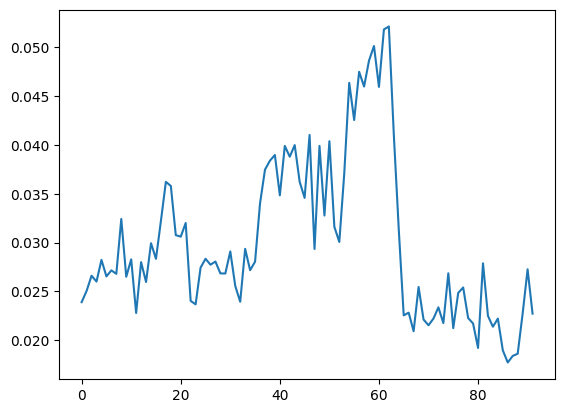

In [9]:
target_mean_by_week["target"].to_pandas().plot()

In [10]:
train.head()

case_id,date_decision,MONTH,WEEK_NUM,target
i64,date,i64,i64,i64
0,2019-01-03,201901,0,0
1,2019-01-03,201901,0,0
2,2019-01-04,201901,0,0
3,2019-01-03,201901,0,0
4,2019-01-04,201901,0,1


In [11]:
train_case_date = train.select("case_id", "date_decision")
train_case_date.head()

case_id,date_decision
i64,date
0,2019-01-03
1,2019-01-03
2,2019-01-04
3,2019-01-03
4,2019-01-04


In [12]:
test =  pl.read_csv(dataPath + 'csv_files/test/test_base.csv')
test = test.with_columns(pl.col("date_decision").str.to_date(format = "%Y-%m-%d"))
test

case_id,date_decision,MONTH,WEEK_NUM
i64,date,i64,i64
57543,2021-05-14,202201,100
57549,2022-01-17,202201,100
57551,2020-11-27,202201,100
57552,2020-11-27,202201,100
57569,2021-12-20,202201,100
57630,2021-03-16,202201,100
57631,2022-06-04,202201,100
57632,2022-02-05,202201,100
57633,2022-01-25,202201,100


# week check

In [13]:
train.unique(["WEEK_NUM", "date_decision"]).group_by("WEEK_NUM").agg(pl.col("date_decision")).sort("WEEK_NUM")

WEEK_NUM,date_decision
i64,list[date]
0,"[2019-01-03, 2019-01-04, … 2019-01-01]"
1,"[2019-01-14, 2019-01-11, … 2019-01-12]"
2,"[2019-01-20, 2019-01-17, … 2019-01-18]"
3,"[2019-01-27, 2019-01-24, … 2019-01-28]"
4,"[2019-01-30, 2019-02-03, … 2019-01-31]"
5,"[2019-02-07, 2019-02-11, … 2019-02-09]"
6,"[2019-02-13, 2019-02-14, … 2019-02-15]"
7,"[2019-02-20, 2019-02-25, … 2019-02-24]"
8,"[2019-03-01, 2019-03-02, … 2019-03-04]"


In [14]:
train_week_count = train.group_by("WEEK_NUM").count().sort("WEEK_NUM")
train_week_count.to_pandas().T

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
WEEK_NUM,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,90,91
count,16735,18841,17476,16108,14309,15335,16385,17238,13076,14716,...,5423,7295,9721,16239,15630,17886,14234,13600,12103,12674


# feature definition

In [15]:
feature_def = pd.read_parquet("/kaggle/input/home-credit-enhanced-feature-definitions/feature_definitions_dtypes_tables.parquet")
display(feature_def[feature_def["tables"].isnull()])
feature_def = feature_def[~feature_def["tables"].isnull()]
feature_def["tables"] = feature_def["tables"].apply(lambda x: x[0])

,Variable,Description,dtype,tables
434,score_940,Estimate of client's creditworthiness.,None,None


In [16]:
display(feature_def.sort_values("tables"))

,Variable,Description,dtype,tables
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actual).,Float64,train_applprev_1_0
111,credtype_587L,Credit type of previous application.,String,train_applprev_1_0
100,credamount_590A,Loan amount or card limit of previous applications.,Float64,train_applprev_1_0
99,credacc_transactions_402L,Number of transactions made with the previous credit account of the applicant.,Float64,train_applprev_1_0
98,credacc_status_367L,Account status of previous credit applications.,String,train_applprev_1_0
97,credacc_minhisbal_90A,Minimum historical balance of previous credit accounts.,Float64,train_applprev_1_0
96,credacc_maxhisbal_375A,Maximal historical balance of previous credit account,Float64,train_applprev_1_0
403,profession_152M,Profession of the client during their previous loan application.,String,train_applprev_1_0
95,credacc_credlmt_575A,Credit card credit limit provided for previous applications.,Float64,train_applprev_1_0
92,creationdate_885D,Date when previous application was created.,Date,train_applprev_1_0


In [17]:
feature_def = dict(zip(feature_def["Variable"], feature_def["dtype"]))

In [18]:
feature_definition_path = "/kaggle/input/home-credit-credit-risk-model-stability/feature_definitions.csv"
feature_definition = pd.read_csv(feature_definition_path)

# internal data check

# static 0

In [19]:
static0_paths = dataPath + f"/csv_files/train/train_static_0_*.csv"
    
static0 = [pl.read_csv(path) for path in glob(static0_paths)]
train_static = pl.concat(static0, how="vertical_relaxed").pipe(set_table_dtypes)

In [20]:
train_static.group_by("mastercontrelectronic_519L").count()

mastercontrelectronic_519L,count
f32,u32
0.0,1220640
null,306019


In [21]:
train_static.group_by("mastercontrexist_109L").count()

mastercontrexist_109L,count
f32,u32
0.0,1220640
null,306019


In [22]:
check_data(train_static, feature_definition)

whole shape:  (1526659, 169)
unique case id:  1526659
column, null ratio, non null unique date num, max
0.2739170961 644 2020-10-05 actualdpdtolerance_344P
0.3675503174 573 2020-10-05 amtinstpaidbefduel24m_4187115A
0.0000000000 644 2020-10-05 annuity_780A
0.0000026201 644 2020-10-05 annuitynextmonth_57A
0.0000000000 644 2020-10-05 applicationcnt_361L
0.0000000000 644 2020-10-05 applications30d_658L
0.0000000000 644 2020-10-05 applicationscnt_1086L
0.0000000000 644 2020-10-05 applicationscnt_464L
0.0000000000 644 2020-10-05 applicationscnt_629L
0.0000000000 644 2020-10-05 applicationscnt_867L
0.4016627158 644 2020-10-05 avgdbddpdlast24m_3658932P
0.6211236432 573 2020-10-05 avgdbddpdlast3m_4187120P
0.6372261258 404 2020-10-05 avgdbdtollast24m_4525197P
0.3060113621 644 2020-10-05 avgdpdtolclosure24_3658938P
0.4093088240 644 2020-10-05 avginstallast24m_3658937A
0.8935525222 403 2020-10-05 avglnamtstart24m_4525187A
0.4958579486 644 2020-10-05 avgmaxdpdlast9m_3716943P
0.5509946884 573 2020-1

column,column_0,column_1
str,str,str
"""bankacctype_710L""",null,"""CA"""
"""count""","""1109629""","""417030"""


column,column_0,column_1,column_2
str,str,str,str
"""cardtype_51L""",null,"""INSTANT""","""PERSONALIZED"""
"""count""","""1334968""","""189370""","""2321"""


column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""credtype_322L""","""COL""","""CAL""","""REL""",null
"""count""","""988376""","""345980""","""192302""","""1"""


column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""disbursementtype_67L""","""SBA""","""GBA""","""DD""",null
"""count""","""1138811""","""345919""","""41063""","""866"""


column,column_0,column_1,column_2
str,u32,u32,u32
"""equalitydataagreement_891L""",null,1,0
"""count""",1448632,73064,4963


column,column_0,column_1,column_2
str,u32,u32,u32
"""equalityempfrom_62L""",null,1,0
"""count""",1488847,36784,1028


column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""inittransactioncode_186L""","""POS""","""CASH""","""NDF""",null
"""count""","""1139228""","""345980""","""41450""","""1"""


column,column_0,column_1
str,u32,u32
"""isbidproduct_1095L""",0,1
"""count""",1350049,176610


column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""isbidproductrequest_292L""",null,"""false""","""False""","""true"""
"""count""","""1514201""","""8475""","""3982""","""1"""


column,column_0,column_1
str,u32,u32
"""isdebitcard_729L""",null,0
"""count""",1334357,192302


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""lastapprcommoditycat_1041M""","""a55475b1""","""P159_130_59""","""P12_6_178""","""P148_110_5""","""P109_133_183""","""P53_45_92""","""P52_56_90""","""P33_29_177""","""P100_96_175""","""P21_79_33""","""P128_43_169""","""P184_3_97""","""P187_118_47""","""P65_94_74""","""P201_79_148""","""P105_126_172""","""P216_109_183""","""P121_6_80""","""P177_46_174""","""P160_128_10""","""P48_73_87""","""P21_123_87""","""P110_120_162""","""P143_21_170""","""P137_157_60""","""P156_122_160""","""P75_42_174""","""P193_109_73""","""P156_50_173""","""P76_145_175""","""P98_19_172""","""P175_82_175""","""P141_125_135""","""P137_6_96""","""P181_140_94""","""P49_162_170""","""P3_103_80""","""P38_69_128""","""P117_143_46""","""P126_161_96""","""P201_108_190""","""P187_21_169""","""P58_25_91""","""P155_91_176""","""P93_39_173"""
"""count""","""852246""","""256506""","""156057""","""63318""","""56393""","""31302""","""22108""","""20971""","""17974""","""17526""","""9876""","""6593""","""2740""","""2490""","""2369""","""1990""","""1551""","""943""","""892""","""594""","""564""","""485""","""234""","""118""","""113""","""108""","""105""","""93""","""82""","""59""","""48""","""42""","""41""","""37""","""26""","""20""","""14""","""12""","""6""","""4""","""3""","""2""","""2""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_177,column_178,column_179,column_180,column_181,column_182,column_183,column_184,column_185,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199,column_200,column_201,column_202,column_203,column_204,column_205,column_206,column_207,column_208,column_209,column_210,column_211,column_212,column_213
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""lastapprcommoditytypec_5251766M""","""a55475b1""","""P75_90_70""","""P111_89_135""","""P142_50_170""","""P174_113_42""","""P172_87_177""","""P79_131_167""","""P42_60_161""","""P200_75_140""","""P95_36_171""","""P108_95_156""","""P165_57_169""","""P128_13_121""","""P123_124_181""","""P161_88_182""","""P30_45_143""","""P135_89_156""","""P206_72_67""","""P11_14_152""","""P98_55_164""","""P45_86_83""","""P149_85_125""","""P49_111_165""","""P136_59_154""","""P171_142_104""","""P126_18_172""","""P137_154_119""","""P48_108_131""","""P16_51_146""","""P101_97_152""","""P69_71_48""","""P179_147_79""","""P3_101_79""","""P210_68_40""","""P70_143_178""","""P78_110_79""",…,"""P185_139_82""","""P61_95_106""","""P7_14_175""","""P148_159_180""","""P19_26_59""","""P16_101_95""","""P40_144_87""","""P152_77_164""","""P138_18_172""","""P58_124_28""","""P23_89_124""","""P88_143_145""","""P46_41_174""","""P79_44_171""","""P89_148_176""","""P198_70_54""","""P13_114_11""","""P197_18_170""","""P117_121_167""","""P100_20_172""","""P61_42_174""","""P153_135_166""","""P158_79_160""","""P53_11_27""","""P140_2_44""","""P21_138_175""","""P131_77_175""","""P81_101_161""","""P89_124_184""","""P128_43_169""","""P140_117_94""","""P151_156_177""","""P164_86_182""","""P210_17_167""","""P194_119_6""","""P94_125_186""","""P22_46_79"""
"""count""","""1503657""","""7154""","""2081""","""1366""","""1025""","""1017""","""945""","""647""","""641""","""640""","""576""","""488""","""435""","""417""","""413""","""392""","""289""","""269""","""267""","""205""","""190""","""184""","""169""","""145""","""124""","""118""","""109""","""107""","""96""","""91""","""89""","""85""","""75""","""75""","""61""","""59""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44,column_45,column_46,column_47,column_48,column_49,column_50,column_51,column_52,column_53,column_54,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,column_64,column_65,column_66,column_67,column_68,column_69,column_70,column_71,column_72,column_73
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""lastcancelreason_561M""","""a55475b1""","""P94_109_143""","""P85_114_140""","""P198_89_166""","""P30_86_84""","""P180_60_137""","""P24_27_36""","""P73_130_169""","""P52_67_90""","""P11_56_131""","""P19_105_83""","""P69_72_116""","""P141_135_146""","""P129_162_80""","""P20_125_107""","""P32_163_96""","""P46_50_166""","""P120_0_10""","""P98_38_170""","""P99_98_113""","""P64_121_167""","""P183_71_60""","""P84_14_61""","""P163_9_145""","""P169_159_178""","""P5_143_178""","""P19_25_34""","""P122_66_161""","""P145_10_63""","""P53_10_15""","""P203_135_156""","""P185_66_167""","""P118_30_169""","""P201_100_144""","""P128_12_74""","""P175_4_106""","""P11_156_146""","""P187_10_172""","""P107_145_100""","""P55_81_55""","""P8_141_180""","""P123_22_171""","""P198_14_171""","""P195_62_170""","""P95_76_117""","""P23_22_19""","""P116_157_162""","""P145_77_120""","""P9_82_76""","""P32_86_86""","""P150_0_30""","""P94_154_184""","""P57_100_127""","""P16_126_23""","""P205_40_167""","""P118_140_56""","""P28_71_137""","""P199_114_13""","""P68_132_180""","""P17_160_152""","""P129_101_181""","""P72_115_176""","""P188_66_164""","""P203_151_99""","""P151_143_25""","""P91_110_150""","""P59_114_135""","""P204_22_168""","""P191_55_173""","""P7_85_64""","""P89_110_159""","""P60_137_164""","""P65_58_157""","""P60_96_75"""
"""count""","""1074053""","""300797""","""23149""","""18415""","""17266""","""12145""","""11241""","""10725""","""8204""","""7678""","""5921""","""5360""","""4995""","""4919""","""4881""","""3325""","""1774""","""1709""","""1387""","""1233""","""1066""","""820""","""748""","""657""","""576""","""557""","""506""","""433""","""398""","""160""","""132""","""106""","""103""","""102""","""94""","""92""","""90""","""88""","""85""","""85""","""66""","""60""","""54""","""53""","""37""","""35""","""31""","""28""","""28""","""26""","""23""","""22""","""20""","""19""","""19""","""11""","""9""","""6""","""5""","""4""","""4""","""3""","""3""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42,column_43,column_44
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""lastrejectcommoditycat_161M""","""a55475b1""","""P159_130_59""","""P12_6_178""","""P148_110_5""","""P109_133_183""","""P53_45_92""","""P52_56_90""","""P33_29_177""","""P100_96_175""","""P21_79_33""","""P128_43_169""","""P184_3_97""","""P187_118_47""","""P65_94_74""","""P105_126_172""","""P201_79_148""","""P121_6_80""","""P216_109_183""","""P160_128_10""","""P21_123_87""","""P177_46_174""","""P48_73_87""","""P193_109_73""","""P156_122_160""","""P137_157_60""","""P110_120_162""","""P75_42_174""","""P143_21_170""","""P141_125_135""","""P156_50_173""","""P76_145_175""","""P137_6_96""","""P98_19_172""","""P175_82_175""","""P181_140_94""","""P49_162_170""","""P38_69_128""","""P151_9_55""","""P201_108_190""","""P117_143_46""","""P3_103_80""","""P126_161_96""","""P187_21_169""","""P58_25_91""","""P176_123_187"""
"""count""","""1215985""","""103597""","""61943""","""41122""","""27700""","""19262""","""16627""","""9494""","""9479""","""6572""","""3635""","""3032""","""1901""","""1435""","""1212""","""736""","""581""","""457""","""331""","""329""","""238""","""227""","""210""","""108""","""78""","""60""","""57""","""51""","""44""","""34""","""26""","""23""","""19""","""13""","""12""","""8""","""6""","""4""","""3""","""2""","""2""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_150,column_151,column_152,column_153,column_154,column_155,column_156,column_157,column_158,column_159,column_160,column_161,column_162,column_163,column_164,column_165,column_166,column_167,column_168,column_169,column_170,column_171,column_172,column_173,column_174,column_175,column_176,column_177,column_178,column_179,column_180,column_181,column_182,column_183,column_184,column_185,column_186
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""lastrejectcommodtypec_5251769M""","""a55475b1""","""P75_90_70""","""P111_89_135""","""P142_50_170""","""P79_131_167""","""P108_95_156""","""P95_36_171""","""P174_113_42""","""P172_87_177""","""P200_75_140""","""P165_57_169""","""P42_60_161""","""P161_88_182""","""P30_45_143""","""P128_13_121""","""P123_124_181""","""P136_59_154""","""P206_72_67""","""P49_111_165""","""P135_89_156""","""P149_85_125""","""P171_142_104""","""P45_86_83""","""P98_55_164""","""P137_154_119""","""P48_108_131""","""P126_18_172""","""P78_110_79""","""P184_79_111""","""P216_127_49""","""P101_97_152""","""P2_128_156""","""P146_17_171""","""P70_143_178""","""P3_101_79""","""P69_71_48""",…,"""P149_58_77""","""P214_25_167""","""P100_118_186""","""P22_109_158""","""P28_129_133""","""P137_114_5""","""P88_90_61""","""P102_65_162""","""P16_101_95""","""P174_126_148""","""P132_44_167""","""P83_11_24""","""P157_62_111""","""P132_160_163""","""P103_64_162""","""P21_102_104""","""P91_144_104""","""P172_30_169""","""P137_6_96""","""P61_95_106""","""P160_161_167""","""P38_126_100""","""P135_122_124""","""P93_145_121""","""P26_100_76""","""P137_122_166""","""P151_156_177""","""P86_63_168""","""P125_63_164""","""P164_84_181""","""P17_63_62""","""P21_148_165""","""P107_45_172""","""P162_157_176""","""P49_58_169""","""P27_87_74""","""P80_20_176"""
"""count""","""1513847""","""3429""","""940""","""796""","""796""","""627""","""535""","""530""","""523""","""401""","""363""","""280""","""234""","""218""","""210""","""200""","""199""","""133""","""129""","""117""","""98""","""98""","""91""","""84""","""77""","""72""","""67""","""49""","""47""","""45""","""44""","""44""","""44""","""44""","""43""","""43""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""lastrejectreason_759M""","""a55475b1""","""P99_56_166""","""P94_109_143""","""P45_84_106""","""P198_131_9""","""P48_22_32""","""P30_86_84""","""P121_60_164""","""P196_88_176""","""P52_67_90""","""P69_72_116""","""P84_14_61""","""P129_162_80""","""P19_25_34""","""P5_143_178""","""P53_10_15""","""P64_121_167""","""P185_59_178"""
"""count""","""953655""","""262595""","""161526""","""69580""","""67386""","""3763""","""2485""","""1661""","""1356""","""1192""","""424""","""374""","""365""","""90""","""72""","""71""","""63""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""lastrejectreasonclient_4145040M""","""a55475b1""","""P94_109_143""","""P30_86_84""","""P52_67_90""","""P69_72_116""","""P129_162_80""","""P84_14_61""","""P64_121_167""","""P19_25_34""","""P5_143_178""","""P53_10_15""","""P203_151_99""","""P59_114_135""","""P204_22_168"""
"""count""","""975347""","""485428""","""31868""","""12029""","""8487""","""6931""","""3349""","""1388""","""881""","""740""","""205""","""2""","""2""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11
str,str,str,str,str,str,str,str,str,str,str,str,str
"""lastst_736L""","""D""","""A""","""K""",null,"""T""","""N""","""S""","""Q""","""L""","""H""","""P""","""R"""
"""count""","""386249""","""371301""","""323806""","""305137""","""112948""","""23240""","""2327""","""1146""","""344""","""134""","""14""","""13"""


column,column_0,column_1,column_2
str,u32,u32,u32
"""opencred_647L""",0,null,1
"""count""",1170710,305137,50812


column,column_0,column_1
str,str,str
"""paytype1st_925L""","""OTHER""",null
"""count""","""1468084""","""58575"""


column,column_0,column_1
str,str,str
"""paytype_783L""","""OTHER""",null
"""count""","""1468084""","""58575"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199,column_200,column_201,column_202,column_203,column_204,column_205,column_206,column_207,column_208,column_209,column_210,column_211,column_212,column_213,column_214,column_215,column_216,column_217,column_218,column_219,column_220,column_221,column_222
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""previouscontdistrict_112M""","""a55475b1""","""P131_33_167""","""P197_47_166""","""P123_6_84""","""P98_137_111""","""P204_99_158""","""P159_143_123""","""P62_144_102""","""P147_21_170""","""P178_112_160""","""P111_135_181""","""P19_11_176""","""P112_89_137""","""P109_162_152""","""P54_133_26""","""P214_86_174""","""P80_85_140""","""P152_70_56""","""P111_125_171""","""P99_153_174""","""P56_25_83""","""P76_152_180""","""P38_65_49""","""P157_94_145""","""P156_128_17""","""P158_150_171""","""P158_121_167""","""P47_144_70""","""P147_6_101""","""P117_87_136""","""P173_115_85""","""P194_92_171""","""P142_57_166""","""P181_116_184""","""P85_130_149""","""P92_92_93""",…,"""P78_30_175""","""P42_21_57""","""P81_94_108""","""P149_82_178""","""P177_138_94""","""P211_30_165""","""P32_135_170""","""P104_14_35""","""P111_148_100""","""P63_14_24""","""P109_39_170""","""P108_50_169""","""P54_152_154""","""P182_70_81""","""P31_42_128""","""P110_60_165""","""P74_104_25""","""P136_95_178""","""P21_87_50""","""P73_74_80""","""P133_91_178""","""P108_160_76""","""P21_84_40""","""P214_125_25""","""P18_55_149""","""P27_34_157""","""P97_153_169""","""P16_81_96""","""P199_161_73""","""P86_0_60""","""P210_51_101""","""P107_30_170""","""P148_155_175""","""P162_155_169""","""P70_53_172""","""P156_54_111""","""P0_140_162"""
"""count""","""488428""","""60399""","""50680""","""41831""","""32326""","""27657""","""25427""","""24528""","""22784""","""21826""","""20093""","""19991""","""16985""","""14524""","""14052""","""13379""","""13261""","""12667""","""12656""","""12133""","""11327""","""10583""","""9907""","""9392""","""9282""","""9260""","""9136""","""9034""","""9010""","""8863""","""8783""","""8593""","""8423""","""8318""","""7969""","""7791""",…,"""816""","""807""","""807""","""803""","""778""","""776""","""766""","""675""","""643""","""542""","""542""","""511""","""463""","""385""","""342""","""304""","""292""","""288""","""268""","""261""","""222""","""212""","""208""","""206""","""200""","""133""","""112""","""106""","""105""","""97""","""78""","""77""","""66""","""62""","""52""","""42""","""9"""


column,column_0,column_1,column_2
str,str,str,str
"""twobodfilling_608L""","""FO""","""BO""",null
"""count""","""1481471""","""45097""","""91"""


column,column_0,column_1
str,str,str
"""typesuite_864L""",null,"""AL"""
"""count""","""1121505""","""405154"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""actualdpdtolerance_344P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""amtinstpaidbefduel24m_4187115A""",0.0,3721.0,11071.0,19209.126953,29758.396484,43648.265625,63088.558594,93382.453125,150680.703125
"""annuity_780A""",1360.599976,1782.0,2167.600098,2609.400146,3151.800049,3828.400146,4714.600098,5973.600098,7752.399902
"""annuitynextmonth_57A""",0.0,0.0,0.0,0.0,0.0,0.0,951.600037,2861.199951,5332.200195
"""applicationcnt_361L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""applications30d_658L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"""applicationscnt_1086L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""applicationscnt_464L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""applicationscnt_629L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


case_id,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,…,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,payvacationpostpone_4187118D,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,previouscontdistrict_112M,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,validfrom_1069D,date_decision
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,bool,str,str,date,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,f32,f32,f32,f32,f32,f32,f32,f32,str,str,date,date
0,null,null,1917.599976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,0.0,0.0,0.0,null,"""OTHER""","""OTHER""",null,null,null,null,null,null,24.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""",null,null,2019-01-03
1,null,null,3134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,0.0,0.0,0.0,null,"""OTHER""","""OTHER""",null,null,null,null,null,null,18.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""",null,null,2019-01-03
2,null,null,4937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,0.0,0.0,0.0,false,"""OTHER""","""OTHER""",null,null,null,null,null,null,36.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""","""AL""",null,2019-01-04
3,null,null,4643.600098,0.0,0.0,1.0,0.0,2.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,1.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,0.0,0.0,1.0,false,"""OTHER""","""OTHER""",null,null,null,null,null,null,12.0,0.0,0.0,null,"""a55475b1""",null,1.0,1.0,null,null,0.0,0.0,null,"""BO""","""AL""",null,2019-01-03
4,null,null,3390.199951,0.0,0.0,1.0,0.0,0.0,0.0,1.0,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,null,null,null,null,null,null,null,null,0.0,0.0,0.0,false,"""OTHER""","""OTHER""",null,null,null,null,null,null,24.0,0.0,0.0,null,"""a55475b1""",null,0.0,0.0,null,null,0.0,0.0,null,"""BO""","""AL""",null,2019-01-04


In [23]:
common_id = train_static.unique("case_id").select("case_id")
common_id.shape

(1526659, 1)

# applprev

In [24]:
train_applprev = pl.concat(
    [
        pl.read_csv(dataPath  + "/csv_files/train/train_applprev_1_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath  + "/csv_files/train/train_applprev_1_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)

In [25]:
check_data(train_applprev, feature_definition, 1)

whole shape:  (6525979, 42)
unique case id:  1221522
column, null ratio, non null unique date num, max
0.0003830843 644 2020-10-05 actualdpd_943P
0.0384212085 644 2020-10-05 annuity_853A
0.4612785300 644 2020-10-05 approvaldate_319D
0.7648708339 643 2020-10-05 byoccupationinc_3656910L
0.0000000000 644 2020-10-05 cancelreason_3545846M
0.5454237594 644 2020-10-05 childnum_21L
0.0000101134 644 2020-10-05 creationdate_885D
0.9509600016 643 2020-10-05 credacc_actualbalance_314A
0.0297475674 644 2020-10-05 credacc_credlmt_575A
0.9509600016 643 2020-10-05 credacc_maxhisbal_375A
0.9509600016 643 2020-10-05 credacc_minhisbal_90A
0.9509600016 643 2020-10-05 credacc_status_367L
0.9509600016 643 2020-10-05 credacc_transactions_402L
0.0309835505 644 2020-10-05 credamount_590A
0.0309835505 644 2020-10-05 credtype_587L
0.3442413774 644 2020-10-05 currdebt_94A
0.4814224808 644 2020-10-05 dateactivated_425D
0.0000000000 644 2020-10-05 district_544M
0.0309835505 644 2020-10-05 downpmt_134A
0.7279189835 

column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_39,column_40,column_41,column_42,column_43,column_44,column_45,column_46,column_47,column_48,column_49,column_50,column_51,column_52,column_53,column_54,column_55,column_56,column_57,column_58,column_59,column_60,column_61,column_62,column_63,column_64,column_65,column_66,column_67,column_68,column_69,column_70,column_71,column_72,column_73,column_74,column_75
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""cancelreason_3545846M""","""a55475b1""","""P94_109_143""","""P30_86_84""","""P180_60_137""","""P73_130_169""","""P198_89_166""","""P85_114_140""","""P52_67_90""","""P24_27_36""","""P141_135_146""","""P11_56_131""","""P69_72_116""","""P129_162_80""","""P19_105_83""","""P32_163_96""","""P98_38_170""","""P20_125_107""","""P120_0_10""","""P84_14_61""","""P99_98_113""","""P46_50_166""","""P64_121_167""","""P163_9_145""","""P169_159_178""","""P19_25_34""","""P183_71_60""","""P5_143_178""","""P145_10_63""","""P118_30_169""","""P203_135_156""","""P53_10_15""","""P11_156_146""","""P122_66_161""","""P198_14_171""","""P185_66_167""","""P195_62_170""",…,"""P187_10_172""","""P175_4_106""","""P201_100_144""","""P95_76_117""","""P8_141_180""","""P123_22_171""","""P32_86_86""","""P116_157_162""","""P23_22_19""","""P150_0_30""","""P9_82_76""","""P188_66_164""","""P145_77_120""","""P205_40_167""","""P94_154_184""","""P16_126_23""","""P57_100_127""","""P118_140_56""","""P28_71_137""","""P191_55_173""","""P91_110_150""","""P199_114_13""","""P60_137_164""","""P7_85_64""","""P68_132_180""","""P129_101_181""","""P17_160_152""","""P166_126_174""","""P72_115_176""","""P60_96_75""","""P59_114_135""","""P204_22_168""","""P151_143_25""","""P26_44_63""","""P203_151_99""","""P89_110_159""","""P65_58_157"""
"""count""","""4453391""","""1503281""","""80204""","""74966""","""68170""","""63312""","""58526""","""31744""","""30667""","""23205""","""20929""","""20862""","""15908""","""13345""","""9576""","""9524""","""9356""","""7741""","""6061""","""3891""","""3786""","""2787""","""1990""","""1680""","""1442""","""1361""","""1298""","""676""","""627""","""624""","""565""","""517""","""497""","""465""","""347""","""325""",…,"""187""","""145""","""140""","""137""","""123""","""102""","""83""","""79""","""76""","""53""","""51""","""47""","""45""","""38""","""35""","""34""","""33""","""24""","""19""","""16""","""13""","""13""","""12""","""10""","""8""","""7""","""6""","""6""","""5""","""3""","""3""","""3""","""3""","""3""","""2""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""credacc_status_367L""",null,"""AC""","""CL""","""CA""","""PCL""","""PO""","""CR"""
"""count""","""6205945""","""190725""","""104915""","""21150""","""2642""","""531""","""71"""


column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""credtype_587L""","""COL""","""CAL""","""REL""",null
"""count""","""3285005""","""2575759""","""463017""","""202198"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_1026,column_1027,column_1028,column_1029,column_1030,column_1031,column_1032,column_1033,column_1034,column_1035,column_1036,column_1037,column_1038,column_1039,column_1040,column_1041,column_1042,column_1043,column_1044,column_1045,column_1046,column_1047,column_1048,column_1049,column_1050,column_1051,column_1052,column_1053,column_1054,column_1055,column_1056,column_1057,column_1058,column_1059,column_1060,column_1061,column_1062
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""district_544M""","""a55475b1""","""P131_33_167""","""P123_6_84""","""P197_47_166""","""P204_99_158""","""P98_137_111""","""P62_144_102""","""P159_143_123""","""P147_21_170""","""P111_135_181""","""P178_112_160""","""P80_85_140""","""P19_11_176""","""P54_133_26""","""P109_162_152""","""P214_86_174""","""P112_89_137""","""P99_153_174""","""P152_70_56""","""P158_150_171""","""P111_125_171""","""P156_128_17""","""P194_92_171""","""P76_152_180""","""P47_144_70""","""P56_25_83""","""P92_92_93""","""P38_65_49""","""P157_94_145""","""P181_116_184""","""P121_97_69""","""P147_6_101""","""P192_103_107""","""P173_115_85""","""P117_87_136""","""P158_121_167""",…,"""P135_124_143""","""P172_53_175""","""P148_3_90""","""P182_0_97""","""P74_146_170""","""P25_105_146""","""P150_152_88""","""P106_155_149""","""P129_96_127""","""P118_33_168""","""P164_17_172""","""P60_149_48""","""P46_75_94""","""P218_63_127""","""P19_86_86""","""P111_92_120""","""P41_119_194""","""P85_144_159""","""P48_57_177""","""P111_122_156""","""P22_161_136""","""P213_85_165""","""P50_1_189""","""P163_48_174""","""P110_156_140""","""P20_42_66""","""P34_8_113""","""P213_15_168""","""P145_38_170""","""P24_131_135""","""P85_25_175""","""P176_39_167""","""P155_86_182""","""P119_42_170""","""P0_149_171""","""P12_15_65""","""P205_109_180"""
"""count""","""780752""","""291514""","""253706""","""207463""","""180781""","""147375""","""135824""","""133926""","""128720""","""116816""","""111027""","""90197""","""81420""","""80466""","""75305""","""69863""","""69029""","""68761""","""66816""","""61933""","""61751""","""59055""","""58122""","""56374""","""56338""","""56149""","""53332""","""52233""","""52179""","""50942""","""48389""","""46335""","""44983""","""42844""","""41981""","""41584""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""education_1138M""","""a55475b1""","""P97_36_170""","""P33_146_175""","""P106_81_188""","""P17_36_170""","""P157_18_172"""
"""count""","""3073021""","""2311198""","""1051526""","""44038""","""43134""","""3062"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""familystate_726L""","""MARRIED""",null,"""SINGLE""","""WIDOWED""","""DIVORCED""","""LIVING_WITH_PARTNER"""
"""count""","""2986750""","""2393892""","""593164""","""359309""","""130820""","""62044"""


column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""inittransactioncode_279L""","""POS""","""CASH""","""NDF""",null
"""count""","""3501653""","""2576770""","""245358""","""202198"""


column,column_0,column_1,column_2
str,u32,u32,u32
"""isbidproduct_390L""",0,1,null
"""count""",6162278,363635,66


column,column_0,column_1,column_2
str,u32,u32,u32
"""isdebitcard_527L""",null,0,1
"""count""",6062966,358804,104209


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""postype_4733339M""","""a55475b1""","""P177_117_192""","""P46_145_78""","""P149_40_170""","""P60_146_156""","""P67_102_161""","""P217_110_186""","""P169_115_83""","""P140_48_169"""
"""count""","""3779825""","""1340808""","""695087""","""271344""","""208325""","""179886""","""31973""","""14614""","""4117"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_11471,column_11472,column_11473,column_11474,column_11475,column_11476,column_11477,column_11478,column_11479,column_11480,column_11481,column_11482,column_11483,column_11484,column_11485,column_11486,column_11487,column_11488,column_11489,column_11490,column_11491,column_11492,column_11493,column_11494,column_11495,column_11496,column_11497,column_11498,column_11499,column_11500,column_11501,column_11502,column_11503,column_11504,column_11505,column_11506,column_11507
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""profession_152M""","""a55475b1""","""P46_72_80""","""P104_137_180""","""P167_22_171""","""P143_116_69""","""P139_125_64""","""P21_76_53""","""P25_111_112""","""P103_114_185""","""P10_42_172""","""P116_59_165""","""P121_114_58""","""P116_87_104""","""P203_66_70""","""P95_143_148""","""P130_31_165""","""P94_2_52""","""P29_149_169""","""P183_126_172""","""P182_36_165""","""P62_39_175""","""P80_95_87""","""P1_65_115""","""P160_54_147""","""P126_158_81""","""P75_153_182""","""P139_105_168""","""P49_106_136""","""P170_27_170""","""P135_113_37""","""P126_21_171""","""P27_42_77""","""P142_60_165""","""P170_72_73""","""P43_122_132""","""P148_72_83""",…,"""P174_153_91""","""P206_52_123""","""P128_128_165""","""P92_8_1""","""P149_78_132""","""P89_13_66""","""P74_9_14""","""P140_6_101""","""P55_114_24""","""P102_147_111""","""P0_34_36""","""P214_55_135""","""P29_83_84""","""P12_45_134""","""P140_26_169""","""P32_59_102""","""P172_89_179""","""P53_118_23""","""P51_135_37""","""P80_17_53""","""P35_21_24""","""P72_23_174""","""P93_125_183""","""P60_26_182""","""P74_99_36""","""P206_2_51""","""P126_61_165""","""P94_136_131""","""P214_80_161""","""P178_37_166""","""P43_52_96""","""P111_121_138""","""P207_145_160""","""P137_117_97""","""P132_110_187""","""P141_86_181""","""P95_121_189"""
"""count""","""6452619""","""1963""","""1395""","""1073""","""1007""","""993""","""984""","""975""","""805""","""799""","""798""","""746""","""712""","""675""","""659""","""626""","""615""","""581""","""566""","""543""","""518""","""503""","""465""","""443""","""439""","""436""","""424""","""423""","""415""","""414""","""413""","""386""","""362""","""350""","""322""","""313""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""rejectreason_755M""","""a55475b1""","""P94_109_143""","""P99_56_166""","""P45_84_106""","""P198_131_9""","""P30_86_84""","""P48_22_32""","""P52_67_90""","""P196_88_176""","""P121_60_164""","""P69_72_116""","""P129_162_80""","""P84_14_61""","""P19_25_34""","""P5_143_178""","""P64_121_167""","""P53_10_15""","""P185_59_178"""
"""count""","""4663656""","""810325""","""713198""","""155196""","""153879""","""7849""","""7239""","""4267""","""3459""","""3014""","""1340""","""1079""","""768""","""205""","""174""","""166""","""150""","""15"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""rejectreasonclient_4145042M""","""a55475b1""","""P94_109_143""","""P30_86_84""","""P52_67_90""","""P69_72_116""","""P129_162_80""","""P84_14_61""","""P64_121_167""","""P19_25_34""","""P5_143_178""","""P53_10_15""","""P204_22_168""","""P59_114_135""","""P203_151_99"""
"""count""","""4952742""","""1417017""","""78013""","""30538""","""20398""","""15536""","""5831""","""2746""","""1383""","""1247""","""520""","""3""","""3""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11
str,str,str,str,str,str,str,str,str,str,str,str,str
"""status_219L""","""D""","""K""","""A""","""T""","""N""","""Q""","""S""","""L""","""H""",null,"""P""","""R"""
"""count""","""2667953""","""2658434""","""715907""","""441632""","""30430""","""7477""","""2567""","""959""","""472""","""66""","""59""","""23"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""actualdpd_943P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""annuity_853A""",862.400024,1473.200073,1937.800049,2359.800049,2787.0,3320.400146,4002.400146,4985.800293,6650.200195
"""byoccupationinc_3656910L""",1.0,1.0,1.0,1.0,8000.0,17000.0,25000.0,35000.0,50000.0
"""childnum_21L""",0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0
"""credacc_actualbalance_314A""",0.0,0.0,3.2,136.012802,6103.171875,15077.855469,22594.0,33227.398438,52800.0
"""credacc_credlmt_575A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""credacc_maxhisbal_375A""",-13777.350586,0.0,0.0,0.0,0.0,0.0,0.0,11.2,150.820602
"""credacc_minhisbal_90A""",-21092.826172,-4234.0,0.0,0.0,0.0,0.0,0.0,0.0,24.295401
"""credacc_transactions_402L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


case_id,actualdpd_943P,annuity_853A,approvaldate_319D,byoccupationinc_3656910L,cancelreason_3545846M,childnum_21L,creationdate_885D,credacc_actualbalance_314A,credacc_credlmt_575A,credacc_maxhisbal_375A,credacc_minhisbal_90A,credacc_status_367L,credacc_transactions_402L,credamount_590A,credtype_587L,currdebt_94A,dateactivated_425D,district_544M,downpmt_134A,dtlastpmt_581D,dtlastpmtallstes_3545839D,education_1138M,employedfrom_700D,familystate_726L,firstnonzeroinstldate_307D,inittransactioncode_279L,isbidproduct_390L,isdebitcard_527L,mainoccupationinc_437A,maxdpdtolerance_577P,num_group1,outstandingdebt_522A,pmtnum_8L,postype_4733339M,profession_152M,rejectreason_755M,rejectreasonclient_4145042M,revolvingaccount_394A,status_219L,tenor_203L,date_decision
i64,f32,f32,date,f32,str,f32,date,f32,f32,f32,f32,str,f32,f32,str,f32,date,str,f32,date,date,str,date,str,date,str,bool,bool,f32,f32,i64,f32,f32,str,str,str,str,f32,str,f32,date
2,0.0,640.200012,null,null,"""a55475b1""",0.0,2013-04-03,null,0.0,null,null,null,null,10000.0,"""CAL""",null,null,"""P136_108_173""",0.0,null,null,"""P97_36_170""",2010-02-15,"""SINGLE""",2013-05-04,"""CASH""",false,null,8200.0,null,0,null,24.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",24.0,2019-01-04
2,0.0,1682.400024,null,null,"""a55475b1""",0.0,2013-04-03,null,0.0,null,null,null,null,16000.0,"""CAL""",null,null,"""P136_108_173""",0.0,null,null,"""P97_36_170""",2010-02-15,"""SINGLE""",2013-05-04,"""CASH""",false,null,8200.0,null,1,null,12.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""D""",12.0,2019-01-04
3,0.0,6140.0,null,null,"""P94_109_143""",null,2019-01-07,null,0.0,null,null,null,null,59999.800781,"""CAL""",null,null,"""P131_33_167""",0.0,null,null,"""P97_36_170""",2018-05-15,"""MARRIED""",2019-02-07,"""CASH""",false,null,11000.0,null,0,null,12.0,"""a55475b1""","""a55475b1""","""P94_109_143""","""a55475b1""",null,"""D""",12.0,2019-01-03
4,0.0,2556.600098,null,null,"""P24_27_36""",null,2019-01-08,null,0.0,null,null,null,null,40000.0,"""CAL""",null,null,"""P194_82_174""",0.0,null,null,"""a55475b1""",null,null,2019-02-08,"""CASH""",false,null,16000.0,null,0,null,24.0,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""T""",24.0,2019-01-04
5,0.0,null,null,null,"""P85_114_140""",null,2019-01-16,null,null,null,null,null,null,null,null,null,null,"""P54_133_26""",null,null,null,"""a55475b1""",null,null,null,null,false,null,62000.0,null,0,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,"""T""",null,2019-01-02


In [26]:
tmp = train_applprev.filter(pl.col("credacc_status_367L").is_not_null()).group_by("case_id").agg(pl.col("credacc_status_367L").mode().sort())
tmp = tmp.with_columns(pl.col("credacc_status_367L").list.len().alias("len"))
tmp = tmp.with_columns(pl.col("credacc_status_367L").list.get(0).alias("ele0"))
tmp = tmp.with_columns(pl.col("credacc_status_367L").list.get(1).alias("ele1"))
tmp

case_id,credacc_status_367L,len,ele0,ele1
i64,list[str],u32,str,str
2657142,"[""AC""]",1,"""AC""",null
240193,"[""AC""]",1,"""AC""",null
1578361,"[""CL""]",1,"""CL""",null
254758,"[""AC""]",1,"""AC""",null
1870725,"[""CL""]",1,"""CL""",null
1897833,"[""CL""]",1,"""CL""",null
113012,"[""CA"", ""CL""]",2,"""CA""","""CL"""
1833351,"[""AC""]",1,"""AC""",null
2622567,"[""CA""]",1,"""CA""",null


In [27]:
train_applprev = train_applprev.join(train_case_date, on = "case_id", how = "left")
train_applprev = train_applprev.with_columns((pl.col("creationdate_885D") - pl.col("date_decision")).alias("days_before_decision"))
train_applprev = train_applprev.with_columns(pl.col("days_before_decision").dt.total_days() * -1)
for i in range(1, 10):
    print(i / 10, train_applprev.select("days_before_decision").quantile(i / 10, "linear"))

0.1 shape: (1, 1)
┌──────────────────────┐
│ days_before_decision │
│ ---                  │
│ f64                  │
╞══════════════════════╡
│ 115.0                │
└──────────────────────┘
0.2 shape: (1, 1)
┌──────────────────────┐
│ days_before_decision │
│ ---                  │
│ f64                  │
╞══════════════════════╡
│ 252.0                │
└──────────────────────┘
0.3 shape: (1, 1)
┌──────────────────────┐
│ days_before_decision │
│ ---                  │
│ f64                  │
╞══════════════════════╡
│ 402.0                │
└──────────────────────┘
0.4 shape: (1, 1)
┌──────────────────────┐
│ days_before_decision │
│ ---                  │
│ f64                  │
╞══════════════════════╡
│ 583.0                │
└──────────────────────┘
0.5 shape: (1, 1)
┌──────────────────────┐
│ days_before_decision │
│ ---                  │
│ f64                  │
╞══════════════════════╡
│ 806.0                │
└──────────────────────┘
0.6 shape: (1, 1)
┌────────────────

In [28]:
train_applprev.group_by("days_before_decision").count().sort("days_before_decision").head(10)

days_before_decision,count
i64,u32
null,66
-14,52954
-13,18561
-12,9403
-11,7567
-10,6836
-9,6012
-8,5684
-7,5888


In [29]:
case_count = train_applprev.group_by("case_id").count()
case_count.columns = ["case_id", "case_count"]
case_count.group_by("case_count").count().sort("case_count").transpose(include_header=True)

column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19
str,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""case_count""",1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
"""count""",229567,187158,151625,121964,99021,79528,64133,51803,41798,33832,27502,22308,18362,15055,12240,10404,8424,6954,5783,34061


In [30]:
train_applprev = (
    train_applprev
    .with_columns(pl.col("creationdate_885D").dt.year().alias("year"))
    .with_columns(pl.col("creationdate_885D").dt.month().alias("month"))
)

In [31]:
train_applprev.group_by("year", "month").count().sort("year", "month").filter(pl.col("year")>=2019)

year,month,count
i32,i8,u32
2019,1,137585
2019,2,104496
2019,3,116307
2019,4,112953
2019,5,103730
2019,6,105106
2019,7,108560
2019,8,102820
2019,9,101744


In [32]:
common_id = common_id.join(train_applprev.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(1221522, 1)

# applprev2

In [33]:
train_applprev2 = pl.read_csv(dataPath + "/csv_files/train/train_applprev_2.csv") 
check_data(train_applprev2, feature_definition, 2)

whole shape:  (14075487, 7)
unique case id:  1221522
column, null ratio, non null unique date num, max
0.0077616497 644 2020-10-05 cacccardblochreas_147M
0.1700869036 644 2020-10-05 conts_type_509L
0.9756965425 643 2020-10-05 credacc_cards_status_52L
category value count


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
str,str,str,str,str,str,str,str,str,str,str
"""cacccardblochreas_147M""","""a55475b1""",null,"""P33_145_161""","""P201_63_60""","""P19_60_110""","""P23_105_103""","""P133_119_56""","""P41_107_150""","""P17_56_144""","""P127_74_114"""
"""count""","""13958443""","""109249""","""3309""","""2960""","""1135""","""117""","""100""","""92""","""63""","""19"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
str,str,str,str,str,str,str,str,str,str,str
"""conts_type_509L""","""PRIMARY_MOBILE""","""HOME_PHONE""",null,"""EMPLOYMENT_PHONE""","""PHONE""","""PRIMARY_EMAIL""","""ALTERNATIVE_PHONE""","""SECONDARY_MOBILE""","""WHATSAPP""","""SKYPE"""
"""count""","""6294386""","""2472180""","""2394056""","""1679417""","""924958""","""257126""","""37833""","""15504""","""25""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""credacc_cards_status_52L""",null,"""CANCELLED""","""ACTIVE""","""INACTIVE""","""BLOCKED""","""RENEWED""","""UNCONFIRMED"""
"""count""","""13733404""","""167031""","""109642""","""62968""","""2098""","""304""","""40"""


numeric col dist


case_id,cacccardblochreas_147M,conts_type_509L,credacc_cards_status_52L,num_group1,num_group2,date_decision
i64,str,str,str,i64,i64,date
2,null,"""PRIMARY_MOBILE…",null,0,0,2019-01-04
2,null,"""EMPLOYMENT_PHO…",null,0,1,2019-01-04
2,null,"""PRIMARY_MOBILE…",null,1,0,2019-01-04
2,null,"""EMPLOYMENT_PHO…",null,1,1,2019-01-04
3,null,"""PHONE""",null,0,0,2019-01-03


In [34]:
common_id = common_id.join(train_applprev2.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(1221522, 1)

# person

In [35]:
train_person = pl.read_csv(dataPath + "/csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
cols = [i for i in train_person.columns if i not in ["case_id", "num_group1"]]
train_person = train_person.select(["case_id", "num_group1"] + cols)

In [36]:
count_df = train_person.group_by("empladdr_district_926M").count().sort("count", descending = True)
count_df = count_df.with_columns((pl.col("count") / train_person.shape[0]).alias("ratio"))
count_df = count_df.with_columns(pl.col("ratio").cum_sum())
count_df.head(20)

empladdr_district_926M,count,ratio
str,u32,f64
"""a55475b1""",2448480,0.823298
"""P197_47_166""",57521,0.842639
"""P131_33_167""",41960,0.856748
"""P62_144_102""",21172,0.863867
"""P98_137_111""",20595,0.870792
"""P123_6_84""",19021,0.877188
"""P159_143_123""",15720,0.882474
"""P19_11_176""",13883,0.887142
"""P109_162_152""",12941,0.891493


In [37]:
person1_first1 = train_person.group_by("case_id").first().sort("case_id")
person1_first2 = train_person.filter(pl.col("num_group1")==0).sort("case_id")
print(person1_first1.equals(person1_first2))
del person1_first1, person1_first2

False


In [38]:
check_data(train_person.filter(pl.col("num_group1")==0), feature_definition, 1)

whole shape:  (1526659, 38)
unique case id:  1526659
column, null ratio, non null unique date num, max
0.0000000000 644 2020-10-05 birth_259D
0.9918396970 633 2020-10-05 birthdate_87D
1.0000000000 0 None childnum_185L
0.0000000000 644 2020-10-05 contaddr_district_15M
0.0002888661 644 2020-10-05 contaddr_matchlist_1032L
0.0002888661 644 2020-10-05 contaddr_smempladdr_334L
0.0000000000 644 2020-10-05 contaddr_zipcode_807M
0.0000000000 644 2020-10-05 education_927M
0.6287966075 643 2020-10-05 empl_employedfrom_271D
0.6539404019 643 2020-10-05 empl_employedtotal_800L
0.6579222996 643 2020-10-05 empl_industry_691L
0.0000000000 644 2020-10-05 empladdr_district_926M
0.0000000000 644 2020-10-05 empladdr_zipcode_114M
0.5227401797 643 2020-10-05 familystate_447L
0.9918396970 633 2020-10-05 gender_992L
0.9339616771 124 2020-10-05 housetype_905L
1.0000000000 0 None housingtype_772L
0.0000000000 644 2020-10-05 incometype_1044T
0.9918396970 633 2020-10-05 isreference_387L
0.0000000000 644 2020-10-05

column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_938,column_939,column_940,column_941,column_942,column_943,column_944,column_945,column_946,column_947,column_948,column_949,column_950,column_951,column_952,column_953,column_954,column_955,column_956,column_957,column_958,column_959,column_960,column_961,column_962,column_963,column_964,column_965,column_966,column_967,column_968,column_969,column_970,column_971,column_972,column_973,column_974
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contaddr_district_15M""","""P131_33_167""","""P197_47_166""","""P123_6_84""","""P98_137_111""","""P159_143_123""","""P62_144_102""","""P204_99_158""","""P19_11_176""","""P178_112_160""","""P111_135_181""","""P112_89_137""","""P147_21_170""","""P109_162_152""","""P54_133_26""","""P214_86_174""","""P56_25_83""","""P76_152_180""","""P111_125_171""","""P99_153_174""","""P152_70_56""","""P80_85_140""","""P38_65_49""","""P158_121_167""","""P117_87_136""","""P142_57_166""","""P157_94_145""","""P173_115_85""","""P147_6_101""","""P156_128_17""","""P8_46_164""","""P181_116_184""","""P11_36_178""","""P158_150_171""","""P47_144_70""","""P194_92_171""","""P85_130_149""",…,"""P76_144_178""","""P145_47_170""","""P5_139_183""","""P43_119_174""","""P55_135_163""","""P180_0_98""","""P14_7_178""","""P66_157_171""","""P120_161_180""","""P162_94_170""","""P76_139_129""","""P161_92_167""","""P102_25_172""","""P99_23_174""","""P98_161_170""","""P62_89_74""","""P76_89_68""","""P52_15_39""","""P55_103_153""","""P203_83_162""","""P85_8_26""","""P72_48_171""","""P198_141_5""","""P182_146_63""","""P33_3_182""","""P150_56_99""","""P115_121_164""","""P142_28_167""","""P122_158_130""","""P184_61_177""","""P163_119_149""","""P131_16_173""","""P113_91_154""","""P0_22_82""","""P148_30_167""","""P42_159_173""","""P102_155_117"""
"""count""","""80070""","""77354""","""55868""","""42799""","""35814""","""35641""","""34659""","""31987""","""30076""","""28610""","""26391""","""25280""","""21396""","""18833""","""18664""","""18258""","""17022""","""16865""","""15944""","""15646""","""15215""","""15136""","""14503""","""14470""","""13986""","""13149""","""13046""","""12816""","""11295""","""11171""","""10908""","""10822""","""10712""","""10701""","""10695""","""10686""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1
str,u32,u32
"""contaddr_matchlist_1032L""",0,null
"""count""",1526218,441


column,column_0,column_1,column_2
str,u32,u32,u32
"""contaddr_smempladdr_334L""",0,1,null
"""count""",1519286,6932,441


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_3493,column_3494,column_3495,column_3496,column_3497,column_3498,column_3499,column_3500,column_3501,column_3502,column_3503,column_3504,column_3505,column_3506,column_3507,column_3508,column_3509,column_3510,column_3511,column_3512,column_3513,column_3514,column_3515,column_3516,column_3517,column_3518,column_3519,column_3520,column_3521,column_3522,column_3523,column_3524,column_3525,column_3526,column_3527,column_3528,column_3529
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contaddr_zipcode_807M""","""P161_14_174""","""P144_138_111""","""P46_103_143""","""P91_47_168""","""P62_116_179""","""P212_16_169""","""P157_35_170""","""P11_15_81""","""P131_154_48""","""P85_138_173""","""a55475b1""","""P118_161_181""","""P8_88_79""","""P45_25_38""","""P133_34_165""","""P45_57_146""","""P64_108_184""","""P59_58_91""","""P49_144_70""","""P131_16_173""","""P8_43_166""","""P34_21_18""","""P99_14_63""","""P89_36_172""","""P155_8_55""","""P111_112_180""","""P218_155_95""","""P48_57_177""","""P184_144_106""","""P42_117_149""","""P91_68_99""","""P181_56_177""","""P100_139_127""","""P64_111_180""","""P66_158_173""","""P181_124_169""",…,"""P188_149_99""","""P22_82_35""","""P174_47_174""","""P53_158_157""","""P180_110_170""","""P55_140_148""","""P47_73_82""","""P171_57_92""","""P164_19_170""","""P117_91_163""","""P207_91_176""","""P172_74_135""","""P9_5_178""","""P208_112_183""","""P163_2_101""","""P38_35_174""","""P173_97_170""","""P140_14_174""","""P180_150_56""","""P100_135_173""","""P6_53_117""","""P133_109_185""","""P58_48_98""","""P133_148_130""","""P128_93_143""","""P48_0_187""","""P48_19_50""","""P45_118_175""","""P85_113_131""","""P15_12_179""","""P119_97_150""","""P124_75_187""","""P83_25_174""","""P180_29_168""","""P153_65_102""","""P68_122_183""","""P187_126_128"""
"""count""","""97924""","""90612""","""55529""","""53628""","""34396""","""32118""","""30610""","""30256""","""28360""","""28056""","""27512""","""26153""","""25243""","""21555""","""18459""","""17608""","""14898""","""14494""","""12963""","""12324""","""11617""","""11352""","""9948""","""9656""","""8524""","""8485""","""8450""","""6751""","""6512""","""6483""","""6435""","""6121""","""6008""","""5974""","""5907""","""5904""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""education_927M""","""a55475b1""","""P97_36_170""","""P33_146_175""","""P106_81_188""","""P17_36_170""","""P157_18_172"""
"""count""","""798046""","""409251""","""258589""","""54661""","""5481""","""631"""


column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""empl_employedtotal_800L""",null,"""MORE_FIVE""","""MORE_ONE""","""LESS_ONE"""
"""count""","""998344""","""371321""","""126527""","""30467"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""empl_industry_691L""",null,"""OTHER""","""GOVERNMENT""","""EDUCATION""","""TRADE""","""HEALTH""","""MANUFACTURING""","""AGRICULTURE""","""TRANSPORTATION""","""REAL_ESTATE""","""MINING""","""CATERING""","""FINANCE""","""POST_TELCO""","""LAWYER""","""TOURISM""","""WELNESS""","""IT""","""ART_MEDIA""","""MARKETING""","""INSURANCE""","""GAMING""","""RECRUITMENT""","""CHARITY_RELIGIOUS""","""ARMY_POLICE"""
"""count""","""1004423""","""386837""","""35440""","""30346""","""20696""","""13026""","""9035""","""5288""","""4318""","""3680""","""3582""","""3508""","""3150""","""612""","""564""","""513""","""441""","""279""","""245""","""239""","""217""","""96""","""85""","""25""","""14"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199,column_200,column_201,column_202,column_203,column_204,column_205,column_206,column_207,column_208,column_209,column_210,column_211,column_212,column_213,column_214,column_215,column_216,column_217,column_218,column_219,column_220,column_221,column_222
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""empladdr_district_926M""","""a55475b1""","""P197_47_166""","""P131_33_167""","""P62_144_102""","""P98_137_111""","""P123_6_84""","""P159_143_123""","""P19_11_176""","""P109_162_152""","""P112_89_137""","""P111_135_181""","""P178_112_160""","""P204_99_158""","""P147_21_170""","""P214_86_174""","""P54_133_26""","""P158_121_167""","""P99_153_174""","""P111_125_171""","""P157_94_145""","""P38_65_49""","""P173_115_85""","""P152_70_56""","""P80_85_140""","""P91_101_191""","""P147_6_101""","""P56_25_83""","""P76_152_180""","""P85_130_149""","""P200_90_176""","""P91_34_173""","""P117_87_136""","""P158_150_171""","""P11_36_178""","""P181_116_184""","""P194_92_171""",…,"""P218_84_167""","""P27_34_157""","""P145_71_74""","""P217_60_135""","""P54_85_123""","""P133_91_178""","""P108_160_76""","""P7_110_89""","""P211_30_165""","""P42_7_135""","""P189_23_170""","""P199_161_73""","""P214_125_25""","""P65_77_113""","""P178_162_168""","""P73_74_80""","""P149_82_178""","""P38_137_94""","""P81_94_108""","""P107_30_170""","""P104_14_35""","""P126_138_175""","""P177_138_94""","""P111_148_100""","""P108_50_169""","""P42_21_57""","""P31_42_128""","""P63_14_24""","""P97_153_169""","""P136_95_178""","""P110_60_165""","""P182_70_81""","""P162_155_169""","""P148_155_175""","""P156_54_111""","""P70_53_172""","""P0_140_162"""
"""count""","""1001148""","""57521""","""41960""","""21172""","""20595""","""19021""","""15720""","""13883""","""12941""","""10583""","""10487""","""10338""","""10075""","""9973""","""7804""","""6562""","""6420""","""5404""","""5381""","""5149""","""5115""","""5007""","""4990""","""4925""","""4843""","""4760""","""4083""","""4007""","""3759""","""3645""","""3406""","""3300""","""3213""","""3133""","""3097""","""3080""",…,"""371""","""367""","""356""","""341""","""328""","""328""","""310""","""309""","""308""","""307""","""306""","""301""","""299""","""298""","""296""","""292""","""290""","""282""","""280""","""270""","""266""","""265""","""264""","""263""","""247""","""242""","""182""","""179""","""158""","""158""","""144""","""138""","""99""","""87""","""44""","""28""","""16"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_3302,column_3303,column_3304,column_3305,column_3306,column_3307,column_3308,column_3309,column_3310,column_3311,column_3312,column_3313,column_3314,column_3315,column_3316,column_3317,column_3318,column_3319,column_3320,column_3321,column_3322,column_3323,column_3324,column_3325,column_3326,column_3327,column_3328,column_3329,column_3330,column_3331,column_3332,column_3333,column_3334,column_3335,column_3336,column_3337,column_3338
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""empladdr_zipcode_114M""","""a55475b1""","""P144_138_111""","""P161_14_174""","""P91_47_168""","""P8_88_79""","""P46_103_143""","""P62_116_179""","""P11_15_81""","""P45_25_38""","""P118_161_181""","""P131_154_48""","""P85_138_173""","""P157_35_170""","""P212_16_169""","""P133_34_165""","""P64_108_184""","""P45_57_146""","""P59_58_91""","""P49_144_70""","""P8_43_166""","""P131_16_173""","""P34_21_18""","""P144_38_170""","""P99_14_63""","""P89_36_172""","""P111_112_180""","""P155_8_55""","""P184_144_106""","""P66_158_173""","""P158_124_156""","""P205_110_188""","""P100_139_127""","""P42_117_149""","""P181_56_177""","""P218_155_95""","""P213_98_140""",…,"""P25_26_39""","""P60_47_172""","""P108_29_170""","""P218_141_122""","""P35_36_175""","""P181_136_82""","""P170_152_83""","""P214_57_144""","""P191_91_174""","""P191_161_69""","""P38_160_179""","""P20_123_29""","""P140_66_131""","""P98_161_170""","""P74_45_172""","""P74_103_26""","""P6_106_75""","""P180_99_82""","""P106_28_171""","""P100_15_33""","""P108_110_156""","""P2_49_75""","""P117_101_157""","""P74_68_46""","""P39_94_92""","""P107_158_85""","""P121_79_179""","""P95_161_169""","""P214_13_170""","""P45_135_89""","""P117_36_169""","""P15_12_179""","""P159_115_152""","""P161_125_183""","""P155_103_133""","""P178_81_175""","""P117_14_108"""
"""count""","""1001017""","""61514""","""44960""","""22301""","""19321""","""18945""","""15640""","""13644""","""12915""","""10472""","""10441""","""10430""","""10335""","""9435""","""7793""","""6419""","""6408""","""5008""","""4999""","""4936""","""4577""","""4462""","""3907""","""3524""","""3028""","""2551""","""2519""","""2237""","""2102""","""2036""","""2021""","""1953""","""1920""","""1861""","""1800""","""1750""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""familystate_447L""",null,"""MARRIED""","""SINGLE""","""WIDOWED""","""DIVORCED""","""LIVING_WITH_PARTNER"""
"""count""","""798046""","""484846""","""183334""","""32995""","""19296""","""8142"""


column,column_0,column_1,column_2
str,str,str,str
"""gender_992L""",null,"""F""","""M"""
"""count""","""1514201""","""10507""","""1951"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""housetype_905L""",null,"""OWNED""","""PARENTAL""","""FLAT""","""COMPANY_FLAT""","""COOP_FLAT""","""STATE_FLAT"""
"""count""","""1425841""","""94076""","""4212""","""1501""","""641""","""222""","""166"""


column,column_0
str,str
"""housingtype_772L""",null
"""count""","""1526659"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""incometype_1044T""","""PRIVATE_SECTOR_EMPLOYEE""","""SALARIED_GOVT""","""RETIRED_PENSIONER""","""EMPLOYED""","""SELFEMPLOYED""","""OTHER""","""HANDICAPPED_2""","""HANDICAPPED_3""","""HANDICAPPED"""
"""count""","""490562""","""373646""","""311028""","""298158""","""29199""","""11436""","""7371""","""5258""","""1"""


column,column_0,column_1
str,u32,u32
"""isreference_387L""",null,1
"""count""",1514201,12458


column,column_0,column_1,column_2
str,str,str,str
"""language1_981M""","""P10_39_147""","""P209_127_106""","""a55475b1"""
"""count""","""848753""","""619786""","""58120"""


column,column_0,column_1
str,str,str
"""maritalst_703L""",null,"""MARRIED"""
"""count""","""1526658""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_954,column_955,column_956,column_957,column_958,column_959,column_960,column_961,column_962,column_963,column_964,column_965,column_966,column_967,column_968,column_969,column_970,column_971,column_972,column_973,column_974,column_975,column_976,column_977,column_978,column_979,column_980,column_981,column_982,column_983,column_984,column_985,column_986,column_987,column_988,column_989,column_990
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""registaddr_district_1083M""","""P131_33_167""","""P197_47_166""","""P123_6_84""","""P98_137_111""","""P159_143_123""","""P62_144_102""","""P204_99_158""","""P19_11_176""","""P178_112_160""","""P111_135_181""","""P112_89_137""","""P147_21_170""","""P109_162_152""","""P54_133_26""","""P214_86_174""","""P76_152_180""","""P56_25_83""","""P111_125_171""","""P152_70_56""","""P99_153_174""","""P80_85_140""","""P38_65_49""","""P158_121_167""","""P117_87_136""","""P142_57_166""","""P157_94_145""","""P173_115_85""","""P147_6_101""","""P8_46_164""","""P156_128_17""","""P181_116_184""","""P11_36_178""","""P194_92_171""","""P158_150_171""","""P47_144_70""","""P85_130_149""",…,"""P170_133_28""","""P43_82_98""","""P59_81_62""","""P160_59_140""","""P145_47_170""","""P87_112_153""","""P142_28_167""","""P198_15_170""","""P163_119_149""","""P203_83_162""","""P209_68_43""","""P85_8_26""","""P181_56_177""","""P80_33_177""","""P111_84_183""","""P129_96_127""","""P16_125_19""","""P212_126_63""","""P114_78_180""","""P52_121_25""","""P105_41_174""","""P128_122_71""","""P93_149_182""","""P43_146_65""","""P180_0_98""","""P0_22_82""","""P4_61_38""","""P197_61_132""","""P88_88_67""","""P115_121_164""","""P122_158_130""","""P42_159_173""","""P76_107_47""","""P91_68_99""","""P5_139_183""","""P115_87_112""","""P108_150_155"""
"""count""","""79574""","""69825""","""55824""","""42880""","""36207""","""35563""","""34868""","""31849""","""29988""","""28842""","""26243""","""25190""","""21252""","""18937""","""18413""","""18319""","""17525""","""17140""","""16056""","""15971""","""15279""","""15051""","""14846""","""14078""","""13638""","""13162""","""13033""","""12691""","""11983""","""11464""","""10953""","""10858""","""10781""","""10709""","""10689""","""10646""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_3494,column_3495,column_3496,column_3497,column_3498,column_3499,column_3500,column_3501,column_3502,column_3503,column_3504,column_3505,column_3506,column_3507,column_3508,column_3509,column_3510,column_3511,column_3512,column_3513,column_3514,column_3515,column_3516,column_3517,column_3518,column_3519,column_3520,column_3521,column_3522,column_3523,column_3524,column_3525,column_3526,column_3527,column_3528,column_3529,column_3530
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""registaddr_zipcode_184M""","""P161_14_174""","""P144_138_111""","""a55475b1""","""P46_103_143""","""P91_47_168""","""P62_116_179""","""P212_16_169""","""P157_35_170""","""P11_15_81""","""P85_138_173""","""P131_154_48""","""P118_161_181""","""P8_88_79""","""P45_25_38""","""P133_34_165""","""P45_57_146""","""P64_108_184""","""P59_58_91""","""P49_144_70""","""P131_16_173""","""P8_43_166""","""P34_21_18""","""P99_14_63""","""P89_36_172""","""P218_155_95""","""P111_112_180""","""P155_8_55""","""P48_57_177""","""P184_144_106""","""P181_56_177""","""P66_158_173""","""P100_139_127""","""P181_124_169""","""P42_117_149""","""P17_50_157""","""P91_68_99""",…,"""P38_160_179""","""P9_5_178""","""P171_57_92""","""P201_53_131""","""P203_113_186""","""P153_65_102""","""P38_35_174""","""P124_75_187""","""P22_82_35""","""P53_158_157""","""P119_51_169""","""P48_0_187""","""P48_19_50""","""P45_118_175""","""P83_25_174""","""P173_97_170""","""P180_29_168""","""P50_54_102""","""P188_149_99""","""P164_19_170""","""P68_122_183""","""P172_13_174""","""P140_14_174""","""P85_149_174""","""P117_91_163""","""P187_126_128""","""P161_113_64""","""P15_12_179""","""P90_42_173""","""P50_46_173""","""P180_150_56""","""P180_110_170""","""P148_27_167""","""P145_30_166""","""P109_35_170""","""P105_79_185""","""P106_108_150"""
"""count""","""96828""","""81525""","""68344""","""54825""","""53660""","""33450""","""30579""","""29059""","""28689""","""26491""","""26235""","""24852""","""24305""","""20470""","""17429""","""16574""","""14519""","""13715""","""12099""","""11752""","""11348""","""10635""","""9263""","""8539""","""8426""","""7999""","""7870""","""6758""","""6433""","""6205""","""5951""","""5927""","""5919""","""5866""","""5727""","""5725""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0
str,str
"""relationshiptoclient_415T""",null
"""count""","""1526659"""


column,column_0
str,str
"""relationshiptoclient_642T""",null
"""count""","""1526659"""


column,column_0
str,u32
"""remitter_829L""",null
"""count""",1526659


column,column_0,column_1
str,str,str
"""role_1084L""","""CL""","""EM"""
"""count""","""1280160""","""246499"""


column,column_0,column_1
str,str,str
"""role_993L""",null,"""FULL"""
"""count""","""1514201""","""12458"""


column,column_0,column_1,column_2
str,u32,u32,u32
"""safeguarantyflag_411L""",1,0,null
"""count""",1445065,81592,2


column,column_0,column_1
str,str,str
"""sex_738L""","""F""","""M"""
"""count""","""952776""","""573883"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""type_25L""","""PRIMARY_MOBILE""","""HOME_PHONE""","""PHONE""","""SECONDARY_MOBILE""","""PRIMARY_EMAIL""","""WHATSAPP"""
"""count""","""1503442""","""18653""","""2716""","""1829""","""16""","""3"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""childnum_185L""",null,null,null,null,null,null,null,null,null
"""mainoccupationinc_384A""",24000.0,30000.0,40000.0,42000.0,50000.0,60000.0,66000.0,80000.0,100000.0
"""personindex_1023L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""persontype_1072L""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"""persontype_792L""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


case_id,num_group1,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L,date_decision
i64,i64,date,date,f32,str,bool,bool,str,str,date,str,str,str,str,str,str,str,str,str,bool,str,f32,str,f32,f32,f32,str,str,str,str,bool,str,str,bool,str,str,date
0,0,1986-07-01,null,null,"""P88_18_84""",false,false,"""P167_100_165""","""P97_36_170""",2017-09-15,"""MORE_FIVE""","""OTHER""","""P142_57_166""","""P167_100_165""","""MARRIED""",null,null,null,"""SALARIED_GOVT""",null,"""P10_39_147""",10800.0,null,0.0,1.0,1.0,"""P88_18_84""","""P167_100_165""",null,null,null,"""CL""",null,true,"""F""","""PRIMARY_MOBILE…",2019-01-03
1,0,1957-08-01,null,null,"""P103_93_94""",false,false,"""P176_37_166""","""P97_36_170""",2008-10-29,"""MORE_FIVE""","""OTHER""","""P49_46_174""","""P160_59_140""","""DIVORCED""",null,null,null,"""SALARIED_GOVT""",null,"""P10_39_147""",10000.0,null,0.0,1.0,1.0,"""P103_93_94""","""P176_37_166""",null,null,null,"""CL""",null,true,"""M""","""PRIMARY_MOBILE…",2019-01-03
2,0,1974-12-01,null,null,"""P91_125_184""",false,false,"""P161_5_97""","""P97_36_170""",2010-02-15,"""MORE_FIVE""","""OTHER""","""P63_14_24""","""P161_5_97""","""MARRIED""",null,null,null,"""EMPLOYED""",null,"""P10_39_147""",14000.0,null,0.0,1.0,1.0,"""P91_125_184""","""P161_5_97""",null,null,null,"""EM""",null,true,"""F""","""PRIMARY_MOBILE…",2019-01-04
3,0,1993-08-01,null,null,"""P155_139_77""",false,false,"""P161_14_174""","""P33_146_175""",2018-05-15,"""MORE_FIVE""","""OTHER""","""P131_33_167""","""P161_14_174""","""MARRIED""",null,null,null,"""EMPLOYED""",null,"""P10_39_147""",10000.0,null,0.0,1.0,1.0,"""P155_139_77""","""P161_14_174""",null,null,null,"""CL""",null,true,"""F""","""PRIMARY_MOBILE…",2019-01-03
4,0,1994-01-01,null,null,"""P194_82_174""",false,false,"""P8_88_79""","""P33_146_175""",2014-12-15,"""MORE_FIVE""","""OTHER""","""P62_144_102""","""P8_88_79""","""MARRIED""",null,null,null,"""EMPLOYED""",null,"""P10_39_147""",24000.0,null,0.0,1.0,1.0,"""P194_82_174""","""P8_88_79""",null,null,null,"""CL""",null,true,"""F""","""PRIMARY_MOBILE…",2019-01-04


In [39]:
check_data(train_person.filter(pl.col("num_group1")>0), feature_definition, 1)

whole shape:  (1447332, 38)
unique case id:  757320
column, null ratio, non null unique date num, max
1.0000000000 0 None birth_259D
0.9913924379 633 2020-10-05 birthdate_87D
0.9931549914 628 2020-10-05 childnum_185L
0.0000000000 643 2020-10-05 contaddr_district_15M
1.0000000000 0 None contaddr_matchlist_1032L
1.0000000000 0 None contaddr_smempladdr_334L
0.0000000000 643 2020-10-05 contaddr_zipcode_807M
0.0000000000 643 2020-10-05 education_927M
1.0000000000 0 None empl_employedfrom_271D
1.0000000000 0 None empl_employedtotal_800L
1.0000000000 0 None empl_industry_691L
0.0000000000 643 2020-10-05 empladdr_district_926M
0.0000000000 643 2020-10-05 empladdr_zipcode_114M
1.0000000000 0 None familystate_447L
0.9913924379 633 2020-10-05 gender_992L
1.0000000000 0 None housetype_905L
0.9932185566 628 2020-10-05 housingtype_772L
1.0000000000 0 None incometype_1044T
0.9913924379 633 2020-10-05 isreference_387L
0.0000000000 643 2020-10-05 language1_981M
1.0000000000 0 None mainoccupationinc_384

column,column_0
str,str
"""contaddr_district_15M""","""a55475b1"""
"""count""","""1447332"""


column,column_0
str,u32
"""contaddr_matchlist_1032L""",null
"""count""",1447332


column,column_0
str,u32
"""contaddr_smempladdr_334L""",null
"""count""",1447332


column,column_0
str,str
"""contaddr_zipcode_807M""","""a55475b1"""
"""count""","""1447332"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""education_927M""","""a55475b1""","""P97_36_170""","""P33_146_175""","""P106_81_188""","""P17_36_170""","""P157_18_172"""
"""count""","""1436527""","""5836""","""4600""","""270""","""89""","""10"""


column,column_0
str,str
"""empl_employedtotal_800L""",null
"""count""","""1447332"""


column,column_0
str,str
"""empl_industry_691L""",null
"""count""","""1447332"""


column,column_0
str,str
"""empladdr_district_926M""","""a55475b1"""
"""count""","""1447332"""


column,column_0
str,str
"""empladdr_zipcode_114M""","""a55475b1"""
"""count""","""1447332"""


column,column_0
str,str
"""familystate_447L""",null
"""count""","""1447332"""


column,column_0,column_1,column_2
str,str,str,str
"""gender_992L""",null,"""F""","""M"""
"""count""","""1434874""","""10474""","""1984"""


column,column_0
str,str
"""housetype_905L""",null
"""count""","""1447332"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""housingtype_772L""",null,"""OWNED""","""PARENTAL""","""FLAT""","""COMPANY_FLAT""","""STATE_FLAT""","""COOP_FLAT"""
"""count""","""1437517""","""7850""","""1436""","""376""","""95""","""38""","""20"""


column,column_0
str,str
"""incometype_1044T""",null
"""count""","""1447332"""


column,column_0,column_1
str,u32,u32
"""isreference_387L""",null,0
"""count""",1434874,12458


column,column_0
str,str
"""language1_981M""","""a55475b1"""
"""count""","""1447332"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""maritalst_703L""",null,"""MARRIED""","""SINGLE""","""DIVORCED""","""LIVING_WITH_PARTNER""","""WIDOWED"""
"""count""","""1435988""","""5969""","""4059""","""549""","""485""","""282"""


column,column_0
str,str
"""registaddr_district_1083M""","""a55475b1"""
"""count""","""1447332"""


column,column_0
str,str
"""registaddr_zipcode_184M""","""a55475b1"""
"""count""","""1447332"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10
str,str,str,str,str,str,str,str,str,str,str,str
"""relationshiptoclient_415T""",null,"""SPOUSE""","""SIBLING""","""CHILD""","""OTHER_RELATIVE""","""FRIEND""","""PARENT""","""COLLEAGUE""","""OTHER""","""NEIGHBOR""","""GRAND_PARENT"""
"""count""","""642283""","""152389""","""151484""","""143018""","""112570""","""100453""","""65009""","""48795""","""20154""","""9991""","""1186"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10
str,str,str,str,str,str,str,str,str,str,str,str
"""relationshiptoclient_642T""",null,"""SPOUSE""","""SIBLING""","""CHILD""","""OTHER_RELATIVE""","""FRIEND""","""PARENT""","""COLLEAGUE""","""OTHER""","""NEIGHBOR""","""GRAND_PARENT"""
"""count""","""641390""","""152428""","""151666""","""143151""","""112775""","""100595""","""65081""","""48847""","""20157""","""10051""","""1191"""


column,column_0,column_1
str,u32,u32
"""remitter_829L""",0,null
"""count""",805049,642283


column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""role_1084L""","""PE""","""CL""","""EM""",null
"""count""","""805942""","""345529""","""289744""","""6117"""


column,column_0,column_1
str,str,str
"""role_993L""",null,"""FULL"""
"""count""","""1434874""","""12458"""


column,column_0
str,u32
"""safeguarantyflag_411L""",null
"""count""",1447332


column,column_0
str,str
"""sex_738L""",null
"""count""","""1447332"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""type_25L""","""PHONE""","""PRIMARY_MOBILE""","""HOME_PHONE""","""ALTERNATIVE_PHONE""",null,"""SECONDARY_MOBILE""","""PRIMARY_EMAIL""","""WHATSAPP""","""TWITTER"""
"""count""","""1085013""","""267370""","""76383""","""9932""","""6117""","""2130""","""376""","""10""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""childnum_185L""",0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
"""mainoccupationinc_384A""",null,null,null,null,null,null,null,null,null
"""personindex_1023L""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
"""persontype_1072L""",1.0,1.0,1.0,1.0,4.0,5.0,5.0,5.0,5.0
"""persontype_792L""",4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


case_id,num_group1,birth_259D,birthdate_87D,childnum_185L,contaddr_district_15M,contaddr_matchlist_1032L,contaddr_smempladdr_334L,contaddr_zipcode_807M,education_927M,empl_employedfrom_271D,empl_employedtotal_800L,empl_industry_691L,empladdr_district_926M,empladdr_zipcode_114M,familystate_447L,gender_992L,housetype_905L,housingtype_772L,incometype_1044T,isreference_387L,language1_981M,mainoccupationinc_384A,maritalst_703L,personindex_1023L,persontype_1072L,persontype_792L,registaddr_district_1083M,registaddr_zipcode_184M,relationshiptoclient_415T,relationshiptoclient_642T,remitter_829L,role_1084L,role_993L,safeguarantyflag_411L,sex_738L,type_25L,date_decision
i64,i64,date,date,f32,str,bool,bool,str,str,date,str,str,str,str,str,str,str,str,str,bool,str,f32,str,f32,f32,f32,str,str,str,str,bool,str,str,bool,str,str,date
0,1,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,1.0,1.0,4.0,"""a55475b1""","""a55475b1""","""SPOUSE""",null,false,"""EM""",null,null,null,"""PHONE""",2019-01-03
0,2,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,2.0,4.0,5.0,"""a55475b1""","""a55475b1""","""COLLEAGUE""","""SPOUSE""",false,"""PE""",null,null,null,"""PHONE""",2019-01-03
0,3,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,null,5.0,null,"""a55475b1""","""a55475b1""",null,"""COLLEAGUE""",null,"""PE""",null,null,null,"""PHONE""",2019-01-03
1,1,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,1.0,1.0,5.0,"""a55475b1""","""a55475b1""","""SIBLING""",null,false,"""CL""",null,null,null,"""PRIMARY_EMAIL""",2019-01-03
1,2,null,null,null,"""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,"""a55475b1""",null,null,2.0,1.0,5.0,"""a55475b1""","""a55475b1""","""OTHER_RELATIVE…",null,false,"""EM""",null,null,null,"""PHONE""",2019-01-03


In [40]:
common_id = common_id.join(train_person.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(1221522, 1)

# person2

In [41]:
train_person2 = pl.read_csv(dataPath + "/csv_files/train/train_person_2.csv")
cols = [i for i in train_person2.columns if i not in ["case_id", "num_group1", "num_group2"]]
train_person2 = train_person2.select(["case_id", "num_group1", "num_group2"] + cols)
check_data(train_person2, feature_definition, 2)

whole shape:  (1643410, 12)
unique case id:  1435105
column, null ratio, non null unique date num, max
0.0000000000 643 2020-10-05 addres_district_368M
0.9588209881 633 2020-10-05 addres_role_871L
0.0000000000 643 2020-10-05 addres_zip_823M
0.0000000000 643 2020-10-05 conts_role_79M
0.0000000000 643 2020-10-05 empls_economicalst_849M
0.9964969180 618 2020-10-05 empls_employedfrom_796D
0.0000000000 643 2020-10-05 empls_employer_name_740M
0.9825204909 630 2020-10-05 relatedpersons_role_762T
category value count


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_471,column_472,column_473,column_474,column_475,column_476,column_477,column_478,column_479,column_480,column_481,column_482,column_483,column_484,column_485,column_486,column_487,column_488,column_489,column_490,column_491,column_492,column_493,column_494,column_495,column_496,column_497,column_498,column_499,column_500,column_501,column_502,column_503,column_504,column_505,column_506,column_507
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""addres_district_368M""","""a55475b1""","""P125_48_164""","""P155_139_77""","""P114_74_190""","""P111_2_12""","""P215_163_136""","""P88_3_41""","""P37_84_33""","""P55_110_32""","""P107_131_181""","""P68_158_170""","""P103_86_111""","""P124_27_171""","""P41_91_169""","""P147_104_5""","""P194_82_174""","""P77_3_26""","""P180_6_58""","""P197_97_150""","""P69_46_172""","""P161_100_188""","""P36_129_31""","""P193_39_165""","""P28_1_182""","""P88_18_84""","""P201_132_159""","""P55_143_128""","""P145_102_11""","""P172_88_179""","""P169_52_174""","""P170_83_176""","""P185_41_168""","""P115_99_162""","""P103_81_187""","""P7_111_69""","""P49_44_175""",…,"""P66_138_145""","""P52_73_87""","""P11_73_64""","""P150_123_175""","""P96_21_173""","""P55_149_157""","""P214_123_124""","""P30_59_97""","""P161_3_97""","""P167_87_180""","""P3_29_43""","""P22_107_76""","""P71_148_177""","""P177_63_87""","""P144_57_133""","""P34_125_147""","""P171_94_175""","""P82_115_72""","""P44_138_104""","""P88_74_91""","""P191_68_104""","""P24_61_62""","""P22_122_107""","""P35_54_91""","""P120_139_124""","""P21_9_181""","""P180_30_168""","""P192_113_4""","""P64_105_142""","""P184_27_169""","""P156_69_69""","""P10_60_70""","""P205_9_171""","""P107_38_171""","""P132_148_135""","""P97_2_9""","""P24_114_132"""
"""count""","""1582872""","""9669""","""4093""","""2552""","""2468""","""1764""","""1537""","""1249""","""1163""","""1058""","""1019""","""1013""","""940""","""904""","""847""","""741""","""681""","""615""","""582""","""576""","""563""","""501""","""495""","""462""","""453""","""452""","""444""","""419""","""416""","""395""","""369""","""351""","""317""","""315""","""304""","""302""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""addres_role_871L""",null,"""PERMANENT""","""CONTACT""","""TEMPORARY""","""REGISTERED""","""MIGRATED_REGISTRATION""","""MIGRATED_LIVING""","""MIGRATED_WORK""","""MIGRATED_OTHER"""
"""count""","""1575736""","""37338""","""21918""","""7193""","""1187""","""19""","""13""","""5""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_1990,column_1991,column_1992,column_1993,column_1994,column_1995,column_1996,column_1997,column_1998,column_1999,column_2000,column_2001,column_2002,column_2003,column_2004,column_2005,column_2006,column_2007,column_2008,column_2009,column_2010,column_2011,column_2012,column_2013,column_2014,column_2015,column_2016,column_2017,column_2018,column_2019,column_2020,column_2021,column_2022,column_2023,column_2024,column_2025,column_2026
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""addres_zip_823M""","""a55475b1""","""P161_14_174""","""P144_138_111""","""P46_103_143""","""P85_138_173""","""P118_161_181""","""P11_15_81""","""P212_16_169""","""P133_34_165""","""P157_35_170""","""P45_57_146""","""P91_47_168""","""P49_144_70""","""P62_116_179""","""P131_154_48""","""P45_25_38""","""P8_88_79""","""P64_108_184""","""P59_58_91""","""P131_16_173""","""P99_14_63""","""P89_36_172""","""P111_112_180""","""P137_28_167""","""P100_139_127""","""P91_68_99""","""P8_43_166""","""P17_50_157""","""P213_98_140""","""P40_33_175""","""P87_112_153""","""P48_57_177""","""P158_124_156""","""P218_155_95""","""P91_142_108""","""P167_100_165""",…,"""P195_76_122""","""P101_36_170""","""P22_23_6""","""P89_135_161""","""P137_113_38""","""P145_100_8""","""P218_135_50""","""P159_31_169""","""P206_37_166""","""P94_44_174""","""P38_147_43""","""P72_34_177""","""P69_128_178""","""P144_79_178""","""P22_127_138""","""P182_136_77""","""P15_88_88""","""P176_53_177""","""P122_117_133""","""P3_26_21""","""P146_84_183""","""P207_91_176""","""P173_138_100""","""P205_163_157""","""P11_58_141""","""P128_163_129""","""P212_109_183""","""P168_0_90""","""P23_66_74""","""P82_108_47""","""P148_6_99""","""P11_31_19""","""P111_41_172""","""P207_104_182""","""P159_7_48""","""P173_44_172""","""P96_100_77"""
"""count""","""1576370""","""5968""","""3405""","""3296""","""2371""","""2132""","""2124""","""1980""","""1612""","""1536""","""1355""","""1278""","""1195""","""1025""","""1012""","""883""","""875""","""803""","""790""","""627""","""624""","""611""","""443""","""418""","""412""","""388""","""345""","""334""","""321""","""319""","""318""","""304""","""287""","""264""","""249""","""243""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10
str,str,str,str,str,str,str,str,str,str,str,str
"""conts_role_79M""","""a55475b1""","""P38_92_157""","""P177_137_98""","""P7_147_157""","""P125_105_50""","""P115_147_77""","""P125_14_176""","""P58_79_51""","""P124_137_181""","""P206_38_166""","""P42_134_91"""
"""count""","""1587829""","""29333""","""9179""","""9120""","""4962""","""1231""","""1088""","""307""","""271""","""86""","""4"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
str,str,str,str,str,str,str,str,str,str,str
"""empls_economicalst_849M""","""a55475b1""","""P22_131_138""","""P164_110_33""","""P28_32_178""","""P148_57_109""","""P112_86_147""","""P191_80_124""","""P7_47_145""","""P164_122_65""","""P82_144_169"""
"""count""","""1618686""","""9310""","""6527""","""6291""","""1871""","""468""","""114""","""79""","""61""","""3"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_7116,column_7117,column_7118,column_7119,column_7120,column_7121,column_7122,column_7123,column_7124,column_7125,column_7126,column_7127,column_7128,column_7129,column_7130,column_7131,column_7132,column_7133,column_7134,column_7135,column_7136,column_7137,column_7138,column_7139,column_7140,column_7141,column_7142,column_7143,column_7144,column_7145,column_7146,column_7147,column_7148,column_7149,column_7150,column_7151,column_7152
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""empls_employer_name_740M""","""a55475b1""","""P114_118_163""","""P179_55_175""","""P9_69_94""","""P74_31_177""","""P26_112_122""","""P133_138_183""","""P38_11_59""","""P106_121_174""","""P149_35_169""","""P204_145_180""","""P196_50_168""","""P203_1_84""","""P51_144_132""","""P132_132_114""","""P40_52_135""","""P186_145_103""","""P149_129_67""","""P171_60_96""","""P8_70_64""","""P48_149_160""","""P9_31_35""","""P175_145_106""","""P88_133_180""","""P49_123_51""","""P104_63_162""","""P215_49_167""","""P149_142_27""","""P207_71_72""","""Q6_7_upon""","""P0_31_66""","""P160_13_174""","""P182_96_180""","""P53_95_114""","""P22_53_101""","""P178_72_109""",…,"""P169_39_169""","""P143_153_170""","""P47_0_187""","""P192_141_5""","""P113_92_136""","""P154_5_100""","""P131_155_67""","""P42_56_99""","""P126_104_89""","""P206_44_165""","""P48_41_174""","""P188_50_171""","""P125_82_182""","""P17_76_96""","""P6_138_177""","""P205_123_186""","""P31_113_117""","""P211_22_167""","""P0_9_175""","""P139_5_93""","""P87_90_55""","""P192_146_44""","""P87_107_135""","""P92_128_177""","""P161_19_172""","""P24_160_168""","""P60_101_127""","""P125_47_166""","""P42_125_89""","""P109_105_107""","""P91_58_167""","""P17_143_163""","""P5_89_66""","""P162_112_41""","""P81_29_175""","""P69_79_116""","""P17_129_118"""
"""count""","""1636009""","""17""","""7""","""6""","""6""","""6""","""6""","""6""","""5""","""5""","""5""","""5""","""4""","""4""","""4""","""4""","""4""","""4""","""4""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10
str,str,str,str,str,str,str,str,str,str,str,str
"""relatedpersons_role_762T""",null,"""OTHER_RELATIVE""","""SIBLING""","""FRIEND""","""COLLEAGUE""","""PARENT""","""OTHER""","""CHILD""","""SPOUSE""","""NEIGHBOR""","""GRAND_PARENT"""
"""count""","""1614684""","""6211""","""5406""","""5293""","""3160""","""2098""","""2080""","""1955""","""1476""","""782""","""265"""


numeric col dist


case_id,num_group1,num_group2,addres_district_368M,addres_role_871L,addres_zip_823M,conts_role_79M,empls_economicalst_849M,empls_employedfrom_796D,empls_employer_name_740M,relatedpersons_role_762T,date_decision
i64,i64,i64,str,str,str,str,str,str,str,str,date
5,0,0,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",null,2019-01-02
6,0,0,"""P55_110_32""","""CONTACT""","""P10_68_40""","""P38_92_157""","""P164_110_33""",null,"""a55475b1""",null,2019-01-03
6,0,1,"""P55_110_32""","""PERMANENT""","""P10_68_40""","""a55475b1""","""a55475b1""",null,"""a55475b1""",null,2019-01-03
6,1,0,"""P204_92_178""","""CONTACT""","""P65_136_169""","""P38_92_157""","""P164_110_33""",null,"""a55475b1""","""OTHER_RELATIVE…",2019-01-03
6,1,1,"""P191_109_75""","""CONTACT""","""P10_68_40""","""P7_147_157""","""a55475b1""",null,"""a55475b1""","""OTHER_RELATIVE…",2019-01-03


In [42]:
check_data(train_person2.filter(pl.col("num_group1")==0), feature_definition, 2)

whole shape:  (1463928, 12)
unique case id:  1435041
column, null ratio, non null unique date num, max
0.0000000000 643 2020-10-05 addres_district_368M
0.9885991661 631 2020-10-05 addres_role_871L
0.0000000000 643 2020-10-05 addres_zip_823M
0.0000000000 643 2020-10-05 conts_role_79M
0.0000000000 643 2020-10-05 empls_economicalst_849M
0.9999993169 1 2020-09-28 empls_employedfrom_796D
0.0000000000 643 2020-10-05 empls_employer_name_740M
0.9999993169 1 2020-09-28 relatedpersons_role_762T
category value count


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_369,column_370,column_371,column_372,column_373,column_374,column_375,column_376,column_377,column_378,column_379,column_380,column_381,column_382,column_383,column_384,column_385,column_386,column_387,column_388,column_389,column_390,column_391,column_392,column_393,column_394,column_395,column_396,column_397,column_398,column_399,column_400,column_401,column_402,column_403,column_404,column_405
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""addres_district_368M""","""a55475b1""","""P155_139_77""","""P114_74_190""","""P111_2_12""","""P215_163_136""","""P55_110_32""","""P107_131_181""","""P88_3_41""","""P37_84_33""","""P103_86_111""","""P68_158_170""","""P124_27_171""","""P41_91_169""","""P147_104_5""","""P194_82_174""","""P180_6_58""","""P161_100_188""","""P28_1_182""","""P69_46_172""","""P77_3_26""","""P193_39_165""","""P36_129_31""","""P197_97_150""","""P172_88_179""","""P98_87_76""","""P88_18_84""","""P170_83_176""","""P145_102_11""","""P169_52_174""","""P103_81_187""","""P94_0_18""","""P24_74_77""","""P185_41_168""","""P115_99_162""","""P55_143_128""","""P46_28_179""",…,"""P213_85_165""","""P6_62_39""","""P115_44_168""","""P148_118_3""","""P44_131_77""","""P83_38_175""","""P123_67_159""","""P142_143_173""","""P204_49_163""","""P56_72_106""","""P146_18_171""","""Q3_26_the""","""P184_20_170""","""P186_11_171""","""P173_109_52""","""P33_64_57""","""P64_115_185""","""P71_88_124""","""P57_125_25""","""P55_149_157""","""P191_97_164""","""P113_49_169""","""P120_139_124""","""P71_148_177""","""P110_7_61""","""P0_111_121""","""P66_138_145""","""P64_117_139""","""P88_74_91""","""P167_87_180""","""P21_9_181""","""P10_60_70""","""P22_107_76""","""P175_116_188""","""P191_68_104""","""P34_99_48""","""P124_129_164"""
"""count""","""1447606""","""1365""","""902""","""680""","""505""","""503""","""461""","""427""","""379""","""376""","""337""","""323""","""297""","""276""","""242""","""215""","""197""","""183""","""182""","""174""","""155""","""135""","""132""","""120""","""112""","""107""","""105""","""105""","""102""","""100""","""94""","""93""","""89""","""86""","""85""","""75""",…,"""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2
str,str,str,str
"""addres_role_871L""",null,"""PERMANENT""","""CONTACT"""
"""count""","""1447238""","""12263""","""4427"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_1422,column_1423,column_1424,column_1425,column_1426,column_1427,column_1428,column_1429,column_1430,column_1431,column_1432,column_1433,column_1434,column_1435,column_1436,column_1437,column_1438,column_1439,column_1440,column_1441,column_1442,column_1443,column_1444,column_1445,column_1446,column_1447,column_1448,column_1449,column_1450,column_1451,column_1452,column_1453,column_1454,column_1455,column_1456,column_1457,column_1458
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""addres_zip_823M""","""a55475b1""","""P161_14_174""","""P144_138_111""","""P46_103_143""","""P85_138_173""","""P118_161_181""","""P11_15_81""","""P212_16_169""","""P157_35_170""","""P133_34_165""","""P91_47_168""","""P45_57_146""","""P62_116_179""","""P49_144_70""","""P131_154_48""","""P8_88_79""","""P45_25_38""","""P59_58_91""","""P64_108_184""","""P131_16_173""","""P99_14_63""","""P89_36_172""","""P100_139_127""","""P137_28_167""","""P158_124_156""","""P17_50_157""","""P8_43_166""","""P40_33_175""","""P91_68_99""","""P111_112_180""","""P213_98_140""","""P87_112_153""","""P51_109_180""","""P48_57_177""","""P43_2_186""","""P91_142_108""",…,"""P206_149_126""","""P215_116_189""","""P201_127_123""","""P18_104_110""","""P2_135_157""","""P88_48_167""","""P141_105_176""","""P146_126_115""","""Q7_8_or""","""P18_46_78""","""P44_61_133""","""P111_41_172""","""P40_119_185""","""P72_34_177""","""P110_84_186""","""P71_152_179""","""P102_1_17""","""P91_61_167""","""P151_63_82""","""P128_25_170""","""P69_74_87""","""P172_7_65""","""P131_65_164""","""P202_128_124""","""P159_84_180""","""P171_80_148""","""P32_57_72""","""P126_93_71""","""P27_138_165""","""P206_37_166""","""P10_27_32""","""P113_100_94""","""P154_33_169""","""P191_59_175""","""P153_120_174""","""P146_123_57""","""P30_88_137"""
"""count""","""1447813""","""1648""","""955""","""785""","""534""","""513""","""503""","""434""","""391""","""391""","""353""","""322""","""295""","""280""","""223""","""217""","""198""","""187""","""187""","""173""","""149""","""110""","""105""","""91""","""85""","""84""","""81""","""80""","""78""","""78""","""72""","""71""","""70""","""66""","""65""","""64""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""conts_role_79M""","""a55475b1""","""P38_92_157""","""P177_137_98""","""P125_14_176"""
"""count""","""1450992""","""12448""","""483""","""5"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""empls_economicalst_849M""","""a55475b1""","""P22_131_138""","""P28_32_178""","""P164_110_33""","""P148_57_109""","""P112_86_147""","""P191_80_124""","""P7_47_145""","""P164_122_65"""
"""count""","""1451470""","""4802""","""3103""","""3061""","""1062""","""305""","""65""","""32""","""28"""


column,column_0,column_1
str,str,str
"""empls_employer_name_740M""","""a55475b1""","""P207_71_72"""
"""count""","""1463927""","""1"""


column,column_0,column_1
str,str,str
"""relatedpersons_role_762T""",null,"""SPOUSE"""
"""count""","""1463927""","""1"""


numeric col dist


case_id,num_group1,num_group2,addres_district_368M,addres_role_871L,addres_zip_823M,conts_role_79M,empls_economicalst_849M,empls_employedfrom_796D,empls_employer_name_740M,relatedpersons_role_762T,date_decision
i64,i64,i64,str,str,str,str,str,str,str,str,date
5,0,0,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",null,2019-01-02
6,0,0,"""P55_110_32""","""CONTACT""","""P10_68_40""","""P38_92_157""","""P164_110_33""",null,"""a55475b1""",null,2019-01-03
6,0,1,"""P55_110_32""","""PERMANENT""","""P10_68_40""","""a55475b1""","""a55475b1""",null,"""a55475b1""",null,2019-01-03
7,0,0,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",null,2019-01-03
8,0,0,"""a55475b1""",null,"""a55475b1""","""a55475b1""","""a55475b1""",null,"""a55475b1""",null,2019-01-03


In [43]:
common_id = common_id.join(train_person2.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(1143056, 1)

# debit

In [44]:
train_debitcard = pl.read_csv(dataPath + "/csv_files/train/train_debitcard_1.csv").pipe(set_table_dtypes)
check_data(train_debitcard, feature_definition, 1)

whole shape:  (157302, 7)
unique case id:  111772
column, null ratio, non null unique date num, max
0.9223404661 632 2020-10-05 last180dayaveragebalance_704A
0.9295558861 632 2020-10-05 last180dayturnover_1134A
0.9295558861 632 2020-10-05 last30dayturnover_651A
0.0808063470 642 2020-10-05 openingdate_857D
category value count
numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""last180dayaveragebalance_704A""",0.0,0.0,0.0,0.0,0.0,0.0,0.140222,5.032912,79.340424
"""last180dayturnover_1134A""",320.0,1573.599976,12000.0,20000.0,30000.0,40000.0,50000.0,60000.0,99990.0
"""last30dayturnover_651A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4000.0


case_id,last180dayaveragebalance_704A,last180dayturnover_1134A,last30dayturnover_651A,num_group1,openingdate_857D,date_decision
i64,f32,f32,f32,i64,date,date
225,null,null,null,0,2016-08-16,2019-01-04
331,null,null,null,0,2015-03-19,2019-01-05
358,null,null,null,0,2014-09-02,2019-01-05
390,null,null,null,0,2014-07-23,2019-01-07
390,null,null,null,1,2015-10-01,2019-01-07


In [45]:
common_id = common_id.join(train_debitcard.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(102012, 1)

# depo

In [46]:
train_depo = pl.read_csv(dataPath + "/csv_files/train/train_deposit_1.csv").pipe(set_table_dtypes) 
check_data(train_depo, feature_definition, 1)

whole shape:  (145086, 6)
unique case id:  105111
column, null ratio, non null unique date num, max
0.0000000000 642 2020-10-05 amount_416A
0.5492052989 642 2020-10-05 contractenddate_991D
0.0000000000 642 2020-10-05 openingdate_313D
category value count
numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""amount_416A""",0.0,0.0,0.0,0.0,223.658005,271.196014,350.664001,807.40802,3044.125977


case_id,amount_416A,contractenddate_991D,num_group1,openingdate_313D,date_decision
i64,f32,date,i64,date,date
225,0.0,null,0,2016-08-16,2019-01-04
331,260.373993,2018-03-18,0,2015-03-19,2019-01-05
358,0.0,null,0,2014-09-02,2019-01-05
390,211748.53125,2017-07-22,0,2014-07-23,2019-01-07
390,203.602005,2017-09-30,1,2015-10-01,2019-01-07


In [47]:
train_depo.filter(pl.col("contractenddate_991D").is_not_null()).shape

(65404, 5)

In [48]:
train_depo = train_depo.join(train.select("case_id", "date_decision"), on = "case_id", how = "left")

In [49]:
(
    train_depo
    .filter(pl.col("contractenddate_991D").is_not_null())
    .with_columns((pl.col("contractenddate_991D") <= pl.col("date_decision")).alias("check"))
    .select("check").sum()
)

check
u32
64895


In [50]:
(
    train_depo
    .filter(pl.col("contractenddate_991D").is_not_null())
    .filter((pl.col("contractenddate_991D") > pl.col("date_decision")).alias("check")).head()
)

case_id,amount_416A,contractenddate_991D,num_group1,openingdate_313D,date_decision
i64,f32,date,i64,date,date
16551,540.848022,2020-03-02,0,2014-03-04,2019-05-28
39805,552.454041,2019-12-05,0,2013-12-06,2019-12-04
40834,271.287994,2020-02-18,0,2014-02-19,2019-12-14
104034,461.406006,2019-01-24,0,2014-07-25,2019-01-10
104270,231.671997,2019-01-21,0,2014-07-22,2019-01-10


In [51]:
(
    train_depo
    .filter(pl.col("contractenddate_991D").is_not_null())
    .with_columns((pl.col("contractenddate_991D") > pl.col("openingdate_313D")).alias("check"))
    .select("check").sum()
)

check
u32
65388


In [52]:
(
    train_depo
    .filter(pl.col("contractenddate_991D").is_not_null())
    .filter((pl.col("contractenddate_991D") < pl.col("openingdate_313D")).alias("check")).head()
)

case_id,amount_416A,contractenddate_991D,num_group1,openingdate_313D,date_decision
i64,f32,date,i64,date,date
198841,0.0,2016-06-27,0,2016-06-28,2020-01-29
205286,0.0,2014-04-28,1,2014-04-29,2020-02-15
231387,0.0,2015-12-31,0,2016-01-01,2020-06-15
629002,0.0,2014-09-01,0,2014-09-02,2019-02-09
950372,0.0,2016-06-29,0,2016-06-30,2020-02-02


In [53]:
common_id = common_id.join(train_depo.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(95799, 1)

# other

In [54]:
train_other = pl.read_csv(dataPath + "/csv_files/train/train_other_1.csv").pipe(set_table_dtypes)
check_data(train_other, feature_definition, 1)

whole shape:  (51109, 8)
unique case id:  51109
column, null ratio, non null unique date num, max
0.0000000000 261 2020-10-05 amtdebitincoming_4809443A
0.0000000000 261 2020-10-05 amtdebitoutgoing_4809440A
0.0000000000 261 2020-10-05 amtdepositbalance_4809441A
0.0000000000 261 2020-10-05 amtdepositincoming_4809444A
0.0000000000 261 2020-10-05 amtdepositoutgoing_4809442A
category value count
numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""amtdebitincoming_4809443A""",0.0,0.0,0.0,0.0,0.0,2000.0,5597.47998,10666.600586,21333.400391
"""amtdebitoutgoing_4809440A""",0.0,0.0,0.0,0.0,0.0,1850.0,5435.919922,10415.560547,20950.679688
"""amtdepositbalance_4809441A""",0.0,0.0,0.0,0.0,0.0,0.0,237.600006,402.399994,2518.600098
"""amtdepositincoming_4809444A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6
"""amtdepositoutgoing_4809442A""",0.0,0.0,0.0,0.0,1.8,2.6,3.6,9.8,346.800018


case_id,amtdebitincoming_4809443A,amtdebitoutgoing_4809440A,amtdepositbalance_4809441A,amtdepositincoming_4809444A,amtdepositoutgoing_4809442A,num_group1,date_decision
i64,f32,f32,f32,f32,f32,i64,date
43801,12466.600586,12291.200195,914.200012,0.0,304.800018,0,2020-01-21
43991,3333.400146,3273.400146,0.0,0.0,0.0,0,2020-01-20
44001,10000.0,10000.0,0.0,0.0,0.0,0,2020-01-20
44053,0.0,0.0,2586.400146,0.0,88.800003,0,2020-01-20
44130,63.799999,60.799999,0.0,0.0,0.0,0,2020-01-21


In [55]:
common_id = common_id.join(train_other.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(17333, 1)

# external static

In [56]:
# external data
train_static_cb = pl.read_csv(dataPath + "/csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
check_data(train_static_cb, feature_definition)

whole shape:  (1500476, 54)
unique case id:  1500476
column, null ratio, non null unique date num, max
0.9086983064 280 2019-10-14 assignmentdate_238D
0.9233723165 370 2020-10-05 assignmentdate_4527235D
0.9522598162 188 2020-10-05 assignmentdate_4955616D
0.5948812244 254 2019-09-20 birthdate_574D
0.8951472733 124 2020-10-05 contractssum_5085716L
0.0764990576 638 2020-10-05 dateofbirth_337D
0.9756743860 580 2020-10-05 dateofbirth_342D
0.0764990576 638 2020-10-05 days120_123L
0.0764990576 638 2020-10-05 days180_256L
0.0764990576 638 2020-10-05 days30_165L
0.0764990576 638 2020-10-05 days360_512L
0.0764990576 638 2020-10-05 days90_310L
0.0000000000 638 2020-10-05 description_5085714M
0.0000000000 638 2020-10-05 education_1103M
0.0000000000 638 2020-10-05 education_88M
0.0764990576 638 2020-10-05 firstquarter_103L
0.9756650556 581 2020-10-05 for3years_128L
0.9756650556 581 2020-10-05 for3years_504L
0.9756650556 581 2020-10-05 for3years_584L
0.9756650556 581 2020-10-05 formonth_118L
0.97566

column,column_0,column_1
str,str,str
"""description_5085714M""","""a55475b1""","""2fc785b2"""
"""count""","""1316125""","""184351"""


column,column_0,column_1,column_2,column_3,column_4
str,str,str,str,str,str
"""education_1103M""","""a55475b1""","""6b2ae0fa""","""717ddd49""","""39a0853f""","""c8e1a1d0"""
"""count""","""859962""","""452449""","""135342""","""47140""","""5583"""


column,column_0,column_1,column_2,column_3,column_4
str,str,str,str,str,str
"""education_88M""","""a55475b1""","""6b2ae0fa""","""717ddd49""","""a34a13c8""","""c8e1a1d0"""
"""count""","""1484960""","""11673""","""3280""","""437""","""126"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""maritalst_385M""","""a55475b1""","""3439d993""","""a7fcb6e5""","""b6cabe76""","""38c061ee""","""ecd83604"""
"""count""","""661592""","""550336""","""201050""","""55900""","""26851""","""4747"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""maritalst_893M""","""a55475b1""","""46b968c3""","""1a19667c""","""977b2a70""","""e18430ff""","""ecd83604"""
"""count""","""1479303""","""13889""","""5321""","""1196""","""678""","""89"""


column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""requesttype_4525192L""",null,"""DEDUCTION_6""","""PENSION_6""","""SOCIAL_6"""
"""count""","""827212""","""550387""","""117047""","""5830"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""riskassesment_302T""",null,"""3% - 4%""","""2% - 3%""","""4% - 6%""","""2% - 2%""","""6% - 8%""","""67% - 100%""","""1% - 1%""","""8% - 11%""","""11% - 15%""","""15% - 19%""","""20% - 25%""","""33% - 41%""","""26% - 33%""","""41% - 49%""","""50% - 58%""","""59% - 66%"""
"""count""","""1446917""","""6445""","""6147""","""5681""","""4948""","""4561""","""4549""","""4103""","""3922""","""2989""","""2244""","""1569""","""1556""","""1495""","""1370""","""1187""","""793"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""contractssum_5085716L""",0.0,49965.644531,111177.539062,194909.984375,307282.40625,458843.34375,661104.0,968279.9375,1.6241e6
"""days120_123L""",0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0,4.0
"""days180_256L""",0.0,0.0,1.0,1.0,2.0,2.0,3.0,4.0,6.0
"""days30_165L""",0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
"""days360_512L""",0.0,1.0,2.0,2.0,3.0,4.0,6.0,8.0,11.0
"""days90_310L""",0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,3.0
"""firstquarter_103L""",0.0,0.0,1.0,1.0,2.0,2.0,3.0,5.0,7.0
"""for3years_128L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""for3years_504L""",0.0,0.0,1.0,1.0,2.0,3.0,5.0,8.0,12.0


case_id,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,riskassesment_302T,riskassesment_940T,secondquarter_766L,thirdquarter_1082L,date_decision
i64,date,date,date,date,f32,date,date,f32,f32,f32,f32,f32,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,date,date,date,str,f32,f32,f32,date
357,null,null,null,1988-04-01,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,6.0,6301.399902,null,2019-01-25,null,null,null,null,null,null,2019-01-11
381,null,null,null,1973-11-01,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,6.0,4019.600098,null,2019-01-25,null,null,null,null,null,null,2019-01-11
388,null,null,null,1989-04-01,null,1989-04-01,null,6.0,8.0,2.0,10.0,4.0,"""a55475b1""","""a55475b1""","""a55475b1""",2.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,6.0,"""a55475b1""","""a55475b1""",10.0,null,null,null,null,null,null,6.0,14548.0,null,2019-01-28,null,null,null,null,3.0,5.0,2019-01-14
405,null,null,null,1974-03-01,null,1974-03-01,null,0.0,0.0,0.0,1.0,0.0,"""a55475b1""","""a55475b1""","""a55475b1""",0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4.0,"""a55475b1""","""a55475b1""",1.0,null,null,null,null,null,null,6.0,10498.240234,null,2019-01-21,null,null,null,null,2.0,0.0,2019-01-08
409,null,null,null,1993-06-01,null,1993-06-01,null,2.0,3.0,0.0,3.0,1.0,"""a55475b1""","""717ddd49""","""a55475b1""",4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,"""a7fcb6e5""","""a55475b1""",3.0,null,null,null,null,null,null,7.0,6344.880371,null,2019-01-21,null,null,null,null,0.0,4.0,2019-01-08


In [57]:
(
    train_static_cb
    .unique("riskassesment_302T")
    .select("riskassesment_302T")
    .with_columns(pl.col("riskassesment_302T").str.split(" - "))
    .with_columns(pl.col("riskassesment_302T").list.get(0).str.split("%").list.get(0).alias("ele0").cast(pl.Float32))
    .with_columns(pl.col("riskassesment_302T").list.get(1).str.split("%").list.get(0).alias("ele1").cast(pl.Float32))
    .with_columns(((pl.col("ele0") + pl.col("ele1")) / 2).alias("riskassesment_302T")).sort("riskassesment_302T")
)

riskassesment_302T,ele0,ele1
f32,f32,f32
null,null,null
1.0,1.0,1.0
2.0,2.0,2.0
2.5,2.0,3.0
3.5,3.0,4.0
5.0,4.0,6.0
7.0,6.0,8.0
9.5,8.0,11.0
13.0,11.0,15.0


In [58]:
common_id = common_id.join(train_static_cb.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(17329, 1)

# external tax a1

In [59]:
train_tax_a1 = pl.read_csv(dataPath + "/csv_files/train/train_tax_registry_a_1.csv").pipe(set_table_dtypes)
check_data(train_tax_a1, feature_definition, 1)

whole shape:  (3275770, 6)
unique case id:  457934
column, null ratio, non null unique date num, max
0.0000000000 395 2020-10-05 amount_4527230A
0.0000000000 395 2020-10-05 name_4527232M
0.0000000000 395 2020-10-05 recorddate_4527225D
category value count


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_147000,column_147001,column_147002,column_147003,column_147004,column_147005,column_147006,column_147007,column_147008,column_147009,column_147010,column_147011,column_147012,column_147013,column_147014,column_147015,column_147016,column_147017,column_147018,column_147019,column_147020,column_147021,column_147022,column_147023,column_147024,column_147025,column_147026,column_147027,column_147028,column_147029,column_147030,column_147031,column_147032,column_147033,column_147034,column_147035,column_147036
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""name_4527232M""","""5e180ef0""","""P114_118_163""","""74ca9587""","""7444479d""","""P157_88_183""","""a409d8fa""","""f10df922""","""6bd6aa12""","""e304888c""","""3d4aae4c""","""f1e4f355""","""6a3d9351""","""7e3f5b77""","""d580dfef""","""6d01cb7c""","""d014aa37""","""3613fb71""","""36a9355c""","""9a211a98""","""eede7a57""","""4313f233""","""61b1e5e0""","""a88e85d8""","""f32f6964""","""e177ab10""","""2ddf7c32""","""017a99ab""","""70438493""","""6ba6cee5""","""f3c9d7ea""","""45d40252""","""36c41523""","""4819aabf""","""57d7dd45""","""36a343e5""","""4e57394f""",…,"""cfcbe252""","""87bc3944""","""ecf5368d""","""1eb00338""","""2cd7bdc6""","""75aeef97""","""62282d4e""","""784590be""","""69c9baf3""","""795dec6b""","""a4916370""","""48281a70""","""459cb9a3""","""4883e6ab""","""94227f2e""","""580b5bfe""","""702e01d4""","""657fdb1a""","""0103db7a""","""cf47e35e""","""4381a2f6""","""b1a70815""","""02f14715""","""1316407c""","""5835265d""","""50bd2c45""","""4ea27d6b""","""2fbca0ed""","""696eb0a1""","""7348ec89""","""386d4914""","""c495399c""","""b7e6c633""","""41c0bdfd""","""17aa22f4""","""435a03fa""","""056caa04"""
"""count""","""204371""","""15751""","""13196""","""12313""","""10025""","""9601""","""9408""","""9239""","""8957""","""8510""","""8209""","""7900""","""7220""","""7138""","""6964""","""6880""","""6832""","""6759""","""6509""","""6238""","""6191""","""5931""","""5577""","""5390""","""5347""","""5311""","""5221""","""5190""","""5068""","""4981""","""4931""","""4816""","""4774""","""4474""","""4419""","""4408""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""amount_4527230A""",387.600006,693.799988,850.0,1050.200073,1400.0,1851.200073,2400.0,3228.400146,4938.200195


case_id,amount_4527230A,name_4527232M,num_group1,recorddate_4527225D,date_decision
i64,f32,str,i64,date,date
28631,3616.400146,"""f980a1ea""",0,2019-09-13,2019-08-30
28631,2600.0,"""f980a1ea""",1,2019-09-13,2019-08-30
28631,1946.0,"""f980a1ea""",2,2019-09-13,2019-08-30
28631,711.0,"""f980a1ea""",3,2019-09-13,2019-08-30
28632,1100.0,"""5f9b74f5""",0,2019-09-13,2019-08-30


In [60]:
train_tax_a1["recorddate_4527225D"].max()

datetime.date(2020, 10, 19)

In [61]:
train_tax_a1 = (
    train_tax_a1
    .with_columns(pl.col("recorddate_4527225D").dt.year().alias("year"))
    .with_columns(pl.col("recorddate_4527225D").dt.month().alias("month"))
)

In [62]:
tax_a1_check = train_tax_a1.group_by("case_id", "year", "month").agg(pl.sum("amount_4527230A"))
tax_a1_check.group_by("year", "month").agg(pl.mean("amount_4527230A"), pl.count("amount_4527230A").alias("count")).sort("year", "month")

year,month,amount_4527230A,count
i32,i8,f32,u32
2019,9,15944.842773,39913
2019,10,15862.499023,64388
2019,11,16591.224609,67994
2019,12,17412.335938,83901
2020,1,17322.882812,78107
2020,2,16898.175781,51612
2020,3,17166.033203,49936
2020,4,18462.412109,19409
2020,5,19783.515625,186


In [63]:
common_id = common_id.join(train_tax_a1.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(3987, 1)

# tax b1

In [64]:
train_tax_b1 = pl.read_csv(dataPath + "/csv_files/train/train_tax_registry_b_1.csv").pipe(set_table_dtypes)
check_data(train_tax_b1, feature_definition, 1)

whole shape:  (1107933, 6)
unique case id:  150732
column, null ratio, non null unique date num, max
0.0000000000 208 2020-10-05 amount_4917619A
0.0000000000 208 2020-10-05 deductiondate_4917603D
0.0000000000 208 2020-10-05 name_4917606M
category value count


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_55820,column_55821,column_55822,column_55823,column_55824,column_55825,column_55826,column_55827,column_55828,column_55829,column_55830,column_55831,column_55832,column_55833,column_55834,column_55835,column_55836,column_55837,column_55838,column_55839,column_55840,column_55841,column_55842,column_55843,column_55844,column_55845,column_55846,column_55847,column_55848,column_55849,column_55850,column_55851,column_55852,column_55853,column_55854,column_55855,column_55856
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""name_4917606M""","""5e180ef0""","""P114_118_163""","""74ca9587""","""7444479d""","""3613fb71""","""a409d8fa""","""36a9355c""","""e304888c""","""cda1fd10""","""c75d2f47""","""f1e4f355""","""6d01cb7c""","""5df55196""","""e177ab10""","""3d4aae4c""","""7e3f5b77""","""6bd6aa12""","""a88e85d8""","""2578859e""","""45d40252""","""36c41523""","""256c6ab2""","""70afb761""","""9a211a98""","""9a0cb0f0""","""eede7a57""","""2ddf7c32""","""57d7dd45""","""8eb2d3d9""","""c5b28abb""","""61b1e5e0""","""6512b198""","""f32f6964""","""2e78e034""","""ba89d6dc""","""74a90b13""",…,"""574c283b""","""20ae4bc5""","""fefce99d""","""e29c45ad""","""437d654e""","""8f99009e""","""ca2ef875""","""a5cc7543""","""093a3277""","""0abb6cce""","""473cc600""","""6c7abf2c""","""e55d2965""","""b1f739fd""","""e2a3b1f4""","""9ab66d19""","""a19204b4""","""97230485""","""88aa1414""","""dd0359b8""","""1e0e94bf""","""cd925883""","""afa3d321""","""0acf7d91""","""4411f800""","""9005d3f6""","""349bb60d""","""197d5cb6""","""3e035893""","""42008612""","""2a09ea6f""","""dee16705""","""d8d30036""","""ef708919""","""eb2cebef""","""28364219""","""ed9c6cb6"""
"""count""","""85284""","""7205""","""7153""","""5173""","""4079""","""3529""","""3499""","""3465""","""3278""","""3203""","""3048""","""2984""","""2911""","""2770""","""2704""","""2694""","""2668""","""2647""","""2447""","""2426""","""2352""","""2330""","""2328""","""2278""","""2262""","""2188""","""2170""","""2126""","""2101""","""2088""","""2080""","""1956""","""1943""","""1941""","""1927""","""1838""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""amount_4917619A""",3622.400146,6771.600098,8100.0,10146.0,13130.200195,16597.240234,21330.599609,28060.0,40857.761719


case_id,amount_4917619A,deductiondate_4917603D,name_4917606M,num_group1,date_decision
i64,f32,date,str,i64,date
49435,6885.0,2019-10-16,"""6b730375""",0,2020-03-12
49435,6885.0,2019-10-16,"""6b730375""",1,2020-03-12
49435,6885.0,2019-10-16,"""6b730375""",2,2020-03-12
49435,6885.0,2019-10-16,"""6b730375""",3,2020-03-12
49435,6885.0,2019-10-16,"""6b730375""",4,2020-03-12


In [65]:
train_tax_b1["deductiondate_4917603D"].max()

datetime.date(2020, 10, 16)

In [66]:
train_tax_b1 = (
    train_tax_b1
    .with_columns(pl.col("deductiondate_4917603D").dt.year().alias("year"))
    .with_columns(pl.col("deductiondate_4917603D").dt.month().alias("month"))
)

In [67]:
tax_b1_check = train_tax_b1.group_by("case_id", "year", "month").agg(pl.sum("amount_4917619A"))
tax_b1_check.group_by("year", "month").agg(pl.mean("amount_4917619A"), pl.count("amount_4917619A").alias("count")).sort("year", "month")

year,month,amount_4917619A,count
i32,i8,f32,u32
2019,9,21563.666016,12
2019,10,25269.0,1312
2019,11,25869.873047,4396
2019,12,27184.402344,20056
2020,1,32418.480469,40081
2020,2,30170.285156,55480
2020,3,30336.896484,91715
2020,4,27588.980469,116350
2020,5,28008.857422,115374


In [68]:
common_id = common_id.join(train_tax_b1.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(122, 1)

# tax_c1

In [69]:
train_tax_c1 = pl.read_csv(dataPath + "/csv_files/train/train_tax_registry_c_1.csv").pipe(set_table_dtypes)
check_data(train_tax_c1, feature_definition, 1)

whole shape:  (3343800, 6)
unique case id:  482265
column, null ratio, non null unique date num, max
0.0000000000 280 2019-10-14 employername_160M
0.0000000000 280 2019-10-14 pmtamount_36A
0.0000000000 280 2019-10-14 processingdate_168D
category value count


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_152798,column_152799,column_152800,column_152801,column_152802,column_152803,column_152804,column_152805,column_152806,column_152807,column_152808,column_152809,column_152810,column_152811,column_152812,column_152813,column_152814,column_152815,column_152816,column_152817,column_152818,column_152819,column_152820,column_152821,column_152822,column_152823,column_152824,column_152825,column_152826,column_152827,column_152828,column_152829,column_152830,column_152831,column_152832,column_152833,column_152834
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""employername_160M""","""5e180ef0""","""6a3d9351""","""f10df922""","""P114_118_163""","""P157_88_183""","""7444479d""","""a645aae1""","""b09374c3""","""36a9355c""","""a409d8fa""","""6bd6aa12""","""f1e4f355""","""4d25da6d""","""d014aa37""","""e304888c""","""74ca9587""","""3d4aae4c""","""f3c9d7ea""","""61b1e5e0""","""7e3f5b77""","""9a211a98""","""017a99ab""","""d580dfef""","""70438493""","""d665cd9c""","""4819aabf""","""e7d51f8d""","""4313f233""","""45d40252""","""6ba6cee5""","""e177ab10""","""36a343e5""","""4e57394f""","""4845a80e""","""15df7888""","""c7c308d7""",…,"""46b34f29""","""2396c4d8""","""0b1c42d5""","""750918b1""","""3276ac35""","""2026b5ae""","""efdc36d3""","""f0c20fc3""","""18ddbf96""","""0eba38ca""","""66aacc19""","""0dbac4e2""","""9b5a3541""","""5744d19c""","""273b9c78""","""d94d7a2f""","""757ca8dd""","""2e64845c""","""1806b254""","""304fddb8""","""ab6f88f4""","""71695c89""","""008cc07f""","""a9bfb9e4""","""4f9318c3""","""805d31c7""","""bebd7348""","""2673c89b""","""cf391e21""","""b4009c60""","""720c3309""","""c2d78651""","""4ec2a493""","""4d9a953b""","""dbf91ccc""","""97a8a7f0""","""be79d574"""
"""count""","""209085""","""18121""","""14002""","""11723""","""10887""","""10504""","""8835""","""8508""","""8316""","""8263""","""7953""","""7675""","""7534""","""7478""","""7439""","""7321""","""7151""","""6637""","""6122""","""6027""","""5975""","""5797""","""5796""","""5759""","""5750""","""5642""","""5427""","""5327""","""5266""","""5223""","""5039""","""5008""","""4987""","""4792""","""4703""","""4686""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""pmtamount_36A""",364.0,600.0,850.0,1012.200012,1365.453979,1780.0,2297.070068,3056.800049,4680.0


case_id,employername_160M,num_group1,pmtamount_36A,processingdate_168D,date_decision
i64,str,i64,f32,date,date
357,"""c91b12ff""",0,1200.0,2019-01-04,2019-01-11
357,"""c91b12ff""",1,1200.0,2018-11-28,2019-01-11
357,"""c91b12ff""",2,972.799988,2018-11-01,2019-01-11
357,"""c91b12ff""",3,628.600037,2018-10-08,2019-01-11
357,"""c91b12ff""",4,1200.0,2018-09-10,2019-01-11


In [70]:
train_tax_c1["processingdate_168D"].max()

datetime.date(2019, 10, 22)

# credit bureau b1

In [71]:
train_cb_b1 = pl.read_csv(dataPath + f"/csv_files/train/train_credit_bureau_b_1.csv")
check_data(train_cb_b1, feature_definition, 1)

whole shape:  (85791, 46)
unique case id:  36500
column, null ratio, non null unique date num, max
0.4908440279 559 2020-10-05 amount_1115A
0.0000000000 580 2020-10-05 classificationofcontr_1114M
0.0453660640 574 2020-10-05 contractdate_551D
0.0475457799 574 2020-10-05 contractmaturitydate_151D
0.0000000000 580 2020-10-05 contractst_516M
0.0000000000 580 2020-10-05 contracttype_653M
0.6785094008 570 2020-10-05 credlmt_1052A
0.8119849401 552 2020-10-05 credlmt_228A
0.5545220361 570 2020-10-05 credlmt_3940954A
0.0000000000 580 2020-10-05 credor_3940957M
0.3820097679 574 2020-10-05 credquantity_1099L
0.4611555991 577 2020-10-05 credquantity_984L
0.0533156159 574 2020-10-05 debtpastduevalue_732A
0.4908440279 559 2020-10-05 debtvalue_227A
0.3820097679 574 2020-10-05 dpd_550P
0.4611555991 577 2020-10-05 dpd_733P
0.0532340222 574 2020-10-05 dpdmax_851P
0.0532340222 574 2020-10-05 dpdmaxdatemonth_804T
0.0532340222 574 2020-10-05 dpdmaxdateyear_742T
0.4611555991 577 2020-10-05 installmentamount

column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
str,str,str,str,str,str,str,str,str,str,str
"""classificationofcontr_1114M""","""ea6782cc""","""01f63ac8""","""00135d9c""","""a55475b1""","""07b11743""","""9b63302f""","""1cf4e481""","""8b9a3257""","""90c587b1""","""436d55c2"""
"""count""","""67530""","""7405""","""4794""","""4060""","""1144""","""593""","""182""","""45""","""27""","""11"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contractst_516M""","""7241344e""","""a55475b1""","""8f3a197f""","""0dc85f9d""","""a52d5641""","""dd67cff0""","""b919198c""","""04bf6e27""","""885ce291""","""83931972""","""fd624e63""","""7640edc3""","""0d5020fc""","""54132f86""","""c9b445db"""
"""count""","""74448""","""4121""","""1906""","""1243""","""939""","""879""","""834""","""579""","""432""","""177""","""103""","""99""","""18""","""12""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contracttype_653M""","""4257cbed""","""1c9c5356""","""a55475b1""","""724be82a""","""5015212e""","""6f84dcc8""","""f4e17141""","""c6678a8f""","""60e784d6""","""37b13a3f""","""07162370""","""44dce3ad""","""249fb461""","""1bc8994b""","""e730315b""","""190917cc""","""48e6c433""","""ef77dd46""","""735d178d""","""4fe69f1a""","""9db507e2""","""13a8fc53""","""a46b6619""","""5102da75""","""920c2ccd"""
"""count""","""41626""","""37508""","""3892""","""699""","""550""","""395""","""356""","""198""","""155""","""148""","""92""","""54""","""47""","""35""","""15""","""11""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""credor_3940957M""","""b619fa46""","""P0_31_66""","""P33_61_72""","""c5a72b57""","""a55475b1""","""a7a613e0""","""50babcd4""","""P133_127_114""","""74bd67a8""","""9325d851""","""P164_34_168""","""66b2baaa""","""904adb51""","""bb84c6f9""","""aa536852""","""3f81565a""","""72518af8""","""1a759370""","""b5f126bc""","""12084cb2""","""e2e979db""","""3169c2b9""","""c09c3039""","""3e8db15c""","""36ae9b40""","""P203_1_84""","""P217_124_66""","""8997b931""","""6a8e78cd""","""f8a8ac6a""","""00a59564""","""a3347ece""","""56fc0e7c""","""01fe039f""","""f5b53fd8""","""3e0bc39b""",…,"""b6acec32""","""35f7f062""","""3002880f""","""3af76924""","""1ea833dc""","""4d4464cc""","""c66861b8""","""5df1970d""","""4d5bb742""","""89d7278c""","""d6eab789""","""ed8b8a04""","""b49ff605""","""8d60723d""","""93cb8061""","""fdbe5d79""","""86abe1f0""","""41228aea""","""aa115330""","""3ef0c56f""","""cdfa756d""","""5b8c3a36""","""fa89e91a""","""5bbd8bee""","""dc230757""","""417622a7""","""a4f0ab55""","""90b412c7""","""e8f3364c""","""09ebaaa6""","""c1192d49""","""7acab29c""","""a56a8ba1""","""a294b063""","""b0ab3b95""","""d877ee1b""","""d0b7240f"""
"""count""","""31183""","""19199""","""5889""","""5554""","""3892""","""3586""","""2481""","""2353""","""1478""","""1346""","""1245""","""862""","""781""","""461""","""395""","""365""","""357""","""261""","""253""","""233""","""232""","""221""","""209""","""200""","""187""","""187""","""179""","""159""","""139""","""133""","""125""","""85""","""85""","""76""","""69""","""65""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""periodicityofpmts_997L""",null,"""Ежемесячные платежи - 30 дней""","""Взносы с нерегулярной периодичностью""","""В день истечения срока кредитного договора""","""Полугодовые платежи - 180 дней""","""Ежеквартальные платежи - 90 дней"""
"""count""","""83764""","""2006""","""10""","""6""","""3""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10
str,str,str,str,str,str,str,str,str,str,str,str
"""periodicityofpmts_997M""","""a55475b1""","""a0b598e4""",null,"""3ecc50a0""","""d479a207""","""842dca9f""","""9c7cbdb6""","""e24bdef1""","""0a59e5b4""","""e4c51201""","""f50a4e2c"""
"""count""","""41057""","""39348""","""3272""","""1087""","""775""","""161""","""60""","""14""","""7""","""5""","""5"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
str,str,str,str,str,str,str,str,str,str,str
"""pmtmethod_731M""","""a55475b1""","""f6e26148""","""dbcbe8f8""","""e914c86c""","""d01fcb1e""","""5f8f7038""","""a7c1fc40""","""daad4854""","""b03dfa05""","""10984579"""
"""count""","""38483""","""24420""","""13463""","""8921""","""277""","""178""","""17""","""14""","""13""","""5"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""purposeofcred_722M""","""60c73645""","""96a8fdfe""","""a55475b1""","""164ee705""","""e19fdece""","""5065c2b8""","""28bfa260""","""9e302002""","""P188_162_121""","""7a7d6960""","""6ec903ee""","""e8f3b178""","""449bfa19""","""b1285059""","""8193a6ce""","""4039fc25"""
"""count""","""60144""","""19764""","""3892""","""562""","""407""","""324""","""296""","""179""","""74""","""70""","""54""","""14""","""4""","""4""","""2""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""subjectrole_326M""","""ab3c25cf""","""a55475b1""","""fa4f56f1""","""15f04f45""","""daf49a8a""","""P28_48_88"""
"""count""","""50456""","""32773""","""1487""","""503""","""435""","""137"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""subjectrole_43M""","""ab3c25cf""","""a55475b1""","""fa4f56f1""","""daf49a8a""","""15f04f45""","""71ddaa88"""
"""count""","""44337""","""39563""","""1116""","""499""","""272""","""4"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""amount_1115A""",13796.0,21800.0,30216.4,42596.0,60000.0,88000.0,124872.6,203817.61,463210.6
"""credlmt_1052A""",0.0,0.0,10000.0,20000.0,36184.0,60000.0,100000.0,160000.0,246912.0
"""credlmt_228A""",0.0,0.0,6000.0,14354.6,22600.0,36000.0,51706.2,71000.0,114000.0
"""credlmt_3940954A""",0.0,0.0,10000.0,12952.8,20000.0,30000.0,57552.4,101229.2,200000.0
"""credquantity_1099L""",1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0
"""credquantity_984L""",1.0,1.0,2.0,2.0,3.0,4.0,5.0,7.0,10.0
"""debtpastduevalue_732A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""debtvalue_227A""",5023.534,10120.912,16056.249,24071.865,35893.414,54859.887,86703.68,149643.92,349382.6
"""dpd_550P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


case_id,amount_1115A,classificationofcontr_1114M,contractdate_551D,contractmaturitydate_151D,contractst_516M,contracttype_653M,credlmt_1052A,credlmt_228A,credlmt_3940954A,credor_3940957M,credquantity_1099L,credquantity_984L,debtpastduevalue_732A,debtvalue_227A,dpd_550P,dpd_733P,dpdmax_851P,dpdmaxdatemonth_804T,dpdmaxdateyear_742T,installmentamount_644A,installmentamount_833A,instlamount_892A,interesteffectiverate_369L,interestrateyearly_538L,lastupdate_260D,maxdebtpduevalodued_3940955A,num_group1,numberofinstls_810L,overdueamountmax_950A,overdueamountmaxdatemonth_494T,overdueamountmaxdateyear_432T,periodicityofpmts_997L,periodicityofpmts_997M,pmtdaysoverdue_1135P,pmtmethod_731M,pmtnumpending_403L,purposeofcred_722M,residualamount_1093A,residualamount_127A,residualamount_3940956A,subjectrole_326M,subjectrole_43M,totalamount_503A,totalamount_881A,date_decision
i64,f64,str,str,str,str,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,i64,f64,f64,f64,f64,str,str,f64,str,f64,str,f64,f64,f64,str,str,f64,f64,date
467,null,"""ea6782cc""","""2011-06-15""","""2031-06-13""","""7241344e""","""724be82a""",3e6,10000.0,3e6,"""P164_34_168""",2.0,1.0,null,null,0.0,0.0,null,null,null,0.0,0.0,null,null,null,"""2019-01-20""",null,0,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",0.0,0.0,null,"""fa4f56f1""","""ab3c25cf""",3e6,10000.0,2019-01-08
467,null,"""ea6782cc""","""2019-01-04""","""2021-08-04""","""7241344e""","""724be82a""",null,null,130365.0,"""P164_34_168""",1.0,2.0,null,null,0.0,0.0,null,null,null,0.0,26571.969,null,null,null,"""2019-01-20""",null,1,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",null,null,null,"""ab3c25cf""","""ab3c25cf""",78000.0,960000.0,2019-01-08
467,78000.0,"""ea6782cc""","""2016-10-25""","""2019-10-25""","""7241344e""","""4257cbed""",null,null,null,"""c5a72b57""",null,null,0.0,26571.969,null,null,0.0,11.0,2016.0,null,null,2898.76,null,null,"""2019-01-10""",0.0,2,36.0,0.0,11.0,2016.0,null,"""a0b598e4""",0.0,"""e914c86c""",10.0,"""96a8fdfe""",null,null,null,"""a55475b1""","""a55475b1""",null,null,2019-01-08
1445,null,"""ea6782cc""","""2015-01-30""","""2021-01-30""","""7241344e""","""1c9c5356""",400000.0,100000.0,74000.0,"""b619fa46""",2.0,5.0,0.0,null,0.0,0.0,200418.0,1.0,2018.0,0.0,0.0,null,null,null,"""2019-01-19""",0.4,0,null,1.4,2.0,2018.0,null,"""a55475b1""",0.0,"""a55475b1""",null,"""60c73645""",0.0,0.0,73044.18,"""daf49a8a""","""ab3c25cf""",400000.0,100000.0,2019-01-16
1445,null,"""01f63ac8""","""2014-09-12""","""2021-09-12""","""7241344e""","""724be82a""",null,null,400000.0,"""74bd67a8""",3.0,17.0,null,null,0.0,0.0,null,null,null,0.0,209617.77,null,null,null,"""2019-01-13""",null,1,null,null,null,null,null,"""a55475b1""",null,"""a55475b1""",null,"""96a8fdfe""",null,null,null,"""ab3c25cf""","""ab3c25cf""",396800.62,184587.8,2019-01-16


In [72]:
train_cb_b1["contractdate_551D"].max(), train_cb_b1["lastupdate_260D"].max()

('2020-10-14', '2020-10-19')

In [73]:
train_cb_b1.sort("case_id", "num_group1").select("case_id", "credor_3940957M")

case_id,credor_3940957M
i64,str
467,"""P164_34_168"""
467,"""P164_34_168"""
467,"""c5a72b57"""
1445,"""b619fa46"""
1445,"""74bd67a8"""
1445,"""0aebc0bb"""
1445,"""50babcd4"""
1445,"""74bd67a8"""
1934,"""3e8db15c"""


In [74]:
common_id = common_id.join(train_cb_b1.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(86, 1)

# credit bureau b2

In [75]:
train_cb_b2 = pl.read_csv(dataPath + f"/csv_files/train/train_credit_bureau_b_2.csv")
check_data(train_cb_b2, feature_definition, 2)

whole shape:  (1286755, 7)
unique case id:  36447
column, null ratio, non null unique date num, max
0.0000000000 574 2020-10-05 pmts_date_1107D
0.0041662943 574 2020-10-05 pmts_dpdvalue_108P
0.0041662943 574 2020-10-05 pmts_pmtsoverdue_635A
category value count
numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""pmts_dpdvalue_108P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4745.0
"""pmts_pmtsoverdue_635A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4


case_id,num_group1,num_group2,pmts_date_1107D,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A,date_decision
i64,i64,i64,str,f64,f64,date
467,0,0,"""2018-11-15""",null,null,2019-01-08
467,0,1,"""2018-12-15""",null,null,2019-01-08
467,1,0,"""2018-12-15""",null,null,2019-01-08
467,2,0,"""2016-10-15""",0.0,0.0,2019-01-08
467,2,1,"""2016-11-15""",0.0,0.0,2019-01-08


In [76]:
train_cb_b2["pmts_dpdvalue_108P"].max()

185124192.0

In [77]:
train_cb_b2.group_by("case_id", "num_group1").agg(pl.sum("pmts_dpdvalue_108P"), pl.sum("pmts_pmtsoverdue_635A")).sort("case_id").head()

case_id,num_group1,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A
i64,i64,f64,f64
467,2,0.0,0.0
467,0,0.0,0.0
467,1,0.0,0.0
1445,2,0.0,0.0
1445,4,608684.0,70.400001


In [78]:
train_cb_b2["pmts_date_1107D"].max()

'2020-10-15'

In [79]:
common_id = common_id.join(train_cb_b2.unique("case_id").select("case_id"), on = "case_id", how = "inner")
common_id.shape

(86, 1)

In [80]:
common_id

case_id
i64
1882333
1882464
1828337
1839189
257994
1825872
1922187
220004
1891429


In [81]:
del train_cb_b2, train_cb_b1, train_tax_b1, train_tax_a1, train_tax_c1, train_static_cb, train_person, train_other, train_debitcard, train_depo

# credit bureau a1

In [82]:
paths = dataPath + f"/csv_files/train/train_credit_bureau_a_1_*.csv"
for index, path in enumerate(sorted(glob(paths))):
    print(path)
    train_cb_a1 = pl.read_csv(path)

    if index == 0:
        check_data(train_cb_a1, feature_definition, 1)
    else:
        check_data(train_cb_a1, feature_definition, 1, False)        
        
    top_banks = ["a55475b1", "Home Credit", "P133_127_114", "b619fa46", "P150_136_157"]
    top_bank_size = (
        train_cb_a1
        .filter(pl.col("financialinstitution_382M").is_in(top_banks))
        .filter(pl.col("financialinstitution_591M").is_in(top_banks)).shape[0]
    )
    print("ratio: ", top_bank_size / train_cb_a1.shape[0])
    del train_cb_a1

/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_1_0.csv
whole shape:  (4108212, 80)
unique case id:  335275
column, null ratio, non null unique date num, max
0.9909982737 43 2019-06-24 annualeffectiverate_199L
0.9823920966 169 2019-06-24 annualeffectiverate_63L
0.0000000000 169 2019-06-24 classificationofcontr_13M
0.0000000000 169 2019-06-24 classificationofcontr_400M
0.0000000000 169 2019-06-24 contractst_545M
0.0000000000 169 2019-06-24 contractst_964M
1.0000000000 0 None contractsum_5085717L
0.9843498826 46 2019-06-24 credlmt_230A
0.9274494598 169 2019-06-24 credlmt_935A
0.8397363622 169 2019-06-24 dateofcredend_289D
0.8888280352 48 2019-06-24 dateofcredend_353D
0.8888273049 48 2019-06-24 dateofcredstart_181D
0.8397363622 169 2019-06-24 dateofcredstart_739D
0.8895271227 48 2019-06-24 dateofrealrepmt_138D
0.9185010413 169 2019-06-24 debtoutstand_525A
0.9185010413 169 2019-06-24 debtoverdue_47A
0.0000000000 169 2019-06-24 description_351M
0

column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10
str,str,str,str,str,str,str,str,str,str,str,str
"""classificationofcontr_13M""","""a55475b1""","""ea6782cc""","""01f63ac8""","""00135d9c""","""4408ff0f""","""1cf4e481""","""be7b251d""","""87bdbcba""","""2c070815""","""4a5a01e3""","""0d95a828"""
"""count""","""3450380""","""573453""","""50212""","""23276""","""9503""","""724""","""461""","""89""","""68""","""40""","""6"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_232,column_233,column_234,column_235,column_236,column_237,column_238,column_239,column_240,column_241,column_242,column_243,column_244,column_245,column_246,column_247,column_248,column_249,column_250,column_251,column_252,column_253,column_254,column_255,column_256,column_257,column_258,column_259,column_260,column_261,column_262,column_263,column_264,column_265,column_266,column_267,column_268
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""classificationofcontr_400M""","""a55475b1""","""ea6782cc""","""01f63ac8""","""00135d9c""","""42a42e75""","""9158339f""","""4408ff0f""","""130920c8""","""f0a30139""","""e6e56e83""","""e2453741""","""62332675""","""ec922b98""","""d7416962""","""4d2436d9""","""abc5878e""","""29e648ae""","""4d2b9cd0""","""4538d522""","""be7b251d""","""ada1729d""","""6ae7d0e3""","""1cf4e481""","""76a58e34""","""87bdbcba""","""79b97402""","""8908ccad""","""10555ecb""","""5ad7b811""","""0493ea83""","""a4b6a70e""","""49855383""","""081682a1""","""77c7bdfb""","""ca07e0d6""","""dd6cd7aa""",…,"""d0d2f461""","""7bfdc00d""","""f6c40125""","""b919198c""","""b6850632""","""3c53c5bf""","""ffee884a""","""71867e73""","""a9d4135b""","""476b505f""","""830bf443""","""cf2a5973""","""fed086e8""","""8d1fa93d""","""b5d3d5c2""","""2894c516""","""9c89b37a""","""49f07a42""","""61b39a79""","""32446f9f""","""54427a0c""","""091852df""","""515f46cb""","""a4f318ef""","""c9d07ac5""","""7c226dcc""","""12a5535b""","""9f3d5521""","""694d5a6a""","""26a80fbb""","""28ec5782""","""84c0761b""","""542d0f90""","""1e63e903""","""b13004c4""","""fd56b478""","""59ec7876"""
"""count""","""3652298""","""278136""","""58625""","""22106""","""13884""","""8060""","""7587""","""6894""","""5473""","""5321""","""4776""","""4694""","""4476""","""3891""","""3092""","""2168""","""2161""","""1644""","""1356""","""923""","""881""","""860""","""754""","""754""","""737""","""727""","""641""","""610""","""517""","""454""","""447""","""425""","""403""","""390""","""386""","""340""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37,column_38,column_39,column_40,column_41,column_42
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contractst_545M""","""a55475b1""","""7241344e""","""8f3a197f""","""0dc85f9d""","""dd67cff0""","""a52d5641""","""b919198c""","""885ce291""","""7640edc3""","""83931972""","""90d9e529""","""fd624e63""","""e2e7d341""","""9dea9bea""","""ba680094""","""3d18d6ef""","""82a92878""","""38b74d51""","""823dcc3b""","""6974b37f""","""25c364c5""","""f7394eb0""","""53033298""","""54132f86""","""ec24545f""","""5733d57a""","""6d2380c9""","""d692b98e""","""be389466""","""432a781c""","""29503771""","""d7162397""","""5f78510b""","""02699f0c""","""4462144e""","""df63fbf8""","""5c1a3a82""","""dcde6a37""","""8889b41c""","""68256a83""","""8456b067""","""ba1f9cb6""","""98492412"""
"""count""","""3451448""","""635548""","""6330""","""5667""","""1935""","""1690""","""1652""","""970""","""541""","""458""","""332""","""309""","""293""","""140""","""110""","""107""","""99""","""92""","""81""","""62""","""56""","""52""","""49""","""46""","""40""","""33""","""16""","""10""","""10""","""8""","""7""","""6""","""2""","""2""","""2""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150,column_151,column_152,column_153,column_154,column_155
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contractst_964M""","""a55475b1""","""7241344e""","""8f3a197f""","""a3386307""","""8260bab9""","""d7416962""","""b83056f9""","""4476359f""","""3dc5f434""","""41694615""","""88c858bd""","""fec76166""","""89721976""","""99b37d4f""","""fc4d11b5""","""8af2607b""","""9c5b185b""","""866fd1ca""","""b919198c""","""70affaa7""","""0e5ef3a9""","""0dc85f9d""","""b3d257d6""","""aa0592d0""","""f7149e7d""","""45c45f3e""","""4aa8e9a9""","""0bc37630""","""06d8f033""","""dc23998c""","""06bb8bb0""","""3d18d6ef""","""7640edc3""","""f42e087b""","""ac175213""","""89c856d6""",…,"""3124308f""","""c45a5983""","""40f2a89d""","""e6697cc1""","""3007e0e7""","""ac49f7e1""","""51de5a59""","""e626f221""","""f171a879""","""c44754ae""","""ad6778a7""","""97c1f9a3""","""dd67cff0""","""80fac3c6""","""12d3446b""","""25704c4a""","""bc131ccb""","""a1531290""","""6dd32533""","""fc918d85""","""68eb25a8""","""b0a06c3d""","""fb5bb537""","""70e97c43""","""1f494995""","""fb43439d""","""fc8b6663""","""6901079a""","""ed83b8b7""","""7c956d77""","""51bcf402""","""f82a22bc""","""4462144e""","""ad725f07""","""c98a5e22""","""f3f3567a""","""eaf5464c"""
"""count""","""3651620""","""424070""","""8369""","""4866""","""3278""","""3135""","""1554""","""1335""","""1314""","""1044""","""885""","""878""","""615""","""402""","""352""","""312""","""263""","""241""","""226""","""179""","""174""","""169""","""168""","""150""","""146""","""137""","""135""","""114""","""112""","""112""","""106""","""93""","""71""","""67""","""65""","""64""",…,"""2""","""2""","""2""","""2""","""2""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11
str,str,str,str,str,str,str,str,str,str,str,str,str
"""description_351M""","""a55475b1""","""6da7c7ed""","""95decc86""","""f8e51f8d""","""0349102c""","""53179c19""","""1d89fa48""","""18e98e64""","""8a7423d5""","""0cb4d552""","""0bfbf8f5""","""153cfa61"""
"""count""","""4090814""","""4102""","""2545""","""2068""","""2039""","""1982""","""1587""","""1553""","""781""","""517""","""214""","""10"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_174,column_175,column_176,column_177,column_178,column_179,column_180,column_181,column_182,column_183,column_184,column_185,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199,column_200,column_201,column_202,column_203,column_204,column_205,column_206,column_207,column_208,column_209,column_210
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""financialinstitution_382M""","""a55475b1""","""Home Credit""","""P133_127_114""","""P150_136_157""","""b619fa46""","""P204_66_73""","""P40_52_135""","""d6a7d943""","""9a93e20f""","""952e9882""","""50babcd4""","""a4f0ab55""","""P40_25_35""","""e9bfdb5c""","""dcb42d2c""","""8fc70d27""","""P51_123_23""","""cc8de998""","""8997b931""","""9325d851""","""55b002a9""","""P102_97_118""","""0d39f5db""","""d4e7a843""","""6cfcdd0c""","""01595096""","""7e4feb1b""","""b0c676ae""","""cc2c2610""","""1f5ab063""","""d35b8336""","""P20_84_65""","""358c9fe2""","""a0fa072e""","""6ac884b8""","""3629ef14""",…,"""ee913009""","""0fa3ae7c""","""ef973dcd""","""3e4cabb9""","""c0edbb2e""","""5cc7ffe3""","""edc70773""","""b73034ed""","""4b58108f""","""a7156135""","""f43b5c1d""","""e1b596cd""","""a69c8898""","""8f500b42""","""2fe4eede""","""9d25f82e""","""1d3bc552""","""e9bcbab2""","""a517c0a1""","""89405e67""","""ec92ab0d""","""bf7a9f55""","""5467828d""","""ed1b653a""","""0fbad57d""","""1afc9a5f""","""bbef8ee7""","""a7b6e9df""","""07b0eeea""","""231d2fa2""","""eb77f8bf""","""bba7bb91""","""5471571a""","""f439ce51""","""b68009a7""","""c278975a""","""3be8369a"""
"""count""","""3651491""","""142353""","""50358""","""42631""","""36699""","""29355""","""25861""","""13359""","""12896""","""11863""","""9534""","""5746""","""5430""","""5334""","""5288""","""4200""","""3999""","""3687""","""3666""","""2938""","""2640""","""2558""","""2437""","""2156""","""1913""","""1671""","""1666""","""1618""","""1616""","""1531""","""1361""","""1145""","""1084""","""979""","""848""","""846""",…,"""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""financialinstitution_591M""","""a55475b1""","""P204_66_73""","""Home Credit""","""P133_127_114""","""P150_136_157""","""d6a7d943""","""50babcd4""","""P102_97_118""","""0d39f5db""","""P51_123_23""","""55b002a9""","""7e4feb1b""","""9a93e20f""","""d35b8336""","""f4518152""","""8fc70d27""","""71de340a""","""7df02535""","""dcf5a604""","""84d62c22""","""230bbe1d""","""a97f66ac""","""56fc0e7c""","""1f5ab063""","""8997b931""","""e9bfdb5c""","""P193_154_60""","""05ccb162""","""a24a91cd""","""56b2d0da""","""c1525162""","""759fdd2c""","""a0904c48""","""3783337d""","""98bdccc4""","""2d02cbc6""",…,"""bbef8ee7""","""0fbad57d""","""60e8301c""","""cda47c70""","""3e1805f5""","""b60714db""","""32b80dd4""","""60215687""","""1afc9a5f""","""c183e3d7""","""bf7a9f55""","""5467828d""","""421445ca""","""7afec4b0""","""7fe08d3a""","""738ef90b""","""31a44ce0""","""db73c5b4""","""04d45dcc""","""a4e504c7""","""5471571a""","""edc70773""","""6cfa633d""","""f43b5c1d""","""231d2fa2""","""2a0f05ab""","""cad704d3""","""d4e7a843""","""a7b6e9df""","""8babbbe7""","""ee913009""","""66296562""","""e9bcbab2""","""1e6bc649""","""53ff8352""","""3c0e22c9""","""867ef69f"""
"""count""","""3449815""","""254397""","""172605""","""62452""","""59528""","""21538""","""17280""","""12928""","""11915""","""7628""","""6663""","""5922""","""2681""","""2257""","""2028""","""1996""","""1813""","""1635""","""1537""","""1281""","""1032""","""799""","""679""","""677""","""635""","""589""","""589""","""531""","""531""","""531""","""352""","""286""","""233""","""200""","""183""","""176""",…,"""4""","""4""","""4""","""4""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""3""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11
str,str,str,str,str,str,str,str,str,str,str,str,str
"""purposeofcred_426M""","""a55475b1""","""60c73645""","""96a8fdfe""","""e19fdece""","""9e302002""","""7a7d6960""","""44164129""","""e8f3b178""","""28bfa260""","""8193a6ce""","""P188_162_121""","""5065c2b8"""
"""count""","""3449815""","""504371""","""147626""","""3478""","""1668""","""642""","""266""","""116""","""102""","""62""","""60""","""6"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""purposeofcred_874M""","""a55475b1""","""60c73645""","""5065c2b8""","""96a8fdfe""","""e19fdece""","""d9ae1a0e""","""27b6de28""","""5d1b0cdd""","""d11871e7""","""89ccf2a3""","""7a7d6960""","""P188_162_121""","""ee7d1eb8""","""44164129""","""7ff464db""","""e8f3b178""","""8193a6ce""","""28bfa260"""
"""count""","""3651541""","""208624""","""125894""","""101951""","""8652""","""5635""","""2021""","""1088""","""736""","""665""","""322""","""317""","""281""","""209""","""129""","""96""","""31""","""20"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""subjectrole_182M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""daf49a8a""","""P28_48_88""","""15f04f45""","""0c42a10e"""
"""count""","""3770638""","""323758""","""8394""","""4087""","""1006""","""328""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""subjectrole_93M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""daf49a8a""","""15f04f45""","""71ddaa88""","""0c42a10e"""
"""count""","""3809610""","""288101""","""4601""","""4340""","""1533""","""24""","""3"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""annualeffectiverate_199L""",null,null,null,null,null,null,null,null,null
"""annualeffectiverate_63L""","""0.12""","""0.12""","""5.24""","""18.93""","""22.85""","""26.73""","""34.12""","""40.78""","""48.32"""
"""contractsum_5085717L""",null,null,null,null,null,null,null,null,null
"""credlmt_230A""",null,null,null,null,null,null,null,null,null
"""credlmt_935A""","""0.0""","""0.0""","""0.0""","""10000.0""","""20000.0""","""25090.0""","""40000.0""","""70212.16000000089""","""142448.79999999516"""
"""debtoutstand_525A""","""0.0""","""7164.511999999918""","""18271.836600000006""","""33095.44400000014""","""54350.105""","""84734.68""","""127825.49799999964""","""200658.04800000042""","""394116.3580000026"""
"""debtoverdue_47A""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""dpdmax_139P""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""1.0""","""8.0"""
"""dpdmax_757P""",null,null,null,null,null,null,null,null,null


case_id,annualeffectiverate_199L,annualeffectiverate_63L,classificationofcontr_13M,classificationofcontr_400M,contractst_545M,contractst_964M,contractsum_5085717L,credlmt_230A,credlmt_935A,dateofcredend_289D,dateofcredend_353D,dateofcredstart_181D,dateofcredstart_739D,dateofrealrepmt_138D,debtoutstand_525A,debtoverdue_47A,description_351M,dpdmax_139P,dpdmax_757P,dpdmaxdatemonth_442T,dpdmaxdatemonth_89T,dpdmaxdateyear_596T,dpdmaxdateyear_896T,financialinstitution_382M,financialinstitution_591M,instlamount_768A,instlamount_852A,interestrate_508L,lastupdate_1112D,lastupdate_388D,monthlyinstlamount_332A,monthlyinstlamount_674A,nominalrate_281L,nominalrate_498L,num_group1,numberofcontrsvalue_258L,…,numberofoverdueinstlmax_1151L,numberofoverdueinstlmaxdat_148D,numberofoverdueinstlmaxdat_641D,numberofoverdueinstls_725L,numberofoverdueinstls_834L,outstandingamount_354A,outstandingamount_362A,overdueamount_31A,overdueamount_659A,overdueamountmax2_14A,overdueamountmax2_398A,overdueamountmax2date_1002D,overdueamountmax2date_1142D,overdueamountmax_155A,overdueamountmax_35A,overdueamountmaxdatemonth_284T,overdueamountmaxdatemonth_365T,overdueamountmaxdateyear_2T,overdueamountmaxdateyear_994T,periodicityofpmts_1102L,periodicityofpmts_837L,prolongationcount_1120L,prolongationcount_599L,purposeofcred_426M,purposeofcred_874M,refreshdate_3813885D,residualamount_488A,residualamount_856A,subjectrole_182M,subjectrole_93M,totalamount_6A,totalamount_996A,totaldebtoverduevalue_178A,totaldebtoverduevalue_718A,totaloutstanddebtvalue_39A,totaloutstanddebtvalue_668A,date_decision
i64,str,f64,str,str,str,str,str,str,f64,str,str,str,str,str,f64,f64,str,f64,str,str,f64,f64,str,str,str,f64,str,str,str,str,f64,str,f64,str,i64,f64,…,str,str,str,f64,str,str,f64,str,f64,f64,str,str,str,f64,str,str,f64,f64,str,str,f64,str,str,str,str,str,str,f64,str,str,str,f64,f64,f64,f64,f64,date
388,null,null,"""4408ff0f""","""a55475b1""","""7241344e""","""a55475b1""",null,null,null,"""2023-06-20""",null,null,"""2018-06-20""",null,374419.5,0.0,"""a55475b1""",0.0,null,null,7.0,2018.0,null,"""a55475b1""","""55b002a9""",null,null,null,"""2019-01-24""",null,7811.4463,null,null,null,0,2.0,…,null,null,null,0.0,null,null,260093.7,null,0.0,0.0,null,null,null,0.0,null,null,7.0,2018.0,null,null,30.0,null,null,"""96a8fdfe""","""a55475b1""",null,null,null,"""ab3c25cf""","""ab3c25cf""",null,268897.62,0.0,0.0,374419.5,0.0,2019-01-14
388,null,null,"""ea6782cc""","""a55475b1""","""7241344e""","""a55475b1""",null,null,135806.0,"""2020-08-06""",null,null,"""2018-08-06""",null,null,null,"""a55475b1""",0.0,null,null,8.0,2018.0,null,"""a55475b1""","""P204_66_73""",8742.8,null,null,"""2019-01-11""",null,8742.8,null,null,null,1,null,…,null,null,null,0.0,null,null,null,null,0.0,0.0,null,null,null,0.0,null,null,8.0,2018.0,null,null,null,null,null,"""60c73645""","""a55475b1""",null,null,114325.805,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,2019-01-14
388,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,2,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""2019-01-28""",null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,2019-01-14
388,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,null,"""a55475b1""",null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,null,null,null,3,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""2019-01-28""",null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,null,2019-01-14
388,null,null,"""a55475b1""","""a55475b1""","""a55475b1""","""a

ratio:  0.8744918714029364
/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_1_1.csv
whole shape:  (6009192, 80)
unique case id:  549263
column, null ratio, non null unique date num, max
0.9538570244 175 2019-12-16 annualeffectiverate_199L
0.9806751057 175 2019-12-16 annualeffectiverate_63L
0.0000000000 175 2019-12-16 classificationofcontr_13M
0.0000000000 175 2019-12-16 classificationofcontr_400M
0.0000000000 175 2019-12-16 contractst_545M
0.0000000000 175 2019-12-16 contractst_964M
1.0000000000 0 None contractsum_5085717L
0.9315861434 175 2019-12-16 credlmt_230A
0.9174707681 175 2019-12-16 credlmt_935A
0.8304026565 175 2019-12-16 dateofcredend_289D
0.5082007698 175 2019-12-16 dateofcredend_353D
0.5081997713 175 2019-12-16 dateofcredstart_181D
0.8304026565 175 2019-12-16 dateofcredstart_739D
0.5111435947 175 2019-12-16 dateofrealrepmt_138D
0.9086090110 175 2019-12-16 debtoutstand_525A
0.9086090110 175 2019-12-16 debtoverdue_47A
0.0000000000 1

column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10
str,str,str,str,str,str,str,str,str,str,str,str
"""classificationofcontr_13M""","""a55475b1""","""ea6782cc""","""01f63ac8""","""00135d9c""","""4408ff0f""","""be7b251d""","""1cf4e481""","""2c070815""","""87bdbcba""","""4a5a01e3""","""0d95a828"""
"""count""","""4991058""","""889670""","""84626""","""28654""","""13746""","""703""","""437""","""200""","""63""","""34""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_318,column_319,column_320,column_321,column_322,column_323,column_324,column_325,column_326,column_327,column_328,column_329,column_330,column_331,column_332,column_333,column_334,column_335,column_336,column_337,column_338,column_339,column_340,column_341,column_342,column_343,column_344,column_345,column_346,column_347,column_348,column_349,column_350,column_351,column_352,column_353,column_354
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""classificationofcontr_400M""","""a55475b1""","""ea6782cc""","""01f63ac8""","""00135d9c""","""42a42e75""","""9158339f""","""4408ff0f""","""130920c8""","""f0a30139""","""e6e56e83""","""e2453741""","""62332675""","""ec922b98""","""d7416962""","""4d2436d9""","""abc5878e""","""29e648ae""","""4d2b9cd0""","""4538d522""","""be7b251d""","""6ae7d0e3""","""ada1729d""","""76a58e34""","""1cf4e481""","""87bdbcba""","""79b97402""","""10555ecb""","""8908ccad""","""5ad7b811""","""0493ea83""","""a4b6a70e""","""49855383""","""081682a1""","""ca07e0d6""","""77c7bdfb""","""dd6cd7aa""",…,"""5c873c6b""","""54427a0c""","""4b2fbe3b""","""4f5d8f9e""","""f6c1875c""","""b718df42""","""21c06c22""","""cd8d3e1c""","""240293ee""","""20edaff7""","""fed086e8""","""fd257f32""","""fa8cd952""","""0fcfca3e""","""6c424ca2""","""e8e8ee4e""","""8f5068ef""","""55a3b629""","""da5f46c7""","""7e90d519""","""d3a980d1""","""a6b7fcd7""","""0ed4dbfb""","""ee9dbc6e""","""5499a526""","""6f0b2ed3""","""34bea673""","""50eb79b7""","""0eb187c2""","""7ca5e081""","""f42cba7f""","""9d1e605e""","""b5d3d5c2""","""2d45fbaa""","""5ef436e9""","""b10a6588""","""aae87fd6"""
"""count""","""3059099""","""1812980""","""396364""","""158100""","""81577""","""50123""","""45255""","""41558""","""32269""","""30686""","""29692""","""28361""","""26500""","""23292""","""18667""","""13713""","""12675""","""9731""","""8387""","""5520""","""5253""","""5233""","""4934""","""4598""","""4474""","""4385""","""3496""","""3347""","""2746""","""2691""","""2557""","""2410""","""2406""","""2368""","""2338""","""2291""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contractst_545M""","""a55475b1""","""7241344e""","""8f3a197f""","""0dc85f9d""","""a52d5641""","""dd67cff0""","""b919198c""","""885ce291""","""90d9e529""","""82a92878""","""7640edc3""","""83931972""","""fd624e63""","""e2e7d341""","""6974b37f""","""9dea9bea""","""823dcc3b""","""ba680094""","""3d18d6ef""","""38b74d51""","""f7394eb0""","""54132f86""","""5733d57a""","""ec24545f""","""53033298""","""68256a83""","""d692b98e""","""432a781c""","""be389466""","""d7162397""","""df63fbf8""","""6b3ccd2b""","""02699f0c""","""5c1a3a82""","""72c6cde6""","""f42e087b""","""c9a96633"""
"""count""","""4993163""","""982551""","""9987""","""8134""","""3005""","""2692""","""2364""","""1333""","""1211""","""1058""","""942""","""701""","""436""","""320""","""234""","""155""","""140""","""130""","""123""","""116""","""92""","""86""","""64""","""36""","""24""","""19""","""18""","""16""","""11""","""9""","""6""","""6""","""3""","""3""","""2""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_208,column_209,column_210,column_211,column_212,column_213,column_214,column_215,column_216,column_217,column_218,column_219,column_220,column_221,column_222,column_223,column_224,column_225,column_226,column_227,column_228,column_229,column_230,column_231,column_232,column_233,column_234,column_235,column_236,column_237,column_238,column_239,column_240,column_241,column_242,column_243,column_244
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contractst_964M""","""a55475b1""","""7241344e""","""8f3a197f""","""a3386307""","""8260bab9""","""d7416962""","""b83056f9""","""4476359f""","""3dc5f434""","""41694615""","""88c858bd""","""fec76166""","""89721976""","""99b37d4f""","""fc4d11b5""","""8af2607b""","""9c5b185b""","""b919198c""","""866fd1ca""","""0e5ef3a9""","""70affaa7""","""b3d257d6""","""0dc85f9d""","""4aa8e9a9""","""f7149e7d""","""dc23998c""","""aa0592d0""","""45c45f3e""","""0bc37630""","""06d8f033""","""06bb8bb0""","""b2f1bf5c""","""c288ac5d""","""7640edc3""","""89c856d6""","""f42e087b""",…,"""25704c4a""","""16dbaf7e""","""2fd7b295""","""74236c35""","""540c1a60""","""9fb5a3eb""","""7e5d9a83""","""883e2a13""","""5554ee5f""","""703f1788""","""2871d4aa""","""695103bc""","""70e564c0""","""c5766b0a""","""4b52186f""","""ec0d85ca""","""eaf5464c""","""0d5c5189""","""a0f1447b""","""70e97c43""","""82a92878""","""3007e0e7""","""0c13cc86""","""11fcf8d8""","""45455ddb""","""adaefd8a""","""0a38d8f2""","""80fac3c6""","""d5f0b04d""","""a7e5be9c""","""d2a09a32""","""f250ad0a""","""0560dc20""","""59aa1547""","""fba26f92""","""82faa253""","""51de5a59"""
"""count""","""3054940""","""2756334""","""51130""","""28075""","""20064""","""19028""","""9546""","""8759""","""7694""","""6283""","""5389""","""5073""","""3796""","""2350""","""2125""","""1936""","""1755""","""1460""","""1310""","""1073""","""1007""","""985""","""980""","""907""","""790""","""782""","""781""","""757""","""704""","""690""","""688""","""593""","""553""","""500""","""468""","""412""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11
str,str,str,str,str,str,str,str,str,str,str,str,str
"""description_351M""","""a55475b1""","""6da7c7ed""","""95decc86""","""0349102c""","""f8e51f8d""","""53179c19""","""1d89fa48""","""18e98e64""","""8a7423d5""","""0cb4d552""","""0bfbf8f5""","""153cfa61"""
"""count""","""5986788""","""5379""","""3547""","""2642""","""2405""","""2375""","""2321""","""1921""","""900""","""606""","""296""","""12"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_271,column_272,column_273,column_274,column_275,column_276,column_277,column_278,column_279,column_280,column_281,column_282,column_283,column_284,column_285,column_286,column_287,column_288,column_289,column_290,column_291,column_292,column_293,column_294,column_295,column_296,column_297,column_298,column_299,column_300,column_301,column_302,column_303,column_304,column_305,column_306,column_307
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""financialinstitution_382M""","""a55475b1""","""Home Credit""","""P133_127_114""","""P150_136_157""","""b619fa46""","""P204_66_73""","""P40_52_135""","""d6a7d943""","""9a93e20f""","""50babcd4""","""952e9882""","""P40_25_35""","""a4f0ab55""","""dcb42d2c""","""e9bfdb5c""","""P51_123_23""","""8fc70d27""","""cc8de998""","""8997b931""","""P102_97_118""","""9325d851""","""55b002a9""","""0d39f5db""","""6cfcdd0c""","""d4e7a843""","""56b2d0da""","""b0c676ae""","""01595096""","""d35b8336""","""cc2c2610""","""7e4feb1b""","""1f5ab063""","""6d9af8c5""","""P20_84_65""","""358c9fe2""","""a0fa072e""",…,"""373ce9a4""","""eb77f8bf""","""b60714db""","""867ef69f""","""3d7ebb25""","""941e3c9b""","""217b2d65""","""738ef90b""","""11f14d1f""","""f29a6f8a""","""fa1ed028""","""c0edbb2e""","""cad704d3""","""f27e9d8f""","""a91f3bf3""","""b39be35d""","""124191b3""","""a14e608f""","""7c1ef551""","""917f23cd""","""7afec4b0""","""564b4b40""","""cc38ab88""","""3ca98856""","""efa1d381""","""d7ad324b""","""d93d072c""","""60e8301c""","""b68009a7""","""a4e504c7""","""399cd4ee""","""76d1f09a""","""P46_98_85""","""16a40b98""","""d3a9e9ca""","""6aeaeab5""","""bbef8ee7"""
"""count""","""3053870""","""925362""","""340311""","""278169""","""215988""","""192194""","""159653""","""99668""","""95741""","""64485""","""62321""","""35684""","""33561""","""32749""","""31860""","""25500""","""24986""","""22097""","""21983""","""18293""","""17732""","""17633""","""16798""","""12842""","""12004""","""10634""","""10567""","""10467""","""10171""","""10074""","""9477""","""8471""","""7216""","""6851""","""6619""","""5893""",…,"""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150,column_151,column_152,column_153,column_154
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""financialinstitution_591M""","""a55475b1""","""P204_66_73""","""Home Credit""","""P133_127_114""","""P150_136_157""","""50babcd4""","""d6a7d943""","""P102_97_118""","""0d39f5db""","""P51_123_23""","""55b002a9""","""7e4feb1b""","""9a93e20f""","""d35b8336""","""f4518152""","""71de340a""","""7df02535""","""230bbe1d""","""8fc70d27""","""a97f66ac""","""dcf5a604""","""84d62c22""","""56b2d0da""","""759fdd2c""","""6d9af8c5""","""66b2baaa""","""56fc0e7c""","""e9bfdb5c""","""05ccb162""","""344325ad""","""8997b931""","""c1525162""","""98bdccc4""","""a0904c48""","""2d02cbc6""","""a0fa072e""",…,"""2ab3d62d""","""7fe08d3a""","""07f256fe""","""db73c5b4""","""31a44ce0""","""e9bcbab2""","""250c6268""","""090eb0c2""","""8ac4c672""","""d7907c49""","""6421f592""","""bbef8ee7""","""1e6bc649""","""b28b69e3""","""5467828d""","""7afec4b0""","""a518deff""","""d80abc0d""","""53ff8352""","""1dbb5ff6""","""fa038fc4""","""220569c2""","""1fbab747""","""421445ca""","""933de337""","""16a40b98""","""13d27cbe""","""dd48faeb""","""4d75545a""","""a5145fc8""","""fea0fda3""","""cda47c70""","""cdb46169""","""a7b6e9df""","""231d2fa2""","""20f51168""","""04d45dcc"""
"""count""","""4990049""","""414874""","""248273""","""101022""","""83860""","""29811""","""24892""","""20323""","""18925""","""15494""","""11032""","""8824""","""3899""","""3659""","""3101""","""2768""","""2481""","""2467""","""2350""","""2303""","""2149""","""2111""","""1528""","""1430""","""1358""","""839""","""783""","""741""","""596""","""579""","""462""","""454""","""396""","""368""","""360""","""313""",…,"""3""","""3""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12
str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""purposeofcred_426M""","""a55475b1""","""60c73645""","""96a8fdfe""","""e19fdece""","""9e302002""","""7a7d6960""","""44164129""","""28bfa260""","""e8f3b178""","""P188_162_121""","""8193a6ce""","""5065c2b8""","""d9ae1a0e"""
"""count""","""4990049""","""777839""","""232497""","""4323""","""2542""","""951""","""451""","""156""","""156""","""145""","""80""","""2""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""purposeofcred_874M""","""a55475b1""","""60c73645""","""5065c2b8""","""96a8fdfe""","""e19fdece""","""d9ae1a0e""","""27b6de28""","""5d1b0cdd""","""d11871e7""","""89ccf2a3""","""P188_162_121""","""7a7d6960""","""ee7d1eb8""","""44164129""","""7ff464db""","""e8f3b178""","""8193a6ce""","""28bfa260""","""9e302002"""
"""count""","""3054058""","""1370567""","""758824""","""699129""","""56354""","""34956""","""11572""","""6387""","""4154""","""4000""","""2249""","""1952""","""1663""","""1491""","""885""","""627""","""176""","""146""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""subjectrole_182M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""daf49a8a""","""P28_48_88""","""15f04f45""","""0c42a10e""","""652d52e3""","""71ddaa88"""
"""count""","""5502403""","""489835""","""8423""","""6475""","""1515""","""536""","""2""","""2""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""subjectrole_93M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""daf49a8a""","""15f04f45""","""71ddaa88""","""0c42a10e""","""P28_48_88""","""652d52e3"""
"""count""","""5513211""","""478242""","""8036""","""7247""","""2403""","""44""","""6""","""2""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""annualeffectiverate_199L""","""0.12""","""5.5""","""16.01299999999814""","""26.13""","""37.3""","""48.07""","""96.3""","""96.3""","""438.0"""
"""annualeffectiverate_63L""","""0.12""","""0.20200000000186266""","""7.3""","""18.35""","""22.42""","""26.72""","""34.32""","""41.48""","""48.18"""
"""contractsum_5085717L""",null,null,null,null,null,null,null,null,null
"""credlmt_230A""","""0.0""","""0.0""","""0.0""","""5800.0""","""12000.0""","""20000.0""","""30000.0""","""46000.0""","""68000.0"""
"""credlmt_935A""","""0.0""","""0.0""","""4000.0""","""10000.0""","""20000.0""","""28658.0""","""43000.0""","""83998.0""","""174470.5600000009"""
"""debtoutstand_525A""","""0.0""","""0.0""","""11177.442""","""25865.223""","""47273.875""","""79427.9""","""126245.342""","""202963.48""","""407363.39"""
"""debtoverdue_47A""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""dpdmax_139P""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""1.0""","""7.0"""
"""dpdmax_757P""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""4.0""","""23.0"""


ratio:  0.739338832907985
/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_1_2.csv
whole shape:  (3743810, 80)
unique case id:  325127
column, null ratio, non null unique date num, max
0.9325569407 174 2020-06-08 annualeffectiverate_199L
0.9773572911 174 2020-06-08 annualeffectiverate_63L
0.0000000000 175 2020-06-08 classificationofcontr_13M
0.0000000000 175 2020-06-08 classificationofcontr_400M
0.0000000000 175 2020-06-08 contractst_545M
0.0000000000 175 2020-06-08 contractst_964M
0.9963387565 5 2020-06-08 contractsum_5085717L
0.9282928354 174 2020-06-08 credlmt_230A
0.9180911959 175 2020-06-08 credlmt_935A
0.8254772545 175 2020-06-08 dateofcredend_289D
0.4460720496 175 2020-06-08 dateofcredend_353D
0.4460715154 175 2020-06-08 dateofcredstart_181D
0.8254772545 175 2020-06-08 dateofcredstart_739D
0.4490911665 175 2020-06-08 dateofrealrepmt_138D
0.9131448978 175 2020-06-08 debtoutstand_525A
0.9131448978 175 2020-06-08 debtoverdue_47A
0.0000000

column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10
str,str,str,str,str,str,str,str,str,str,str,str
"""classificationofcontr_13M""","""a55475b1""","""ea6782cc""","""01f63ac8""","""00135d9c""","""4408ff0f""","""be7b251d""","""1cf4e481""","""2c070815""","""4a5a01e3""","""87bdbcba""","""0d95a828"""
"""count""","""3091094""","""559955""","""61438""","""20817""","""9445""","""545""","""301""","""136""","""55""","""23""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_285,column_286,column_287,column_288,column_289,column_290,column_291,column_292,column_293,column_294,column_295,column_296,column_297,column_298,column_299,column_300,column_301,column_302,column_303,column_304,column_305,column_306,column_307,column_308,column_309,column_310,column_311,column_312,column_313,column_314,column_315,column_316,column_317,column_318,column_319,column_320,column_321
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""classificationofcontr_400M""","""a55475b1""","""ea6782cc""","""01f63ac8""","""00135d9c""","""42a42e75""","""9158339f""","""4408ff0f""","""130920c8""","""f0a30139""","""e2453741""","""62332675""","""e6e56e83""","""ec922b98""","""d7416962""","""4d2436d9""","""abc5878e""","""29e648ae""","""4d2b9cd0""","""4538d522""","""be7b251d""","""6ae7d0e3""","""1cf4e481""","""ada1729d""","""76a58e34""","""87bdbcba""","""79b97402""","""8908ccad""","""10555ecb""","""5ad7b811""","""0493ea83""","""a4b6a70e""","""49855383""","""ca07e0d6""","""081682a1""","""77c7bdfb""","""dd6cd7aa""",…,"""59727bf3""","""3dd5c29a""","""c10acc60""","""a812fc19""","""4f5d8f9e""","""6d0dd935""","""1e9b419e""","""51cb7c3d""","""8bd853b1""","""7c226dcc""","""54427a0c""","""6cfd7d59""","""96918f96""","""d99a2c53""","""f0c9c4ee""","""c9bc895a""","""a08b79ef""","""26a80fbb""","""07ec1641""","""12a5535b""","""f528d208""","""422d828a""","""f9522457""","""46f06dde""","""c4eb5d31""","""b5072f0a""","""1e15cdba""","""d5e43a1f""","""8d1fa93d""","""b5d3d5c2""","""91783549""","""2c5ed857""","""de91ca09""","""d963bd02""","""d9c7cde9""","""ec2a5430""","""2a4f0cd6"""
"""count""","""1673324""","""1241959""","""334895""","""135134""","""50119""","""30715""","""28253""","""25779""","""19608""","""18581""","""17865""","""17684""","""15681""","""14700""","""10679""","""8595""","""7219""","""6126""","""5387""","""3630""","""3453""","""3097""","""3087""","""2947""","""2779""","""2684""","""2115""","""2076""","""1824""","""1652""","""1582""","""1492""","""1469""","""1452""","""1438""","""1388""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,column_37
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contractst_545M""","""a55475b1""","""7241344e""","""8f3a197f""","""0dc85f9d""","""dd67cff0""","""a52d5641""","""b919198c""","""885ce291""","""82a92878""","""7640edc3""","""e2e7d341""","""83931972""","""90d9e529""","""fd624e63""","""6974b37f""","""823dcc3b""","""54132f86""","""f7394eb0""","""3d18d6ef""","""38b74d51""","""9dea9bea""","""5733d57a""","""ba680094""","""432a781c""","""53033298""","""72c6cde6""","""d7162397""","""68256a83""","""6b3ccd2b""","""be389466""","""3d97e06d""","""d692b98e""","""97e1e9cd""","""98492412""","""5f78510b""","""5c1a3a82""","""64e60bdd""","""02699f0c"""
"""count""","""3092437""","""629008""","""6641""","""4824""","""2475""","""2157""","""1440""","""980""","""876""","""593""","""563""","""559""","""482""","""187""","""184""","""73""","""49""","""48""","""48""","""41""","""39""","""25""","""18""","""13""","""9""","""8""","""5""","""5""","""4""","""4""","""4""","""4""","""2""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_199,column_200,column_201,column_202,column_203,column_204,column_205,column_206,column_207,column_208,column_209,column_210,column_211,column_212,column_213,column_214,column_215,column_216,column_217,column_218,column_219,column_220,column_221,column_222,column_223,column_224,column_225,column_226,column_227,column_228,column_229,column_230,column_231,column_232,column_233,column_234,column_235
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contractst_964M""","""7241344e""","""a55475b1""","""8f3a197f""","""a3386307""","""8260bab9""","""d7416962""","""b83056f9""","""4476359f""","""3dc5f434""","""41694615""","""88c858bd""","""fec76166""","""89721976""","""99b37d4f""","""fc4d11b5""","""b2f1bf5c""","""9c5b185b""","""8af2607b""","""b919198c""","""866fd1ca""","""70affaa7""","""b3d257d6""","""0e5ef3a9""","""4aa8e9a9""","""0bc37630""","""0dc85f9d""","""aa0592d0""","""45c45f3e""","""f7149e7d""","""dc23998c""","""06d8f033""","""06bb8bb0""","""c288ac5d""","""89c856d6""","""181f7276""","""7640edc3""",…,"""bc131ccb""","""ca11076f""","""076d18ac""","""9cc7e053""","""80417107""","""ad725f07""","""67eda156""","""8d98cf4a""","""20718eb2""","""0c13cc86""","""4112d53d""","""f171a879""","""82faa253""","""f82a22bc""","""a96f8f49""","""178b8764""","""12d3446b""","""7e5d9a83""","""3288a19a""","""8889b41c""","""69f21fa1""","""0bfaba6a""","""f5c2abae""","""65da5beb""","""a4027f4c""","""59aa1547""","""6974b37f""","""53365381""","""695103bc""","""c5766b0a""","""11fcf8d8""","""c56e91fc""","""d5f0b04d""","""e0acae0a""","""fb5bb537""","""8ff800a4""","""84067ea6"""
"""count""","""1946842""","""1671067""","""31166""","""16662""","""12787""","""11717""","""6306""","""5399""","""4431""","""4033""","""3485""","""3177""","""2566""","""1496""","""1462""","""1193""","""1148""","""1133""","""936""","""800""","""735""","""659""","""646""","""610""","""589""","""577""","""553""","""533""","""517""","""504""","""460""","""426""","""424""","""314""","""300""","""298""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11
str,str,str,str,str,str,str,str,str,str,str,str,str
"""description_351M""","""a55475b1""","""6da7c7ed""","""95decc86""","""f8e51f8d""","""1d89fa48""","""53179c19""","""0349102c""","""18e98e64""","""8a7423d5""","""0cb4d552""","""0bfbf8f5""","""153cfa61"""
"""count""","""3730428""","""3076""","""2294""","""1482""","""1431""","""1383""","""1237""","""1232""","""554""","""491""","""200""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_290,column_291,column_292,column_293,column_294,column_295,column_296,column_297,column_298,column_299,column_300,column_301,column_302,column_303,column_304,column_305,column_306,column_307,column_308,column_309,column_310,column_311,column_312,column_313,column_314,column_315,column_316,column_317,column_318,column_319,column_320,column_321,column_322,column_323,column_324,column_325,column_326
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""financialinstitution_382M""","""a55475b1""","""Home Credit""","""P133_127_114""","""b619fa46""","""P150_136_157""","""P40_52_135""","""9a93e20f""","""d6a7d943""","""P40_25_35""","""50babcd4""","""P204_66_73""","""e9bfdb5c""","""a4f0ab55""","""9325d851""","""dcb42d2c""","""P51_123_23""","""8997b931""","""56b2d0da""","""cc2c2610""","""8fc70d27""","""P102_97_118""","""cc8de998""","""6d9af8c5""","""952e9882""","""6cfcdd0c""","""01595096""","""d35b8336""","""b0c676ae""","""1f5ab063""","""358c9fe2""","""51684633""","""a0fa072e""","""7df02535""","""528d7cef""","""66b2baaa""","""0d39f5db""",…,"""bbef8ee7""","""1afc9a5f""","""0bc58850""","""fea0fda3""","""13d27cbe""","""66a92dee""","""3c0e22c9""","""a517c0a1""","""4b58108f""","""124191b3""","""e9bcbab2""","""867ef69f""","""5b97815d""","""644335a0""","""041eaab2""","""a14e608f""","""a1d25139""","""3e4cabb9""","""501846ba""","""d1258952""","""9d4784f9""","""c4a01b82""","""3f001707""","""c1b0ff8b""","""a7b6e9df""","""a56a8ba1""","""50d81813""","""88a1ed73""","""19cedfdc""","""754738d9""","""3be8369a""","""217b2d65""","""044cb1b8""","""a69c8898""","""d80abc0d""","""50a7498f""","""d93d072c"""
"""count""","""1670007""","""639404""","""236695""","""219592""","""186865""","""99086""","""92237""","""84901""","""48177""","""46040""","""38937""","""29131""","""27192""","""19584""","""19291""","""17855""","""17321""","""15634""","""15083""","""14862""","""14766""","""12984""","""12543""","""10553""","""9630""","""9383""","""9023""","""7911""","""7372""","""6550""","""5512""","""5507""","""5202""","""4795""","""4751""","""4222""",…,"""2""","""2""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150,column_151,column_152,column_153,column_154,column_155,column_156,column_157,column_158,column_159,column_160,column_161,column_162,column_163,column_164,column_165,column_166,column_167,column_168,column_169,column_170,column_171,column_172
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""financialinstitution_591M""","""a55475b1""","""Home Credit""","""b619fa46""","""P204_66_73""","""P133_127_114""","""P150_136_157""","""50babcd4""","""d6a7d943""","""P102_97_118""","""P51_123_23""","""9325d851""","""cc2c2610""","""66b2baaa""","""0d39f5db""","""9a93e20f""","""d35b8336""","""230bbe1d""","""a97f66ac""","""55b002a9""","""f4518152""","""7df02535""","""6d9af8c5""","""7e4feb1b""","""dcf5a604""","""84d62c22""","""8fc70d27""","""759fdd2c""","""cb830fec""","""56b2d0da""","""71de340a""","""91af23a0""","""e9bfdb5c""","""05ccb162""","""344325ad""","""56fc0e7c""","""3305fc31""",…,"""2ab3d62d""","""5471571a""","""933de337""","""60215687""","""57af39b9""","""edc70773""","""eb77f8bf""","""50a7498f""","""763d7562""","""2b1de502""","""07f256fe""","""b60714db""","""cda47c70""","""4d75545a""","""090eb0c2""","""955bec74""","""9820a5e7""","""b72d9f8a""","""3c0e22c9""","""a4f0ab55""","""1e6bc649""","""b2145224""","""db73c5b4""","""7fe08d3a""","""52c9736b""","""0a20fa9e""","""fa038fc4""","""5c061262""","""600052f8""","""19f06752""","""e9bcbab2""","""8ac4c672""","""cdb46169""","""e916f140""","""a5145fc8""","""0fbad57d""","""d05e3fde"""
"""count""","""3090430""","""164387""","""162567""","""81152""","""71264""","""52992""","""21989""","""18098""","""12035""","""10898""","""7759""","""4919""","""4365""","""3740""","""3075""","""2948""","""2580""","""2254""","""2124""","""2048""","""1855""","""1851""","""1752""","""1727""","""1350""","""1293""","""1203""","""1198""","""1046""","""620""","""582""","""555""","""435""","""414""","""409""","""394""",…,"""3""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""purposeofcred_426M""","""a55475b1""","""60c73645""","""96a8fdfe""","""164ee705""","""e19fdece""","""9e302002""","""6ec903ee""","""7a7d6960""","""44164129""","""P188_162_121""","""28bfa260""","""e8f3b178""","""b1285059""","""5d1b0cdd""","""8193a6ce""","""4039fc25""","""5065c2b8"""
"""count""","""3090430""","""481706""","""162468""","""3067""","""2464""","""1427""","""747""","""541""","""405""","""174""","""127""","""88""","""59""","""37""","""37""","""32""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""purposeofcred_874M""","""a55475b1""","""60c73645""","""96a8fdfe""","""5065c2b8""","""e19fdece""","""d9ae1a0e""","""27b6de28""","""5d1b0cdd""","""89ccf2a3""","""d11871e7""","""P188_162_121""","""44164129""","""7a7d6960""","""ee7d1eb8""","""7ff464db""","""164ee705""","""e8f3b178""","""28bfa260""","""8193a6ce""","""6ec903ee""","""9e302002""","""b1285059""","""4039fc25"""
"""count""","""1670161""","""952838""","""568579""","""467026""","""37832""","""23162""","""6868""","""4835""","""2539""","""2441""","""1833""","""1517""","""1347""","""1082""","""586""","""527""","""375""","""130""","""101""","""24""","""3""","""3""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7
str,str,str,str,str,str,str,str,str
"""subjectrole_182M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""daf49a8a""","""P28_48_88""","""15f04f45""","""0c42a10e""","""71ddaa88"""
"""count""","""3441306""","""291967""","""5316""","""3854""","""856""","""507""","""3""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""subjectrole_93M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""daf49a8a""","""15f04f45""","""71ddaa88""","""0c42a10e""","""P28_48_88""","""652d52e3"""
"""count""","""3436989""","""294527""","""6081""","""4726""","""1445""","""35""","""4""","""2""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""annualeffectiverate_199L""","""0.12""","""5.48""","""19.0""","""28.19""","""38.3""","""50.0""","""96.3""","""96.3""","""438.0"""
"""annualeffectiverate_63L""","""0.12""","""0.4""","""9.46""","""18.92""","""23.38""","""28.07""","""36.38""","""47.78""","""49.24"""
"""contractsum_5085717L""",null,null,null,null,null,null,null,null,null
"""credlmt_230A""","""0.0""","""0.0""","""0.0""","""4000.0""","""11998.0""","""20000.0""","""30000.0""","""46000.0""","""70000.0"""
"""credlmt_935A""","""0.0""","""0.0""","""10000.0""","""11878.0""","""20000.0""","""30000.0""","""60000.0""","""108000.0""","""200000.0"""
"""debtoutstand_525A""","""0.0""","""2672.0""","""16641.38379999996""","""35137.83280000004""","""61882.07""","""99604.98999999982""","""154071.63000000003""","""243455.03999999928""","""487111.2220000008"""
"""debtoverdue_47A""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""dpdmax_139P""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""1.0""","""8.0"""
"""dpdmax_757P""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""4.0""","""23.0"""


ratio:  0.7552041903835932
/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_1_3.csv
whole shape:  (2079323, 80)
unique case id:  176608
column, null ratio, non null unique date num, max
0.9231115127 119 2020-10-05 annualeffectiverate_199L
0.9817204927 119 2020-10-05 annualeffectiverate_63L
0.0000000000 119 2020-10-05 classificationofcontr_13M
0.0000000000 119 2020-10-05 classificationofcontr_400M
0.0000000000 119 2020-10-05 contractst_545M
0.0000000000 119 2020-10-05 contractst_964M
0.8530175447 119 2020-10-05 contractsum_5085717L
0.9266309275 119 2020-10-05 credlmt_230A
0.9257705513 119 2020-10-05 credlmt_935A
0.8420851402 119 2020-10-05 dateofcredend_289D
0.3908363443 119 2020-10-05 dateofcredend_353D
0.3908349016 119 2020-10-05 dateofcredstart_181D
0.8420851402 119 2020-10-05 dateofcredstart_739D
0.3937377695 119 2020-10-05 dateofrealrepmt_138D
0.9150362883 119 2020-10-05 debtoutstand_525A
0.9150362883 119 2020-10-05 debtoverdue_47A
0.0000

column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
str,str,str,str,str,str,str,str,str,str,str
"""classificationofcontr_13M""","""a55475b1""","""ea6782cc""","""01f63ac8""","""00135d9c""","""4408ff0f""","""be7b251d""","""2c070815""","""1cf4e481""","""87bdbcba""","""4a5a01e3"""
"""count""","""1751284""","""281976""","""30399""","""9851""","""5554""","""125""","""56""","""44""","""24""","""10"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_249,column_250,column_251,column_252,column_253,column_254,column_255,column_256,column_257,column_258,column_259,column_260,column_261,column_262,column_263,column_264,column_265,column_266,column_267,column_268,column_269,column_270,column_271,column_272,column_273,column_274,column_275,column_276,column_277,column_278,column_279,column_280,column_281,column_282,column_283,column_284,column_285
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""classificationofcontr_400M""","""a55475b1""","""ea6782cc""","""01f63ac8""","""00135d9c""","""42a42e75""","""9158339f""","""4408ff0f""","""130920c8""","""f0a30139""","""e2453741""","""62332675""","""e6e56e83""","""ec922b98""","""d7416962""","""4d2436d9""","""abc5878e""","""29e648ae""","""4538d522""","""4d2b9cd0""","""be7b251d""","""6ae7d0e3""","""1cf4e481""","""76a58e34""","""79b97402""","""ada1729d""","""87bdbcba""","""10555ecb""","""8908ccad""","""dd6cd7aa""","""49855383""","""ca07e0d6""","""77c7bdfb""","""5ad7b811""","""a4b6a70e""","""a4c62d3b""","""081682a1""",…,"""12a5535b""","""e1037af8""","""cfe28e41""","""3c4fa5a1""","""e927b1eb""","""d9c7cde9""","""35b04281""","""61b39a79""","""a9d4135b""","""ec2a5430""","""b5d3d5c2""","""5ef436e9""","""5499a526""","""a74e8649""","""428170de""","""b6850632""","""a1a7c513""","""009ff84e""","""cd8d3e1c""","""cc3cffd9""","""6d2a7ba3""","""f2d302b1""","""422d828a""","""8d1fa93d""","""99b96e0b""","""15b29aa6""","""91783549""","""4b2fbe3b""","""8fe70c7e""","""1e63e903""","""de91ca09""","""d3a980d1""","""9304416e""","""e773930f""","""b13004c4""","""26a80fbb""","""46f06dde"""
"""count""","""814771""","""780129""","""197292""","""84280""","""27469""","""17559""","""14771""","""14517""","""11745""","""11713""","""11582""","""9201""","""8752""","""8751""","""5723""","""5494""","""3838""","""3538""","""3511""","""1921""","""1899""","""1699""","""1678""","""1626""","""1602""","""1487""","""1053""","""1047""","""942""","""919""","""917""","""907""","""887""","""835""","""793""","""748""",…,"""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contractst_545M""","""a55475b1""","""7241344e""","""0dc85f9d""","""8f3a197f""","""7640edc3""","""82a92878""","""e2e7d341""","""dd67cff0""","""a52d5641""","""885ce291""","""83931972""","""6974b37f""","""b919198c""","""01f63ac8""","""90d9e529""","""fd624e63""","""54132f86""","""432a781c""","""f7394eb0""","""823dcc3b""","""72c6cde6""","""97e1e9cd""","""38b74d51""","""ba680094""","""53033298""","""3d18d6ef""","""64e60bdd""","""98492412"""
"""count""","""1751666""","""322008""","""1338""","""917""","""862""","""570""","""560""","""361""","""305""","""211""","""113""","""91""","""89""","""84""","""68""","""24""","""21""","""9""","""5""","""4""","""4""","""3""","""3""","""2""","""2""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_181,column_182,column_183,column_184,column_185,column_186,column_187,column_188,column_189,column_190,column_191,column_192,column_193,column_194,column_195,column_196,column_197,column_198,column_199,column_200,column_201,column_202,column_203,column_204,column_205,column_206,column_207,column_208,column_209,column_210,column_211,column_212,column_213,column_214,column_215,column_216,column_217
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""contractst_964M""","""7241344e""","""a55475b1""","""8f3a197f""","""a3386307""","""8260bab9""","""d7416962""","""b83056f9""","""4476359f""","""41694615""","""3dc5f434""","""fec76166""","""88c858bd""","""89721976""","""fc4d11b5""","""b2f1bf5c""","""99b37d4f""","""9c5b185b""","""8af2607b""","""b919198c""","""70affaa7""","""0e5ef3a9""","""c400401f""","""b3d257d6""","""0dc85f9d""","""0bc37630""","""06d8f033""","""866fd1ca""","""4aa8e9a9""","""f7149e7d""","""45c45f3e""","""aa0592d0""","""a4027f4c""","""c288ac5d""","""dc23998c""","""01f63ac8""","""06bb8bb0""",…,"""65da5beb""","""ad6778a7""","""97c1f9a3""","""b0a06c3d""","""7c956d77""","""51bcf402""","""f2d363ee""","""474ae77c""","""ca11076f""","""c44754ae""","""f171a879""","""fc918d85""","""4727f2bf""","""dd67cff0""","""2efab1d0""","""ed8c6655""","""6974b37f""","""7038510b""","""80fac3c6""","""adaefd8a""","""145c1448""","""4112d53d""","""5a22fbab""","""7e6205fe""","""fb5bb537""","""18826a73""","""bfc6289f""","""45455ddb""","""178b8764""","""69f21fa1""","""5554ee5f""","""021f6495""","""70e97c43""","""b55d21ee""","""7decebc0""","""c0280514""","""33fb7dc0"""
"""count""","""1196161""","""813354""","""17152""","""7608""","""7457""","""6152""","""3952""","""3446""","""2498""","""2480""","""1746""","""1733""","""1541""","""894""","""776""","""765""","""718""","""602""","""533""","""479""","""388""","""353""","""341""","""339""","""331""","""325""","""301""","""289""","""287""","""281""","""261""","""243""","""240""","""230""","""223""","""215""",…,"""2""","""2""","""2""","""2""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11
str,str,str,str,str,str,str,str,str,str,str,str,str
"""description_351M""","""a55475b1""","""6da7c7ed""","""95decc86""","""1d89fa48""","""f8e51f8d""","""53179c19""","""18e98e64""","""0349102c""","""8a7423d5""","""0cb4d552""","""0bfbf8f5""","""153cfa61"""
"""count""","""2070514""","""2016""","""1646""","""987""","""930""","""859""","""841""","""583""","""476""","""346""","""123""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_223,column_224,column_225,column_226,column_227,column_228,column_229,column_230,column_231,column_232,column_233,column_234,column_235,column_236,column_237,column_238,column_239,column_240,column_241,column_242,column_243,column_244,column_245,column_246,column_247,column_248,column_249,column_250,column_251,column_252,column_253,column_254,column_255,column_256,column_257,column_258,column_259
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""financialinstitution_382M""","""a55475b1""","""Home Credit""","""P133_127_114""","""b619fa46""","""P150_136_157""","""P40_52_135""","""d6a7d943""","""9a93e20f""","""50babcd4""","""P40_25_35""","""a4f0ab55""","""e9bfdb5c""","""9325d851""","""dcb42d2c""","""6d9af8c5""","""cc2c2610""","""P51_123_23""","""8997b931""","""P102_97_118""","""56b2d0da""","""91af23a0""","""cc8de998""","""8fc70d27""","""d35b8336""","""01595096""","""6cfcdd0c""","""b0c676ae""","""7df02535""","""1f5ab063""","""51684633""","""66b2baaa""","""230bbe1d""","""a0fa072e""","""358c9fe2""","""3305fc31""","""435e3f52""",…,"""afe1ec40""","""ee913009""","""7645b0cf""","""8f500b42""","""9820a5e7""","""59892256""","""e9bcbab2""","""c621c0cb""","""9d4784f9""","""20f51168""","""327249ff""","""76d1f09a""","""fdb642d7""","""d8ab98e6""","""cda47c70""","""a69c8898""","""e1b596cd""","""bba7bb91""","""50a7498f""","""6c1e959d""","""33a1712b""","""a817732d""","""bb719b97""","""75030ef6""","""edc70773""","""d93d072c""","""b39be35d""","""50d81813""","""13d27cbe""","""501846ba""","""efb8d575""","""89405e67""","""6d53485a""","""a6caa880""","""f444d6be""","""eb77f8bf""","""dbb3c814"""
"""count""","""812672""","""418400""","""150629""","""141264""","""124842""","""58649""","""54295""","""46194""","""30381""","""27583""","""16029""","""13856""","""12978""","""10598""","""9259""","""9213""","""8781""","""8638""","""8278""","""7847""","""7690""","""7074""","""7021""","""6349""","""5618""","""5592""","""4622""","""3847""","""3846""","""3455""","""3392""","""3214""","""2972""","""2967""","""2562""","""2400""",…,"""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,…,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,column_128,column_129,column_130,column_131,column_132,column_133,column_134,column_135,column_136,column_137,column_138,column_139,column_140,column_141,column_142,column_143,column_144,column_145,column_146,column_147,column_148,column_149,column_150,column_151
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""financialinstitution_591M""","""a55475b1""","""b619fa46""","""Home Credit""","""P133_127_114""","""P150_136_157""","""50babcd4""","""d6a7d943""","""P102_97_118""","""P51_123_23""","""9325d851""","""cc2c2610""","""66b2baaa""","""230bbe1d""","""d35b8336""","""a97f66ac""","""cb830fec""","""dcf5a604""","""7df02535""","""91af23a0""","""f4518152""","""759fdd2c""","""8fc70d27""","""84d62c22""","""3305fc31""","""7afec4b0""","""c1525162""","""05ccb162""","""f0a813a9""","""29541617""","""c278975a""","""344325ad""","""6d9af8c5""","""2d02cbc6""","""56fc0e7c""","""9a93e20f""","""98bdccc4""",…,"""dbddb6bb""","""3f85beb1""","""bbef8ee7""","""3eed2cc2""","""885abcc3""","""5471571a""","""ec92ab0d""","""fa0f756a""","""6c1e959d""","""6fad4370""","""4fc02596""","""75030ef6""","""be223a36""","""0fbad57d""","""efb8d575""","""a0a8a2e5""","""b22a3b63""","""9466693f""","""765568ea""","""1074a22c""","""a7f63d22""","""b89ec6e0""","""5fbbc9f9""","""a1d25139""","""220569c2""","""8ac4c672""","""cdb46169""","""3febbeb9""","""66296562""","""60215687""","""a0fa072e""","""3629ef14""","""f0606fbf""","""04d45dcc""","""3e1805f5""","""4b0d2428""","""d77375d8"""
"""count""","""1750967""","""117173""","""88895""","""33028""","""30987""","""11660""","""9382""","""5579""","""5522""","""5394""","""3316""","""3017""","""2220""","""1680""","""1021""","""987""","""894""","""862""","""861""","""815""","""533""","""500""","""487""","""431""","""257""","""194""","""191""","""181""","""171""","""124""","""118""","""109""","""108""","""106""","""105""","""98""",…,"""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""2""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""purposeofcred_426M""","""a55475b1""","""60c73645""","""96a8fdfe""","""164ee705""","""e19fdece""","""6ec903ee""","""9e302002""","""7a7d6960""","""44164129""","""2162d1a4""","""28bfa260""","""P188_162_121""","""4039fc25""","""e8f3b178""","""b1285059""","""5d1b0cdd""","""8193a6ce"""
"""count""","""1750967""","""240296""","""80818""","""3667""","""1323""","""792""","""740""","""217""","""186""","""84""","""74""","""39""","""33""","""31""","""28""","""22""","""6"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""purposeofcred_874M""","""a55475b1""","""60c73645""","""96a8fdfe""","""5065c2b8""","""e19fdece""","""d9ae1a0e""","""27b6de28""","""5d1b0cdd""","""164ee705""","""89ccf2a3""","""d11871e7""","""44164129""","""P188_162_121""","""7a7d6960""","""ee7d1eb8""","""7ff464db""","""2162d1a4""","""e8f3b178""","""6ec903ee""","""8193a6ce""","""28bfa260""","""b1285059""","""4039fc25""","""9e302002"""
"""count""","""812744""","""594077""","""353933""","""269170""","""24043""","""12405""","""3326""","""2214""","""1393""","""1332""","""1137""","""869""","""730""","""570""","""500""","""293""","""223""","""188""","""61""","""46""","""45""","""18""","""4""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""subjectrole_182M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""daf49a8a""","""P28_48_88""","""15f04f45"""
"""count""","""1921187""","""153016""","""2615""","""1817""","""514""","""174"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7
str,str,str,str,str,str,str,str,str
"""subjectrole_93M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""daf49a8a""","""15f04f45""","""71ddaa88""","""0c42a10e""","""P28_48_88"""
"""count""","""1905185""","""166861""","""3920""","""2497""","""836""","""20""","""3""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""annualeffectiverate_199L""","""0.12""","""5.48""","""20.3""","""29.56""","""40.0""","""48.39""","""96.3""","""97.0""","""730.0"""
"""annualeffectiverate_63L""","""0.12""","""2.7460000000009313""","""9.353999999999068""","""18.75""","""22.26""","""26.8""","""33.9""","""42.69""","""48.38"""
"""contractsum_5085717L""","""0.0""","""0.0""","""27296.0""","""55886.76799999993""","""97519.5""","""160101.0700000002""","""265387.3270000001""","""460904.6899999999""","""866836.1549999994"""
"""credlmt_230A""","""0.0""","""0.0""","""0.0""","""4000.0""","""11998.0""","""20000.0""","""30000.0""","""46000.0""","""70000.0"""
"""credlmt_935A""","""0.0""","""0.0""","""4580.0""","""10000.0""","""20000.0""","""30000.0""","""60900.0""","""114938.68000000031""","""200000.0"""
"""debtoutstand_525A""","""0.0""","""0.0""","""12526.13220000009""","""30376.007999999903""","""55876.8""","""91981.00000000007""","""142274.8879999998""","""224943.01600000012""","""444818.77999999217"""
"""debtoverdue_47A""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""dpdmax_139P""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""1.0""","""9.0"""
"""dpdmax_757P""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""4.0""","""23.0"""


ratio:  0.7746535771498704


In [83]:
path = dataPath + f"/csv_files/train/train_credit_bureau_a_1_0.csv"
train_cb_a1 = pl.read_csv(path).pipe(set_table_dtypes)
closed_interest = train_cb_a1.group_by("case_id", "financialinstitution_382M").agg(pl.mean("annualeffectiverate_199L"))
active_interest = train_cb_a1.group_by("case_id", "financialinstitution_591M").agg(pl.mean("annualeffectiverate_63L"))
del train_cb_a1

In [84]:
closed_interest.shape, closed_interest.filter(pl.col("annualeffectiverate_199L").is_not_null()).sort("case_id").head()

((566708, 3),
 shape: (5, 3)
 ┌─────────┬───────────────────────────┬──────────────────────────┐
 │ case_id ┆ financialinstitution_382M ┆ annualeffectiverate_199L │
 │ ---     ┆ ---                       ┆ ---                      │
 │ i64     ┆ str                       ┆ f32                      │
 ╞═════════╪═══════════════════════════╪══════════════════════════╡
 │ 7233    ┆ 9a93e20f                  ┆ 187.366653               │
 │ 7654    ┆ 9a93e20f                  ┆ 276.183319               │
 │ 7654    ┆ 51684633                  ┆ 73000.0                  │
 │ 7847    ┆ 9a93e20f                  ┆ 730.0                    │
 │ 7957    ┆ 8fc70d27                  ┆ 54.200001                │
 └─────────┴───────────────────────────┴──────────────────────────┘)

In [85]:
(
    closed_interest
    .with_columns(pl.col("annualeffectiverate_199L").max().over("case_id", "financialinstitution_382M").alias("row_max"))
    .filter(pl.col("row_max").is_not_null())
    .drop("row_max")
    .head()
)

case_id,financialinstitution_382M,annualeffectiverate_199L
i64,str,f32
1394576,"""P133_127_114""",45.209999
1392369,"""7e4feb1b""",11.67
136215,"""9a93e20f""",248.029999
2584632,"""P133_127_114""",0.12
2553963,"""9a93e20f""",97.650002


In [86]:
active_interest.filter(pl.col("annualeffectiverate_63L").is_not_null()).sort("case_id").head()

case_id,financialinstitution_591M,annualeffectiverate_63L
i64,str,f32
409,"""P133_127_114""",48.18
418,"""P133_127_114""",41.669998
428,"""P133_127_114""",0.12
449,"""f4518152""",0.0
449,"""P133_127_114""",27.924999


# credit bureau a2

In [87]:
paths = dataPath + f"/csv_files/train/train_credit_bureau_a_2_*.csv"
for index, path in enumerate(sorted(glob(paths))):
    print(path)
    train_cb_a2 = pl.read_csv(path)

    if index == 0:
        check_data(train_cb_a2, feature_definition, 2)
    else:
        check_data(train_cb_a2, feature_definition, 2, False)      
        
    del train_cb_a2

/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_2_0.csv
whole shape:  (5296031, 20)
unique case id:  98303
column, null ratio, non null unique date num, max
0.0000000000 57 2019-03-04 collater_typofvalofguarant_298M
0.0000000000 57 2019-03-04 collater_typofvalofguarant_407M
0.9616854584 57 2019-03-04 collater_valueofguarantee_1124L
1.0000000000 0 None collater_valueofguarantee_876L
0.0000000000 57 2019-03-04 collaterals_typeofguarante_359M
0.0000000000 57 2019-03-04 collaterals_typeofguarante_669M
0.5299096625 57 2019-03-04 pmts_dpd_1073P
1.0000000000 0 None pmts_dpd_303P
0.0000043429 57 2019-03-04 pmts_month_158T
1.0000000000 0 None pmts_month_706T
0.5295205032 57 2019-03-04 pmts_overdue_1140A
1.0000000000 0 None pmts_overdue_1152A
0.0000043429 57 2019-03-04 pmts_year_1139T
1.0000000000 0 None pmts_year_507T
0.0000000000 57 2019-03-04 subjectroles_name_541M
0.0000000000 57 2019-03-04 subjectroles_name_838M
category value count


column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""collater_typofvalofguarant_298M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8"""
"""count""","""5093116""","""138021""","""64740""","""154"""


column,column_0
str,str
"""collater_typofvalofguarant_407M""","""a55475b1"""
"""count""","""5296031"""


column,column_0
str,str
"""collaterals_typeofguarante_359M""","""a55475b1"""
"""count""","""5296031"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_669M""","""a55475b1""","""c7a5ad39""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""7b62420e""","""940efad7""","""f4d8a027""","""3cbe86ba""","""2fd21cf1""","""46ab00a7""","""5224034a""","""b1c5e678""","""5994c34a""","""470b7fa6"""
"""count""","""5093116""","""181173""","""8128""","""7920""","""1877""","""1839""","""539""","""512""","""343""","""215""","""200""","""125""","""26""","""17""","""1"""


column,column_0
str,str
"""subjectroles_name_541M""","""a55475b1"""
"""count""","""5296031"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""subjectroles_name_838M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""15f04f45""","""daf49a8a""","""P28_48_88""","""71ddaa88"""
"""count""","""5097671""","""190737""","""4749""","""1313""","""1251""","""308""","""2"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""collater_valueofguarantee_1124L""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""collater_valueofguarantee_876L""",null,null,null,null,null,null,null,null,null
"""pmts_dpd_1073P""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""pmts_dpd_303P""",null,null,null,null,null,null,null,null,null
"""pmts_month_158T""","""2.0""","""3.0""","""4.0""","""5.0""","""6.5""","""8.0""","""9.0""","""10.0""","""11.0"""
"""pmts_month_706T""",null,null,null,null,null,null,null,null,null
"""pmts_overdue_1140A""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""pmts_overdue_1152A""",null,null,null,null,null,null,null,null,null
"""pmts_year_1139T""","""2017.0""","""2018.0""","""2018.0""","""2018.0""","""2018.0""","""2019.0""","""2019.0""","""2019.0""","""2019.0"""


case_id,collater_typofvalofguarant_298M,collater_typofvalofguarant_407M,collater_valueofguarantee_1124L,collater_valueofguarantee_876L,collaterals_typeofguarante_359M,collaterals_typeofguarante_669M,num_group1,num_group2,pmts_dpd_1073P,pmts_dpd_303P,pmts_month_158T,pmts_month_706T,pmts_overdue_1140A,pmts_overdue_1152A,pmts_year_1139T,pmts_year_507T,subjectroles_name_541M,subjectroles_name_838M,date_decision
i64,str,str,f64,str,str,str,i64,i64,f64,str,f64,str,f64,str,f64,str,str,str,date
388,"""8fd95e4b""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,0,null,null,2.0,null,null,null,2018.0,null,"""a55475b1""","""ab3c25cf""",2019-01-14
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,1,null,null,3.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1""",2019-01-14
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,2,null,null,4.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1""",2019-01-14
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,3,null,null,5.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1""",2019-01-14
388,"""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",0,4,null,null,6.0,null,null,null,2018.0,null,"""a55475b1""","""a55475b1""",2019-01-14


/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_2_1.csv
whole shape:  (7861809, 20)
unique case id:  118481
column, null ratio, non null unique date num, max
0.0000000000 63 2019-05-06 collater_typofvalofguarant_298M
0.0000000000 63 2019-05-06 collater_typofvalofguarant_407M
0.9688701417 63 2019-05-06 collater_valueofguarantee_1124L
0.9899408648 22 2019-04-01 collater_valueofguarantee_876L
0.0000000000 63 2019-05-06 collaterals_typeofguarante_359M
0.0000000000 63 2019-05-06 collaterals_typeofguarante_669M
0.6107994992 63 2019-05-06 pmts_dpd_1073P
0.8879461457 22 2019-04-01 pmts_dpd_303P
0.1739397383 63 2019-05-06 pmts_month_158T
0.7637078184 22 2019-04-01 pmts_month_706T
0.6100920284 63 2019-05-06 pmts_overdue_1140A
0.8878487127 22 2019-04-01 pmts_overdue_1152A
0.1739397383 63 2019-05-06 pmts_year_1139T
0.7637078184 22 2019-04-01 pmts_year_507T
0.0000000000 63 2019-05-06 subjectroles_name_541M
0.0000000000 63 2019-05-06 subjectroles_name_838

column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""collater_typofvalofguarant_298M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8"""
"""count""","""7617072""","""166646""","""77979""","""112"""


column,column_0,column_1,column_2,column_3,column_4
str,str,str,str,str,str
"""collater_typofvalofguarant_407M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""3cbe86ba"""
"""count""","""7782726""","""45432""","""33548""","""87""","""16"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_359M""","""a55475b1""","""c7a5ad39""","""3cbe86ba""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""940efad7""","""5224034a""","""7b62420e""","""2fd21cf1""","""5994c34a""","""f4d8a027""","""b1c5e678""","""46ab00a7""","""470b7fa6"""
"""count""","""7782726""","""58977""","""14846""","""1885""","""865""","""603""","""415""","""401""","""380""","""225""","""177""","""123""","""107""","""74""","""5"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_669M""","""a55475b1""","""c7a5ad39""","""9276e4bb""","""0e63c0f0""","""7b62420e""","""168ad9f3""","""f4d8a027""","""940efad7""","""3cbe86ba""","""2fd21cf1""","""46ab00a7""","""5224034a""","""5994c34a""","""b1c5e678""","""470b7fa6"""
"""count""","""7617072""","""218630""","""9654""","""9165""","""2332""","""2257""","""886""","""582""","""468""","""272""","""257""","""140""","""47""","""42""","""5"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""subjectroles_name_541M""","""a55475b1""","""ab3c25cf""","""15f04f45""","""be4fd70b""","""daf49a8a""","""1d94eac1""","""0c42a10e"""
"""count""","""7783000""","""77446""","""780""","""363""","""216""","""3""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7
str,str,str,str,str,str,str,str,str
"""subjectroles_name_838M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""15f04f45""","""daf49a8a""","""P28_48_88""","""0c42a10e""","""71ddaa88"""
"""count""","""7623096""","""230303""","""4924""","""1596""","""1550""","""335""","""3""","""2"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""collater_valueofguarantee_1124L""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""collater_valueofguarantee_876L""",null,null,null,null,null,null,null,null,null
"""pmts_dpd_1073P""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""pmts_dpd_303P""",null,null,null,null,null,null,null,null,null
"""pmts_month_158T""","""2.0""","""3.0""","""4.0""","""5.0""","""6.5""","""8.0""","""9.0""","""10.0""","""11.0"""
"""pmts_month_706T""",null,null,null,null,null,null,null,null,null
"""pmts_overdue_1140A""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""pmts_overdue_1152A""",null,null,null,null,null,null,null,null,null
"""pmts_year_1139T""","""2017.0""","""2018.0""","""2018.0""","""2018.0""","""2018.0""","""2019.0""","""2019.0""","""2019.0""","""2019.0"""


/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_2_10.csv
whole shape:  (4386062, 20)
unique case id:  23734
column, null ratio, non null unique date num, max
0.0000000000 14 2020-10-05 collater_typofvalofguarant_298M
0.0000000000 14 2020-10-05 collater_typofvalofguarant_407M
0.9896633928 14 2020-10-05 collater_valueofguarantee_1124L
0.9596658688 14 2020-10-05 collater_valueofguarantee_876L
0.0000000000 14 2020-10-05 collaterals_typeofguarante_359M
0.0000000000 14 2020-10-05 collaterals_typeofguarante_669M
0.8502841501 14 2020-10-05 pmts_dpd_1073P
0.5574613400 14 2020-10-05 pmts_dpd_303P
0.7478366699 14 2020-10-05 pmts_month_158T
0.0658381026 14 2020-10-05 pmts_month_706T
0.8493849380 14 2020-10-05 pmts_overdue_1140A
0.5568856528 14 2020-10-05 pmts_overdue_1152A
0.7478366699 14 2020-10-05 pmts_year_1139T
0.0658381026 14 2020-10-05 pmts_year_507T
0.0000000000 14 2020-10-05 subjectroles_name_541M
0.0000000000 14 2020-10-05 subjectroles_name_838

column,column_0,column_1,column_2,column_3,column_4
str,str,str,str,str,str
"""collater_typofvalofguarant_298M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""26cf31be"""
"""count""","""4340725""","""31104""","""14216""","""14""","""3"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""collater_typofvalofguarant_407M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""3cbe86ba""","""9276e4bb"""
"""count""","""4209154""","""94501""","""82177""","""197""","""32""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_359M""","""a55475b1""","""c7a5ad39""","""3cbe86ba""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""5224034a""","""7b62420e""","""940efad7""","""2fd21cf1""","""5994c34a""","""b1c5e678""","""f4d8a027""","""46ab00a7""","""470b7fa6"""
"""count""","""4209249""","""140275""","""24588""","""3686""","""3265""","""1180""","""899""","""837""","""755""","""481""","""308""","""284""","""137""","""112""","""6"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_669M""","""a55475b1""","""c7a5ad39""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""7b62420e""","""940efad7""","""f4d8a027""","""3cbe86ba""","""2fd21cf1""","""5224034a""","""b1c5e678""","""5994c34a""","""46ab00a7"""
"""count""","""4340785""","""41366""","""1591""","""1109""","""442""","""439""","""116""","""79""","""51""","""41""","""19""","""18""","""4""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7
str,str,str,str,str,str,str,str,str
"""subjectroles_name_541M""","""a55475b1""","""ab3c25cf""","""15f04f45""","""be4fd70b""","""daf49a8a""","""71ddaa88""","""0c42a10e""","""9ba4314a"""
"""count""","""4210385""","""172826""","""1431""","""917""","""490""","""9""","""2""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""subjectroles_name_838M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""daf49a8a""","""15f04f45""","""P28_48_88"""
"""count""","""4341390""","""43626""","""408""","""299""","""269""","""70"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""collater_valueofguarantee_1124L""",null,null,null,null,null,null,null,null,null
"""collater_valueofguarantee_876L""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""pmts_dpd_1073P""",null,null,null,null,null,null,null,null,null
"""pmts_dpd_303P""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""15.0"""
"""pmts_month_158T""",null,null,null,null,null,null,null,null,null
"""pmts_month_706T""","""2.0""","""3.0""","""4.0""","""5.0""","""6.5""","""8.0""","""9.0""","""10.0""","""11.0"""
"""pmts_overdue_1140A""",null,null,null,null,null,null,null,null,null
"""pmts_overdue_1152A""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""3969.052800000049"""
"""pmts_year_1139T""",null,null,null,null,null,null,null,null,null


/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_2_2.csv
whole shape:  (17893536, 20)
unique case id:  156749
column, null ratio, non null unique date num, max
0.0000000000 63 2019-07-08 collater_typofvalofguarant_298M
0.0000000000 63 2019-07-08 collater_typofvalofguarant_407M
0.9831438012 63 2019-07-08 collater_valueofguarantee_1124L
0.9671668585 40 2019-07-08 collater_valueofguarantee_876L
0.0000000000 63 2019-07-08 collaterals_typeofguarante_359M
0.0000000000 63 2019-07-08 collaterals_typeofguarante_669M
0.7834513536 63 2019-07-08 pmts_dpd_1073P
0.6416334368 40 2019-07-08 pmts_dpd_303P
0.5763475704 63 2019-07-08 pmts_month_158T
0.2343159004 40 2019-07-08 pmts_month_706T
0.7829024403 63 2019-07-08 pmts_overdue_1140A
0.6412588881 40 2019-07-08 pmts_overdue_1152A
0.5763475704 63 2019-07-08 pmts_year_1139T
0.2343159004 40 2019-07-08 pmts_year_507T
0.0000000000 63 2019-07-08 subjectroles_name_541M
0.0000000000 63 2019-07-08 subjectroles_name_83

column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""collater_typofvalofguarant_298M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8"""
"""count""","""17591919""","""212129""","""89356""","""132"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""collater_typofvalofguarant_407M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""3cbe86ba""","""c7a5ad39""","""f4d8a027"""
"""count""","""17306035""","""331844""","""254546""","""963""","""145""","""2""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_359M""","""a55475b1""","""c7a5ad39""","""3cbe86ba""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""5224034a""","""7b62420e""","""940efad7""","""5994c34a""","""2fd21cf1""","""f4d8a027""","""b1c5e678""","""46ab00a7""","""470b7fa6"""
"""count""","""17306035""","""433700""","""108817""","""16582""","""8085""","""4694""","""3499""","""3401""","""3178""","""1619""","""1525""","""1166""","""620""","""573""","""42"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_669M""","""a55475b1""","""c7a5ad39""","""9276e4bb""","""0e63c0f0""","""7b62420e""","""168ad9f3""","""940efad7""","""3cbe86ba""","""f4d8a027""","""46ab00a7""","""2fd21cf1""","""5224034a""","""b1c5e678""","""5994c34a""","""470b7fa6"""
"""count""","""17591919""","""273548""","""11440""","""7695""","""3074""","""3057""","""853""","""510""","""466""","""333""","""318""","""205""","""74""","""39""","""5"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""subjectroles_name_541M""","""a55475b1""","""ab3c25cf""","""15f04f45""","""be4fd70b""","""daf49a8a""","""71ddaa88""","""0c42a10e""","""1d94eac1""","""9ba4314a"""
"""count""","""17312772""","""570195""","""5649""","""2971""","""1918""","""13""","""11""","""6""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7
str,str,str,str,str,str,str,str,str
"""subjectroles_name_838M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""15f04f45""","""daf49a8a""","""P28_48_88""","""71ddaa88""","""0c42a10e"""
"""count""","""17597382""","""288736""","""2861""","""2055""","""1993""","""503""","""5""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""collater_valueofguarantee_1124L""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""collater_valueofguarantee_876L""",null,null,null,null,null,null,null,null,null
"""pmts_dpd_1073P""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""pmts_dpd_303P""",null,null,null,null,null,null,null,null,null
"""pmts_month_158T""","""2.0""","""3.0""","""4.0""","""5.0""","""6.5""","""8.0""","""9.0""","""10.0""","""11.0"""
"""pmts_month_706T""",null,null,null,null,null,null,null,null,null
"""pmts_overdue_1140A""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0""","""0.0"""
"""pmts_overdue_1152A""",null,null,null,null,null,null,null,null,null
"""pmts_year_1139T""","""2017.0""","""2018.0""","""2018.0""","""2018.0""","""2018.0""","""2019.0""","""2019.0""","""2019.0""","""2019.0"""


/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_2_3.csv
whole shape:  (26563901, 20)
unique case id:  190486
column, null ratio, non null unique date num, max
0.0000000000 63 2019-09-09 collater_typofvalofguarant_298M
0.0000000000 63 2019-09-09 collater_typofvalofguarant_407M
0.9865383477 63 2019-09-09 collater_valueofguarantee_1124L
0.9619355229 63 2019-09-09 collater_valueofguarantee_876L
0.0000000000 63 2019-09-09 collaterals_typeofguarante_359M
0.0000000000 63 2019-09-09 collaterals_typeofguarante_669M
0.8259758234 63 2019-09-09 pmts_dpd_1073P
0.5797460245 63 2019-09-09 pmts_dpd_303P
0.6814793128 63 2019-09-09 pmts_month_158T
0.1083452690 63 2019-09-09 pmts_month_706T
0.8254653185 63 2019-09-09 pmts_overdue_1140A
0.5793158542 63 2019-09-09 pmts_overdue_1152A
0.6814793128 63 2019-09-09 pmts_year_1139T
0.1083452690 63 2019-09-09 pmts_year_507T
0.0000000000 63 2019-09-09 subjectroles_name_541M
0.0000000000 63 2019-09-09 subjectroles_name_83

column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""collater_typofvalofguarant_298M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8"""
"""count""","""26206307""","""251105""","""106318""","""171"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""collater_typofvalofguarant_407M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""3cbe86ba""","""c7a5ad39""","""9276e4bb"""
"""count""","""25552760""","""566759""","""442713""","""1409""","""249""","""6""","""5"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_359M""","""a55475b1""","""c7a5ad39""","""3cbe86ba""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""7b62420e""","""5224034a""","""940efad7""","""2fd21cf1""","""5994c34a""","""f4d8a027""","""b1c5e678""","""46ab00a7""","""470b7fa6"""
"""count""","""25552760""","""753868""","""181414""","""26820""","""14664""","""7833""","""5926""","""5614""","""5327""","""2893""","""2638""","""1710""","""1198""","""1146""","""90"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_669M""","""a55475b1""","""c7a5ad39""","""9276e4bb""","""0e63c0f0""","""7b62420e""","""168ad9f3""","""940efad7""","""f4d8a027""","""46ab00a7""","""3cbe86ba""","""2fd21cf1""","""5224034a""","""5994c34a""","""b1c5e678""","""470b7fa6"""
"""count""","""26206307""","""324608""","""13407""","""9232""","""3634""","""3413""","""948""","""634""","""487""","""473""","""398""","""214""","""79""","""64""","""3"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
str,str,str,str,str,str,str,str,str,str,str
"""subjectroles_name_541M""","""a55475b1""","""ab3c25cf""","""15f04f45""","""be4fd70b""","""daf49a8a""","""71ddaa88""","""0c42a10e""","""1d94eac1""","""652d52e3""","""P28_48_88"""
"""count""","""25563490""","""982428""","""9803""","""4917""","""3186""","""29""","""26""","""13""","""8""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7
str,str,str,str,str,str,str,str,str
"""subjectroles_name_838M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""daf49a8a""","""15f04f45""","""P28_48_88""","""0c42a10e""","""71ddaa88"""
"""count""","""26212493""","""342698""","""3408""","""2405""","""2339""","""547""","""9""","""2"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""collater_valueofguarantee_1124L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""collater_valueofguarantee_876L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40000.0
"""pmts_dpd_1073P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_dpd_303P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
"""pmts_month_158T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_month_706T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_overdue_1140A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_overdue_1152A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3461.35103
"""pmts_year_1139T""",2017.0,2018.0,2018.0,2018.0,2019.0,2019.0,2019.0,2019.0,2019.0


/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_2_4.csv
whole shape:  (27025737, 20)
unique case id:  190313
column, null ratio, non null unique date num, max
0.0000000000 63 2019-11-11 collater_typofvalofguarant_298M
0.0000000000 63 2019-11-11 collater_typofvalofguarant_407M
0.9867938847 63 2019-11-11 collater_valueofguarantee_1124L
0.9610417285 63 2019-11-11 collater_valueofguarantee_876L
0.0000000000 63 2019-11-11 collaterals_typeofguarante_359M
0.0000000000 63 2019-11-11 collaterals_typeofguarante_669M
0.8289948948 63 2019-11-11 pmts_dpd_1073P
0.5720571099 63 2019-11-11 pmts_dpd_303P
0.7047059253 63 2019-11-11 pmts_month_158T
0.0938291156 63 2019-11-11 pmts_month_706T
0.8283358563 63 2019-11-11 pmts_overdue_1140A
0.5715899996 63 2019-11-11 pmts_overdue_1152A
0.7047059253 63 2019-11-11 pmts_year_1139T
0.0938291156 63 2019-11-11 pmts_year_507T
0.0000000000 63 2019-11-11 subjectroles_name_541M
0.0000000000 63 2019-11-11 subjectroles_name_83

column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""collater_typofvalofguarant_298M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8"""
"""count""","""26668832""","""248834""","""107850""","""221"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""collater_typofvalofguarant_407M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""3cbe86ba""","""c7a5ad39""","""9276e4bb"""
"""count""","""25972861""","""585801""","""465155""","""1667""","""244""","""6""","""3"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_359M""","""a55475b1""","""c7a5ad39""","""3cbe86ba""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""7b62420e""","""5224034a""","""940efad7""","""2fd21cf1""","""5994c34a""","""f4d8a027""","""b1c5e678""","""46ab00a7""","""470b7fa6"""
"""count""","""25972861""","""800470""","""178913""","""25260""","""14276""","""7722""","""6345""","""5348""","""5188""","""2991""","""2427""","""1632""","""1195""","""1043""","""66"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_669M""","""a55475b1""","""c7a5ad39""","""9276e4bb""","""0e63c0f0""","""7b62420e""","""168ad9f3""","""940efad7""","""f4d8a027""","""2fd21cf1""","""3cbe86ba""","""5224034a""","""46ab00a7""","""5994c34a""","""b1c5e678""","""470b7fa6"""
"""count""","""26668832""","""323928""","""13573""","""9205""","""3849""","""3443""","""825""","""731""","""436""","""334""","""229""","""188""","""85""","""75""","""4"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
str,str,str,str,str,str,str,str,str,str,str
"""subjectroles_name_541M""","""a55475b1""","""ab3c25cf""","""15f04f45""","""be4fd70b""","""daf49a8a""","""0c42a10e""","""1d94eac1""","""652d52e3""","""71ddaa88""","""P28_48_88"""
"""count""","""25979261""","""1028669""","""9668""","""4719""","""3359""","""28""","""12""","""10""","""10""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""subjectroles_name_838M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""15f04f45""","""daf49a8a""","""P28_48_88""","""71ddaa88""","""0c42a10e""","""652d52e3"""
"""count""","""26674689""","""342439""","""3356""","""2442""","""2348""","""460""","""1""","""1""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""collater_valueofguarantee_1124L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""collater_valueofguarantee_876L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24990.0
"""pmts_dpd_1073P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_dpd_303P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
"""pmts_month_158T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_month_706T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_overdue_1140A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_overdue_1152A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3644.573
"""pmts_year_1139T""",2017.0,2018.0,2018.0,2018.0,2019.0,2019.0,2019.0,2019.0,2019.0


/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_2_5.csv
whole shape:  (33053760, 20)
unique case id:  231250
column, null ratio, non null unique date num, max
0.0000000000 63 2020-01-13 collater_typofvalofguarant_298M
0.0000000000 63 2020-01-13 collater_typofvalofguarant_407M
0.9857754156 63 2020-01-13 collater_valueofguarantee_1124L
0.9598297440 63 2020-01-13 collater_valueofguarantee_876L
0.0000000000 63 2020-01-13 collaterals_typeofguarante_359M
0.0000000000 63 2020-01-13 collaterals_typeofguarante_669M
0.8205230812 63 2020-01-13 pmts_dpd_1073P
0.5654805686 63 2020-01-13 pmts_dpd_303P
0.7201671459 63 2020-01-13 pmts_month_158T
0.0792603323 63 2020-01-13 pmts_month_706T
0.8196126553 63 2020-01-13 pmts_overdue_1140A
0.5649662852 63 2020-01-13 pmts_overdue_1152A
0.7201671459 63 2020-01-13 pmts_year_1139T
0.0792603323 63 2020-01-13 pmts_year_507T
0.0000000000 63 2020-01-13 subjectroles_name_541M
0.0000000000 63 2020-01-13 subjectroles_name_83

column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""collater_typofvalofguarant_298M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8"""
"""count""","""32583584""","""320167""","""149736""","""273"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""collater_typofvalofguarant_407M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""3cbe86ba""","""c7a5ad39""","""9276e4bb"""
"""count""","""31725982""","""721659""","""603656""","""2129""","""322""","""10""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_359M""","""a55475b1""","""c7a5ad39""","""3cbe86ba""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""7b62420e""","""5224034a""","""940efad7""","""2fd21cf1""","""5994c34a""","""f4d8a027""","""b1c5e678""","""46ab00a7""","""470b7fa6"""
"""count""","""31725982""","""1002634""","""223621""","""35479""","""20524""","""9980""","""8534""","""7598""","""6724""","""3780""","""3537""","""2457""","""1468""","""1304""","""138"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_669M""","""a55475b1""","""c7a5ad39""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""7b62420e""","""3cbe86ba""","""f4d8a027""","""940efad7""","""2fd21cf1""","""5224034a""","""5994c34a""","""b1c5e678""","""46ab00a7""","""470b7fa6"""
"""count""","""32583584""","""416281""","""20888""","""14267""","""7741""","""5328""","""1803""","""1344""","""1223""","""575""","""378""","""184""","""127""","""32""","""5"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
str,str,str,str,str,str,str,str,str,str,str
"""subjectroles_name_541M""","""a55475b1""","""ab3c25cf""","""15f04f45""","""be4fd70b""","""daf49a8a""","""71ddaa88""","""0c42a10e""","""1d94eac1""","""9ba4314a""","""652d52e3"""
"""count""","""31739743""","""1288784""","""13783""","""6821""","""4530""","""49""","""24""","""20""","""4""","""2"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""subjectroles_name_838M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""15f04f45""","""daf49a8a""","""P28_48_88""","""0c42a10e""","""71ddaa88""","""652d52e3"""
"""count""","""32600314""","""441403""","""4584""","""3496""","""3257""","""687""","""11""","""7""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""collater_valueofguarantee_1124L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""collater_valueofguarantee_876L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37480.0
"""pmts_dpd_1073P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_dpd_303P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0
"""pmts_month_158T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_month_706T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_overdue_1140A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_overdue_1152A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3443.6
"""pmts_year_1139T""",2018.0,2018.0,2018.0,2019.0,2019.0,2019.0,2019.0,2019.0,2019.0


/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_2_6.csv
whole shape:  (25511332, 20)
unique case id:  150426
column, null ratio, non null unique date num, max
0.0000000000 63 2020-03-16 collater_typofvalofguarant_298M
0.0000000000 63 2020-03-16 collater_typofvalofguarant_407M
0.9871151769 63 2020-03-16 collater_valueofguarantee_1124L
0.9604208044 63 2020-03-16 collater_valueofguarantee_876L
0.0000000000 63 2020-03-16 collaterals_typeofguarante_359M
0.0000000000 63 2020-03-16 collaterals_typeofguarante_669M
0.8423955284 63 2020-03-16 pmts_dpd_1073P
0.5829623479 63 2020-03-16 pmts_dpd_303P
0.6555413100 63 2020-03-16 pmts_month_158T
0.1079644136 63 2020-03-16 pmts_month_706T
0.8414925571 63 2020-03-16 pmts_overdue_1140A
0.5823972657 63 2020-03-16 pmts_overdue_1152A
0.6555413100 63 2020-03-16 pmts_year_1139T
0.1079644136 63 2020-03-16 pmts_year_507T
0.0000000000 63 2020-03-16 subjectroles_name_541M
0.0000000000 63 2020-03-16 subjectroles_name_83

column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""collater_typofvalofguarant_298M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8"""
"""count""","""25182623""","""214647""","""113868""","""194"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""collater_typofvalofguarant_407M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""3cbe86ba""","""9276e4bb""","""c7a5ad39"""
"""count""","""24501614""","""537869""","""470331""","""1308""","""201""","""5""","""4"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_359M""","""a55475b1""","""c7a5ad39""","""3cbe86ba""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""5224034a""","""7b62420e""","""940efad7""","""2fd21cf1""","""5994c34a""","""f4d8a027""","""b1c5e678""","""46ab00a7""","""470b7fa6"""
"""count""","""24501614""","""786090""","""148053""","""25228""","""17717""","""7815""","""5628""","""5296""","""4516""","""3444""","""2085""","""1429""","""1391""","""949""","""77"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_669M""","""a55475b1""","""c7a5ad39""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""7b62420e""","""3cbe86ba""","""940efad7""","""f4d8a027""","""2fd21cf1""","""5224034a""","""b1c5e678""","""5994c34a""","""46ab00a7""","""470b7fa6"""
"""count""","""25182623""","""287925""","""13475""","""12582""","""6524""","""3842""","""1937""","""657""","""639""","""499""","""349""","""181""","""83""","""11""","""5"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""subjectroles_name_541M""","""a55475b1""","""ab3c25cf""","""15f04f45""","""be4fd70b""","""daf49a8a""","""71ddaa88""","""0c42a10e""","""1d94eac1""","""9ba4314a"""
"""count""","""24511526""","""981325""","""10252""","""5316""","""2853""","""21""","""18""","""16""","""5"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7
str,str,str,str,str,str,str,str,str
"""subjectroles_name_838M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""15f04f45""","""daf49a8a""","""P28_48_88""","""71ddaa88""","""0c42a10e"""
"""count""","""25197016""","""306490""","""3129""","""2501""","""1831""","""360""","""3""","""2"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""collater_valueofguarantee_1124L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""collater_valueofguarantee_876L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_dpd_1073P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_dpd_303P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0
"""pmts_month_158T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_month_706T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_overdue_1140A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_overdue_1152A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4067.77939
"""pmts_year_1139T""",2018.0,2019.0,2019.0,2019.0,2019.0,2020.0,2020.0,2020.0,2020.0


/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_2_7.csv
whole shape:  (8055986, 20)
unique case id:  45056
column, null ratio, non null unique date num, max
0.0000000000 63 2020-05-18 collater_typofvalofguarant_298M
0.0000000000 63 2020-05-18 collater_typofvalofguarant_407M
0.9876653212 63 2020-05-18 collater_valueofguarantee_1124L
0.9583473705 63 2020-05-18 collater_valueofguarantee_876L
0.0000000000 63 2020-05-18 collaterals_typeofguarante_359M
0.0000000000 63 2020-05-18 collaterals_typeofguarante_669M
0.8529226590 63 2020-05-18 pmts_dpd_1073P
0.5720914858 63 2020-05-18 pmts_dpd_303P
0.6933663986 63 2020-05-18 pmts_month_158T
0.0872134088 63 2020-05-18 pmts_month_706T
0.8519785163 63 2020-05-18 pmts_overdue_1140A
0.5715356258 63 2020-05-18 pmts_overdue_1152A
0.6933663986 63 2020-05-18 pmts_year_1139T
0.0872134088 63 2020-05-18 pmts_year_507T
0.0000000000 63 2020-05-18 subjectroles_name_541M
0.0000000000 63 2020-05-18 subjectroles_name_838M

column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""collater_typofvalofguarant_298M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8"""
"""count""","""7956618""","""61356""","""37968""","""44"""


column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""collater_typofvalofguarant_407M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""3cbe86ba""","""9276e4bb"""
"""count""","""7720433""","""172448""","""162673""","""386""","""45""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_359M""","""a55475b1""","""c7a5ad39""","""3cbe86ba""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""5224034a""","""5994c34a""","""7b62420e""","""940efad7""","""2fd21cf1""","""b1c5e678""","""f4d8a027""","""46ab00a7""","""470b7fa6"""
"""count""","""7720433""","""251636""","""47608""","""13668""","""8809""","""4344""","""2078""","""1836""","""1620""","""1514""","""1124""","""517""","""478""","""307""","""14"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_669M""","""a55475b1""","""c7a5ad39""","""0e63c0f0""","""9276e4bb""","""168ad9f3""","""3cbe86ba""","""7b62420e""","""940efad7""","""2fd21cf1""","""f4d8a027""","""5224034a""","""b1c5e678""","""5994c34a""","""46ab00a7""","""470b7fa6"""
"""count""","""7956618""","""83555""","""4714""","""4544""","""3835""","""1242""","""861""","""196""","""148""","""113""","""72""","""63""","""21""","""3""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
str,str,str,str,str,str,str,str,str,str,str
"""subjectroles_name_541M""","""a55475b1""","""ab3c25cf""","""15f04f45""","""be4fd70b""","""daf49a8a""","""71ddaa88""","""0c42a10e""","""P28_48_88""","""1d94eac1""","""9ba4314a"""
"""count""","""7736685""","""312948""","""3164""","""2204""","""965""","""10""","""6""","""2""","""1""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""subjectroles_name_838M""","""a55475b1""","""ab3c25cf""","""15f04f45""","""be4fd70b""","""daf49a8a""","""P28_48_88""","""71ddaa88"""
"""count""","""7964485""","""88586""","""1250""","""1011""","""543""","""110""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""collater_valueofguarantee_1124L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""collater_valueofguarantee_876L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70000.0
"""pmts_dpd_1073P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_dpd_303P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
"""pmts_month_158T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_month_706T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_overdue_1140A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_overdue_1152A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3860.2
"""pmts_year_1139T""",2018.0,2019.0,2019.0,2019.0,2019.0,2020.0,2020.0,2020.0,2020.0


/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_2_8.csv
whole shape:  (13927071, 20)
unique case id:  77457
column, null ratio, non null unique date num, max
0.0000000000 63 2020-07-20 collater_typofvalofguarant_298M
0.0000000000 63 2020-07-20 collater_typofvalofguarant_407M
0.9893019142 63 2020-07-20 collater_valueofguarantee_1124L
0.9602782236 63 2020-07-20 collater_valueofguarantee_876L
0.0000000000 63 2020-07-20 collaterals_typeofguarante_359M
0.0000000000 63 2020-07-20 collaterals_typeofguarante_669M
0.8532517713 63 2020-07-20 pmts_dpd_1073P
0.5612616608 63 2020-07-20 pmts_dpd_303P
0.7234335920 63 2020-07-20 pmts_month_158T
0.0747286346 63 2020-07-20 pmts_month_706T
0.8523706815 63 2020-07-20 pmts_overdue_1140A
0.5607366402 63 2020-07-20 pmts_overdue_1152A
0.7234335920 63 2020-07-20 pmts_year_1139T
0.0747286346 63 2020-07-20 pmts_year_507T
0.0000000000 63 2020-07-20 subjectroles_name_541M
0.0000000000 63 2020-07-20 subjectroles_name_838

column,column_0,column_1,column_2,column_3
str,str,str,str,str
"""collater_typofvalofguarant_298M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8"""
"""count""","""13778078""","""99894""","""49026""","""73"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""collater_typofvalofguarant_407M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""3cbe86ba""","""c7a5ad39""","""9276e4bb"""
"""count""","""13373863""","""299054""","""253478""","""568""","""105""","""2""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_359M""","""a55475b1""","""c7a5ad39""","""3cbe86ba""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""5224034a""","""940efad7""","""7b62420e""","""2fd21cf1""","""5994c34a""","""b1c5e678""","""f4d8a027""","""46ab00a7""","""470b7fa6"""
"""count""","""13373863""","""437459""","""80058""","""10883""","""8992""","""3545""","""2668""","""2520""","""2338""","""1539""","""1251""","""805""","""776""","""357""","""17"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_669M""","""a55475b1""","""c7a5ad39""","""9276e4bb""","""0e63c0f0""","""7b62420e""","""168ad9f3""","""940efad7""","""f4d8a027""","""2fd21cf1""","""3cbe86ba""","""b1c5e678""","""5224034a""","""5994c34a""","""470b7fa6"""
"""count""","""13778078""","""136255""","""5003""","""3727""","""1393""","""1379""","""360""","""324""","""193""","""166""","""92""","""65""","""35""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9
str,str,str,str,str,str,str,str,str,str,str
"""subjectroles_name_541M""","""a55475b1""","""ab3c25cf""","""15f04f45""","""be4fd70b""","""daf49a8a""","""0c42a10e""","""71ddaa88""","""1d94eac1""","""652d52e3""","""9ba4314a"""
"""count""","""13377486""","""541038""","""4328""","""2821""","""1355""","""20""","""14""","""6""","""2""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""subjectroles_name_838M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""15f04f45""","""daf49a8a""","""P28_48_88""","""71ddaa88"""
"""count""","""13780319""","""143426""","""1339""","""894""","""870""","""222""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""collater_valueofguarantee_1124L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""collater_valueofguarantee_876L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_dpd_1073P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_dpd_303P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0
"""pmts_month_158T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_month_706T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_overdue_1140A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_overdue_1152A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3719.8
"""pmts_year_1139T""",2018.0,2019.0,2019.0,2019.0,2019.0,2020.0,2020.0,2020.0,2020.0


/kaggle/input/home-credit-credit-risk-model-stability//csv_files/train/train_credit_bureau_a_2_9.csv
whole shape:  (18723227, 20)
unique case id:  103033
column, null ratio, non null unique date num, max
0.0000000000 63 2020-09-21 collater_typofvalofguarant_298M
0.0000000000 63 2020-09-21 collater_typofvalofguarant_407M
0.9894791640 63 2020-09-21 collater_valueofguarantee_1124L
0.9599169524 63 2020-09-21 collater_valueofguarantee_876L
0.0000000000 63 2020-09-21 collaterals_typeofguarante_359M
0.0000000000 63 2020-09-21 collaterals_typeofguarante_669M
0.8504333681 63 2020-09-21 pmts_dpd_1073P
0.5561500162 63 2020-09-21 pmts_dpd_303P
0.7408555694 63 2020-09-21 pmts_month_158T
0.0670787680 63 2020-09-21 pmts_month_706T
0.8496394345 63 2020-09-21 pmts_overdue_1140A
0.5555861711 63 2020-09-21 pmts_overdue_1152A
0.7408555694 63 2020-09-21 pmts_year_1139T
0.0670787680 63 2020-09-21 pmts_year_507T
0.0000000000 63 2020-09-21 subjectroles_name_541M
0.0000000000 63 2020-09-21 subjectroles_name_83

column,column_0,column_1,column_2,column_3,column_4
str,str,str,str,str,str
"""collater_typofvalofguarant_298M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""26cf31be"""
"""count""","""18526243""","""133066""","""63825""","""83""","""10"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""collater_typofvalofguarant_407M""","""a55475b1""","""9a0c095e""","""8fd95e4b""","""06fb9ba8""","""3cbe86ba""","""c7a5ad39""","""9276e4bb"""
"""count""","""17972743""","""404065""","""345159""","""1107""","""146""","""6""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_359M""","""a55475b1""","""c7a5ad39""","""3cbe86ba""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""5224034a""","""940efad7""","""7b62420e""","""2fd21cf1""","""5994c34a""","""b1c5e678""","""f4d8a027""","""46ab00a7""","""470b7fa6"""
"""count""","""17973072""","""594340""","""105770""","""15142""","""13546""","""4713""","""3726""","""3263""","""3208""","""2329""","""1633""","""1085""","""730""","""639""","""31"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""collaterals_typeofguarante_669M""","""a55475b1""","""c7a5ad39""","""9276e4bb""","""0e63c0f0""","""168ad9f3""","""7b62420e""","""f4d8a027""","""3cbe86ba""","""940efad7""","""2fd21cf1""","""5224034a""","""b1c5e678""","""5994c34a""","""46ab00a7"""
"""count""","""18526316""","""177182""","""8019""","""5246""","""1853""","""1728""","""1508""","""442""","""426""","""230""","""110""","""103""","""63""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str,str
"""subjectroles_name_541M""","""a55475b1""","""ab3c25cf""","""15f04f45""","""be4fd70b""","""daf49a8a""","""71ddaa88""","""0c42a10e""","""1d94eac1""","""P28_48_88"""
"""count""","""17977415""","""733318""","""6501""","""3907""","""2058""","""12""","""9""","""6""","""1"""


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6
str,str,str,str,str,str,str,str
"""subjectroles_name_838M""","""a55475b1""","""ab3c25cf""","""be4fd70b""","""15f04f45""","""daf49a8a""","""P28_48_88""","""71ddaa88"""
"""count""","""18532180""","""186663""","""1869""","""1136""","""1088""","""290""","""1"""


numeric col dist


column,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""collater_valueofguarantee_1124L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""collater_valueofguarantee_876L""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_dpd_1073P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_dpd_303P""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
"""pmts_month_158T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_month_706T""",2.0,3.0,4.0,5.0,6.5,8.0,9.0,10.0,11.0
"""pmts_overdue_1140A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""pmts_overdue_1152A""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3395.8
"""pmts_year_1139T""",2018.0,2019.0,2019.0,2019.0,2019.0,2020.0,2020.0,2020.0,2020.0


In [88]:
paths = dataPath + f"/csv_files/train/train_credit_bureau_a_2_0.csv"
train_cb_a2 = pl.read_csv(paths).drop("pmts_year_1139T", "pmts_year_507T", "pmts_month_158T", "pmts_month_706T")
train_cb_a2.group_by("case_id", "num_group1").agg(pl.sum("pmts_overdue_1140A")).sort("case_id", "num_group1")

case_id,num_group1,pmts_overdue_1140A
i64,i64,f64
388,0,0.0
388,1,0.0
405,0,0.0
405,1,0.0
409,0,0.0
409,1,0.0
409,2,0.0
410,0,0.0
411,0,0.0
